Last (?) crack at getting the flux scaling right.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Just try with GJ676 (flux cal is obviously wrong) and see how it goes

In [3]:
testpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/'
# ! ls /media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/
specs = glob.glob('{}*.fits'.format(testpath))
specs

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_cos_gj676a_g130m_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g140l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g140m_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g430l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_apec_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_euv-scaling_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_lya-reconstruction_gj676a_na_v10_component-spec.fits',

In [4]:
odata = fits.getdata(specs[4], 1)
ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
ndata = fits.getdata(specs[3], 1)
nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
pdata = fits.getdata(specs[8], 1)
pw, pf = pdata['WAVELENGTH'], pdata['FLUX']
fdata = fits.getdata(specs[1], 1)
fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']


In [35]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [5]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [6]:
pmask = (pw > 1000) & (pw < 7000)
pw, pf = pw[pmask], pf[pmask]
pf *= fits.getheader(specs[8], )['NORMFAC']

In [7]:
pw, pf = smear(pw, pf, 1000)

In [8]:
bin_width = 30
# w, f, e = g430l['WAVELENGTH'], g430l['FLUX'], g430l['ERROR']
sn = np.array([np.mean(of[i:i+bin_width]/oe[i:i+bin_width]) for i in range(len(ow[:-bin_width]))])
start = ow[:-bin_width][np.where(sn > 1)[0][0]]
mask = (ow > start)
ow, of, oe = ow[mask], of[mask], oe[mask]

(1e-17, 8.12812524981278e-12)

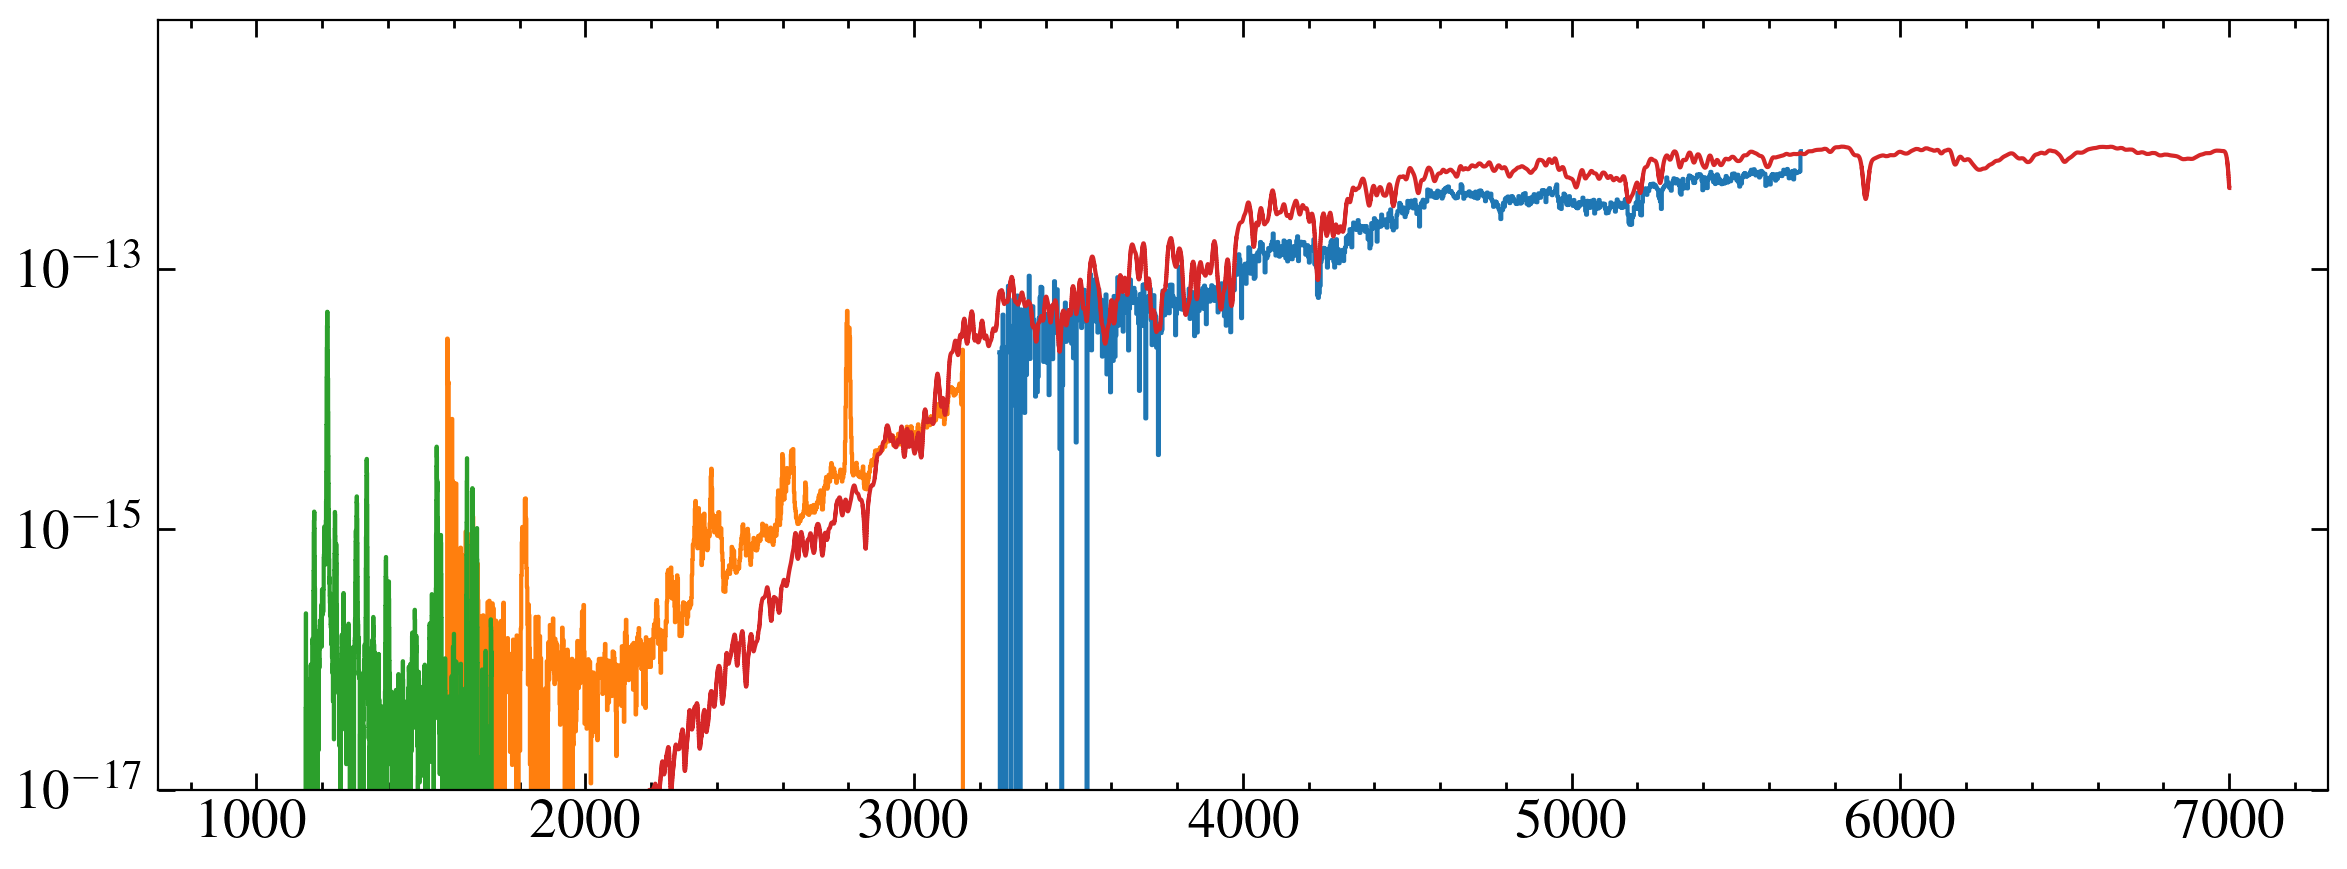

In [9]:
plt.step(ow, of, where='mid')
plt.step(nw, nf, where='mid')
plt.step(fw, ff, where='mid')

plt.step(pw, pf, where='mid')

plt.yscale('log')
plt.ylim(1e-17)

1.7731797184742814e-14 1.4586132811091182e-14 1.2156613006608368


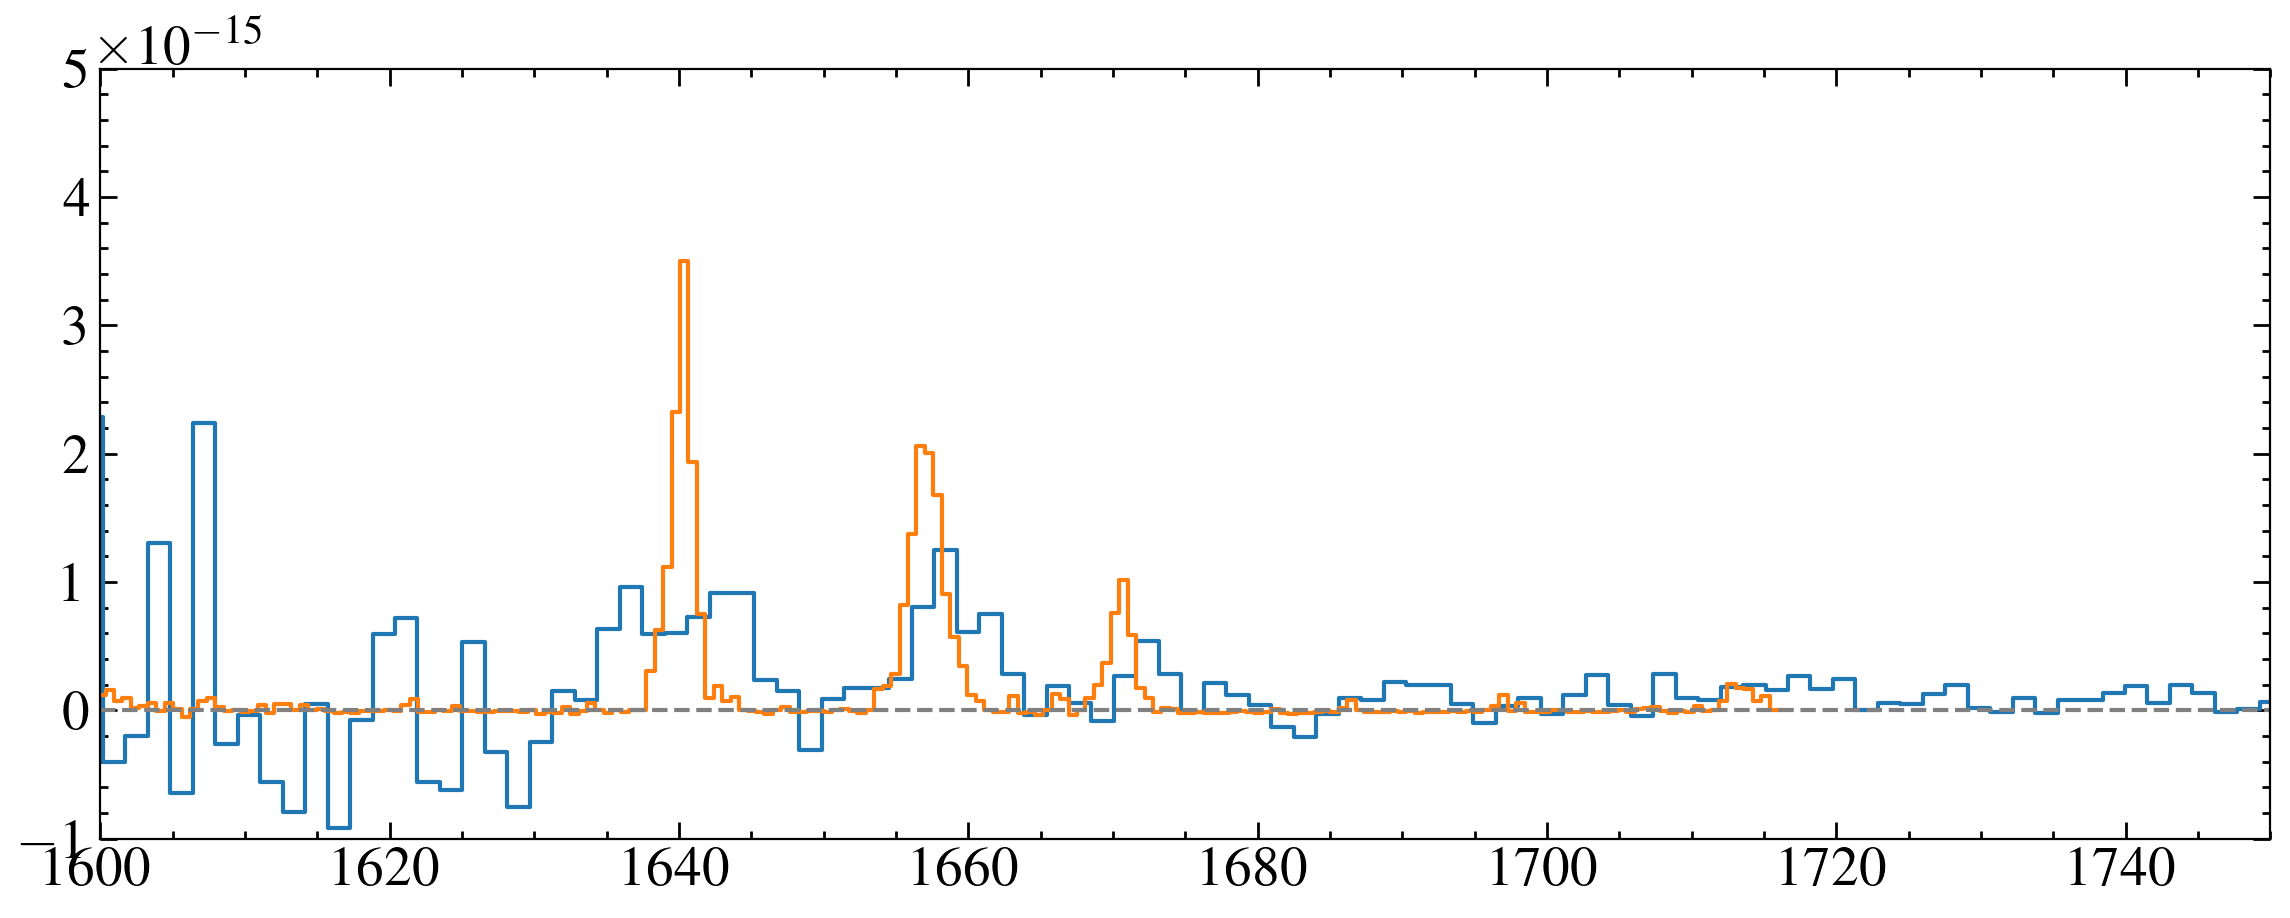

(-1e-15, 5e-15)

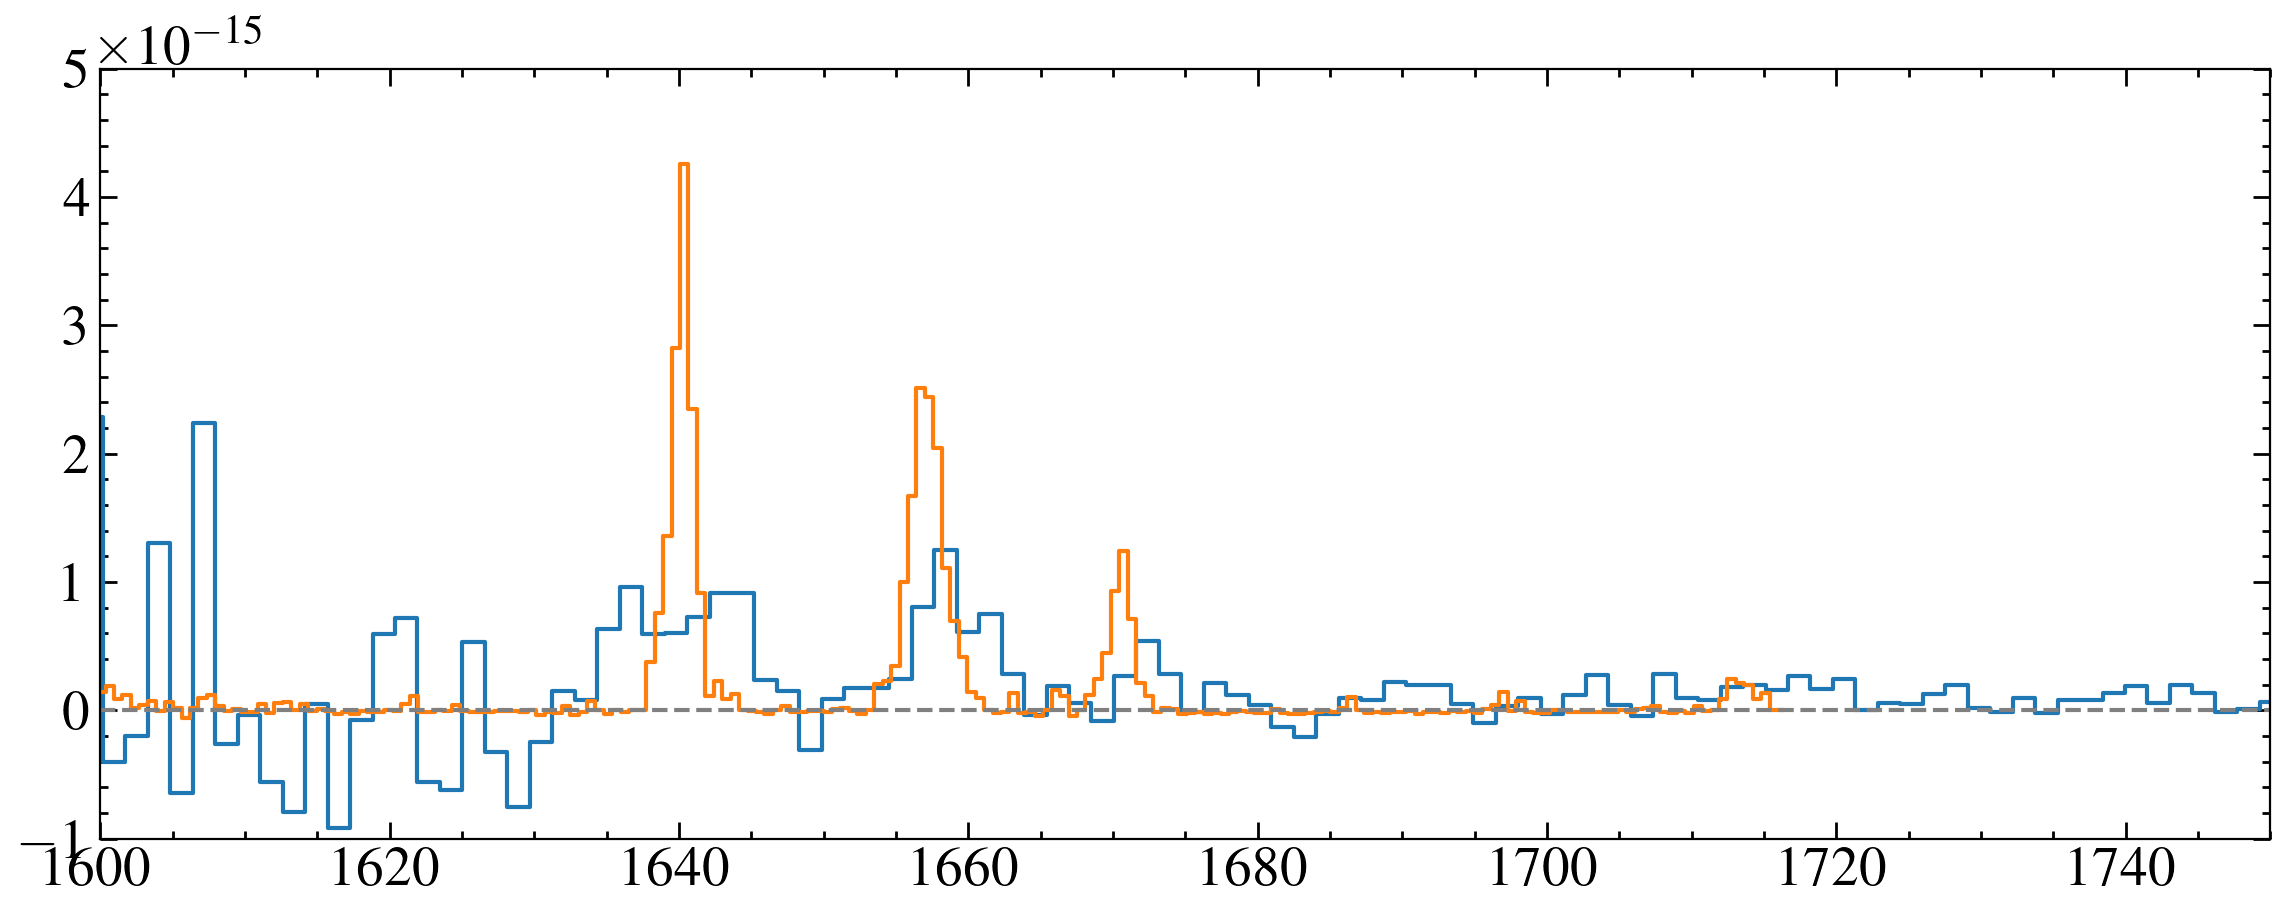

In [10]:
# plt.step(ow, of, where='mid')
plt.step(nw, nf, where='mid')
# plt.step(nw, ne, where='mid')
plt.step(fw, ff, where='mid')
# plt.step(fw, fe, where='mid')
plt.axhline(0, ls ='--', c='0.5')
# plt.step(pw, pf, where='mid')

# plt.yscale('log')
# plt.ylim(1e-17)

plt.xlim(1600, 1750)
plt.ylim(-1e-15, 0.5e-14)

lines =[1630, 1680]
nlinemask = (nw > lines[0]) & (nw < lines[1])
nint = np.trapz(nf[nlinemask], nw[nlinemask])

flinemask = (fw > lines[0]) & (fw < lines[1])
fint = np.trapz(ff[flinemask], fw[flinemask])

print(nint, fint, nint/fint)

scale = nint/fint

plt.show()


plt.step(nw, nf, where='mid')
# plt.step(nw, ne, where='mid')
plt.step(fw, ff*scale, where='mid')
# plt.step(fw, fe, where='mid')
plt.axhline(0, ls ='--', c='0.5')
# plt.step(pw, pf, where='mid')
plt.xlim(1600, 1750)
plt.ylim(-1e-15, 0.5e-14)

Do those lines show up in all stars?

In [11]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'

stars = os.listdir(path)
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

GJ1132
GJ15A
2.2128395915485724e-12 1.1162535444149805e-13 19.823807974632714


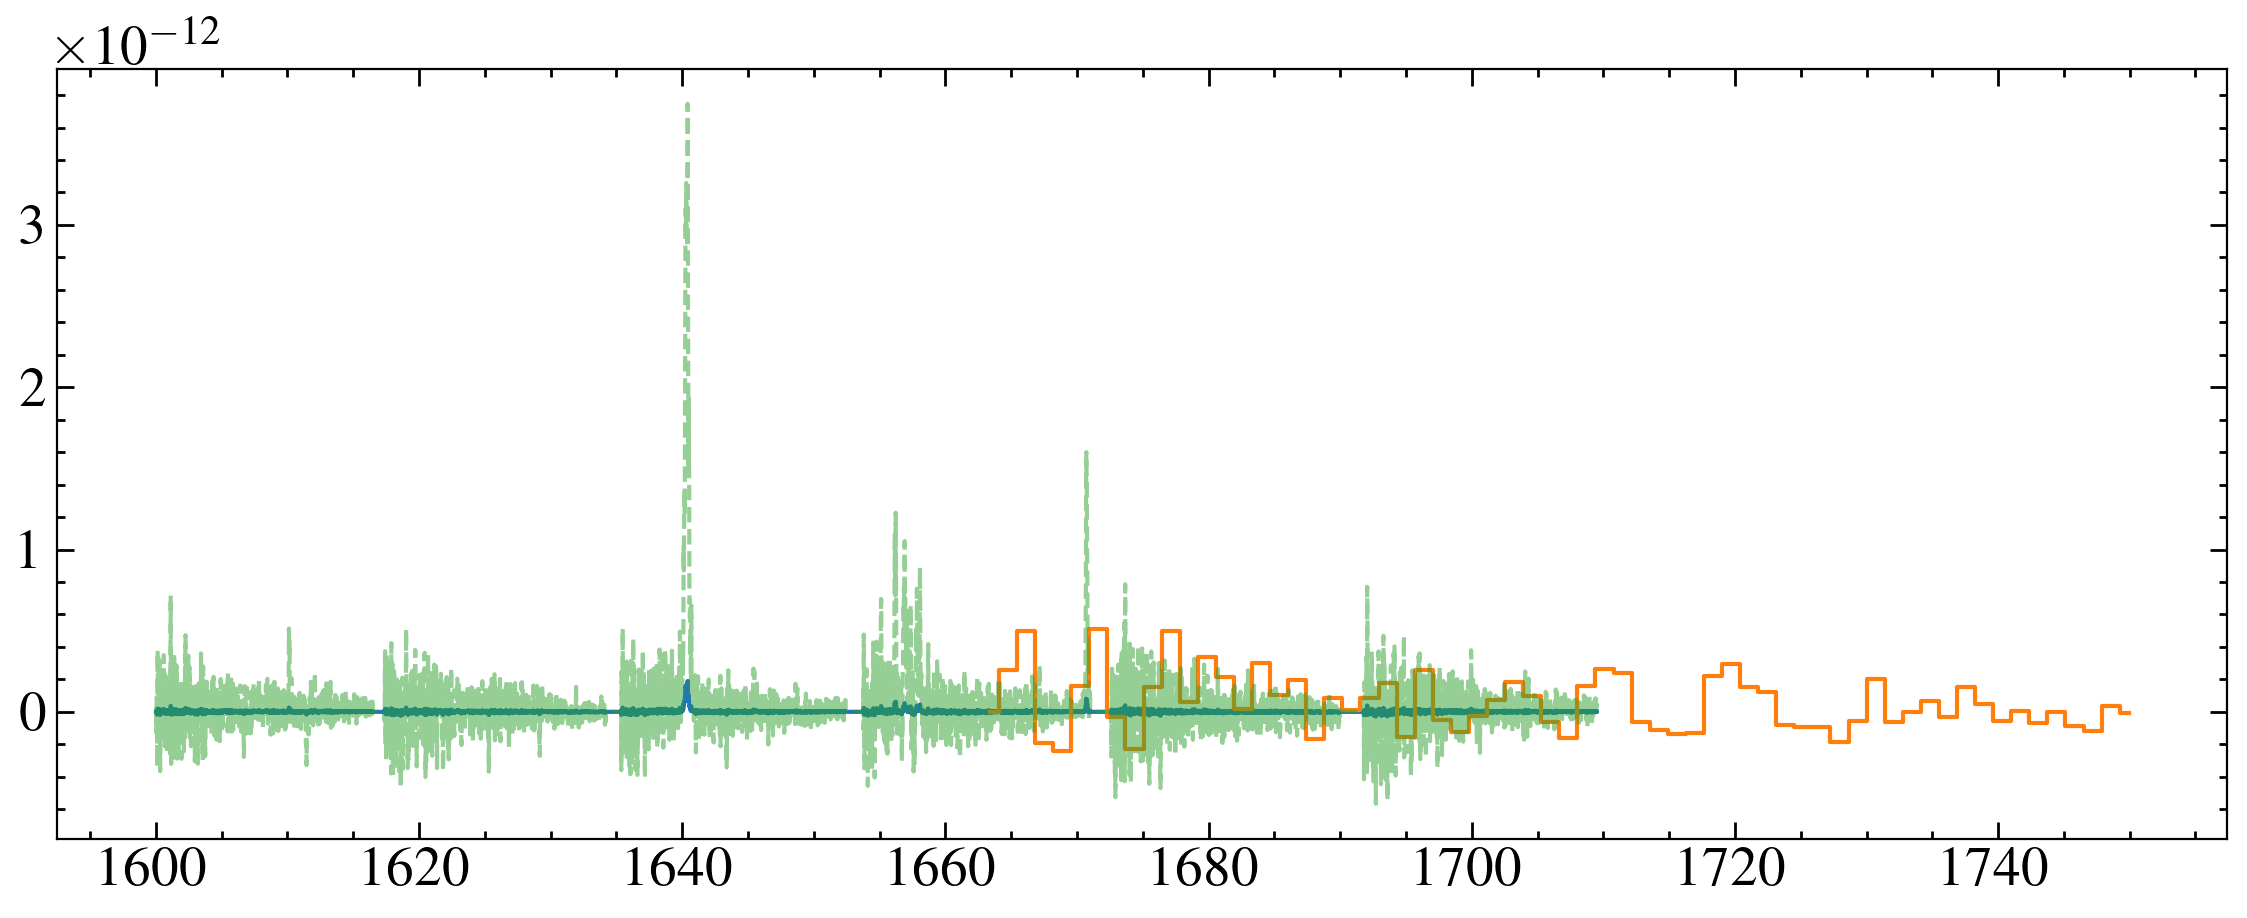

GJ163
GJ649
5.866775723837604e-15 1.3527316809266612e-14 0.43369840497996537


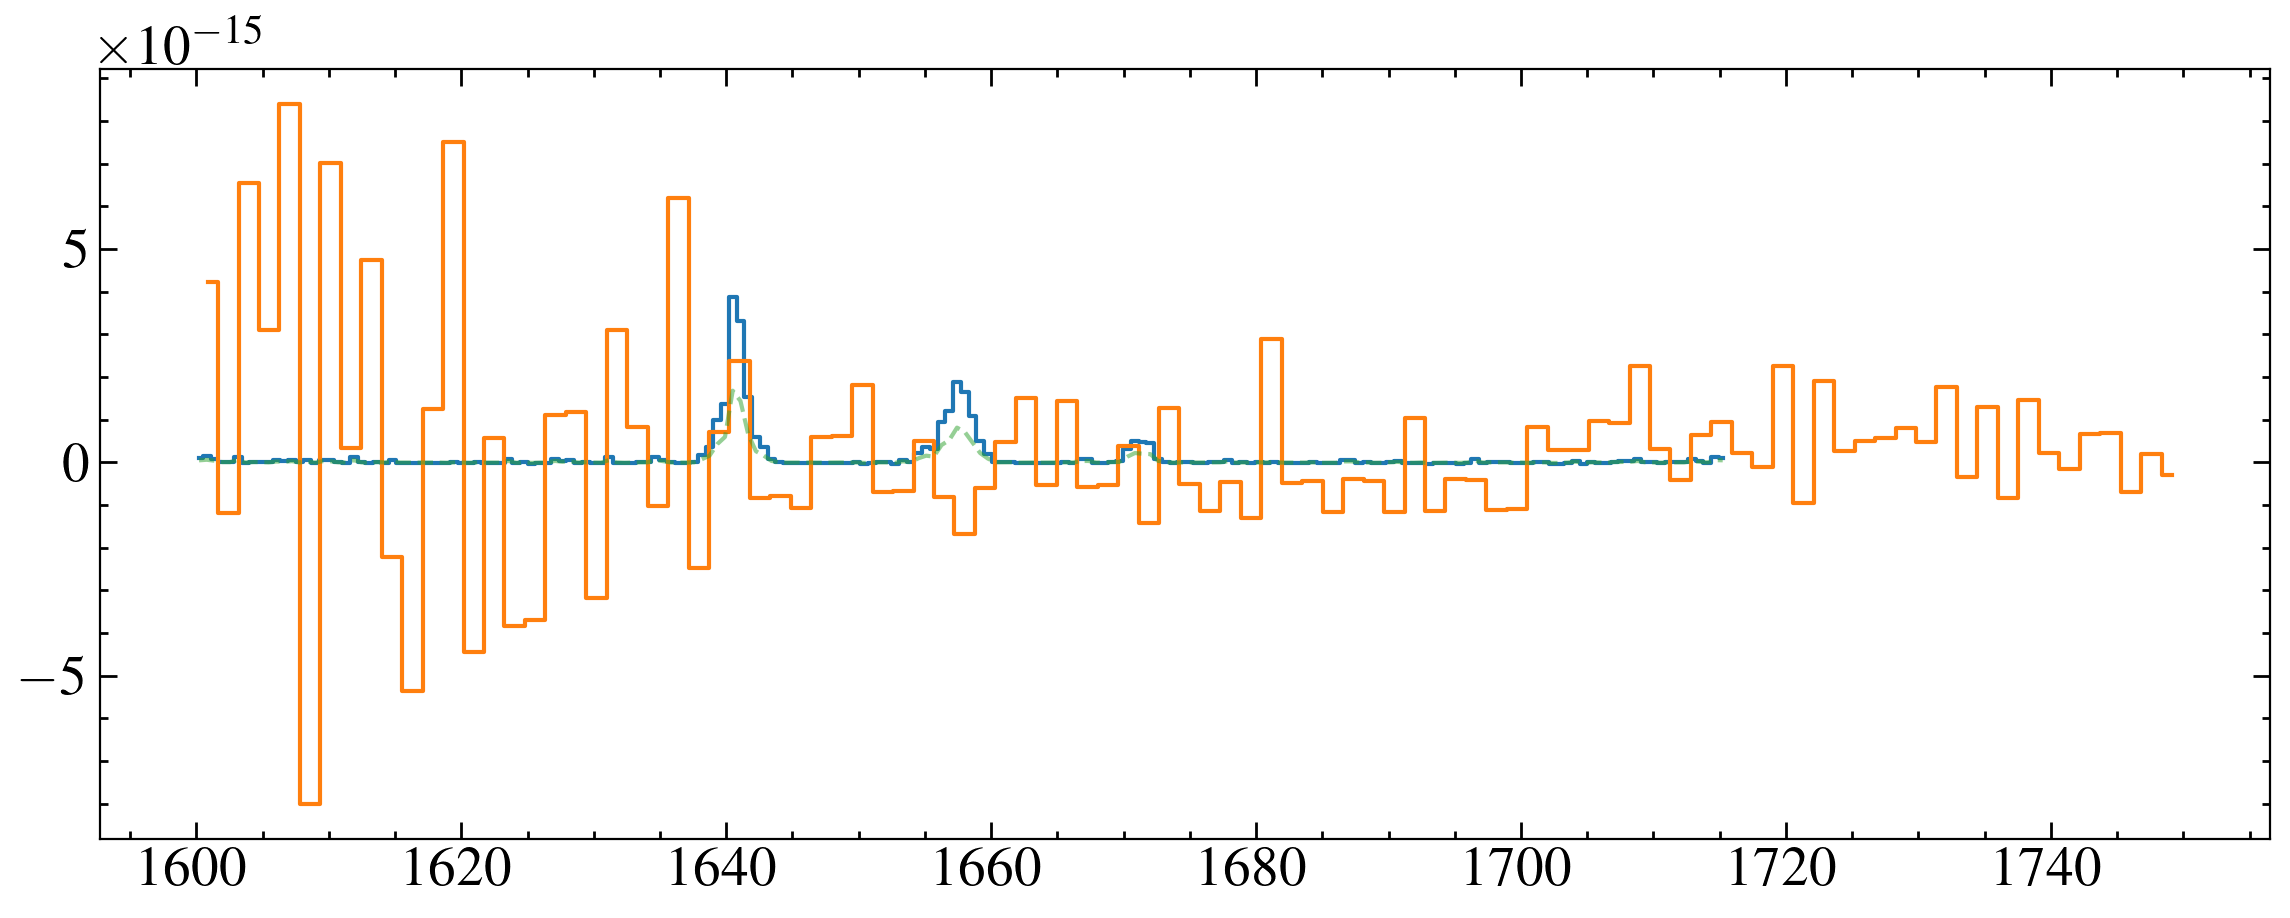

GJ674
5.883068492536266e-14 4.964634605681726e-14 1.1849952634587544


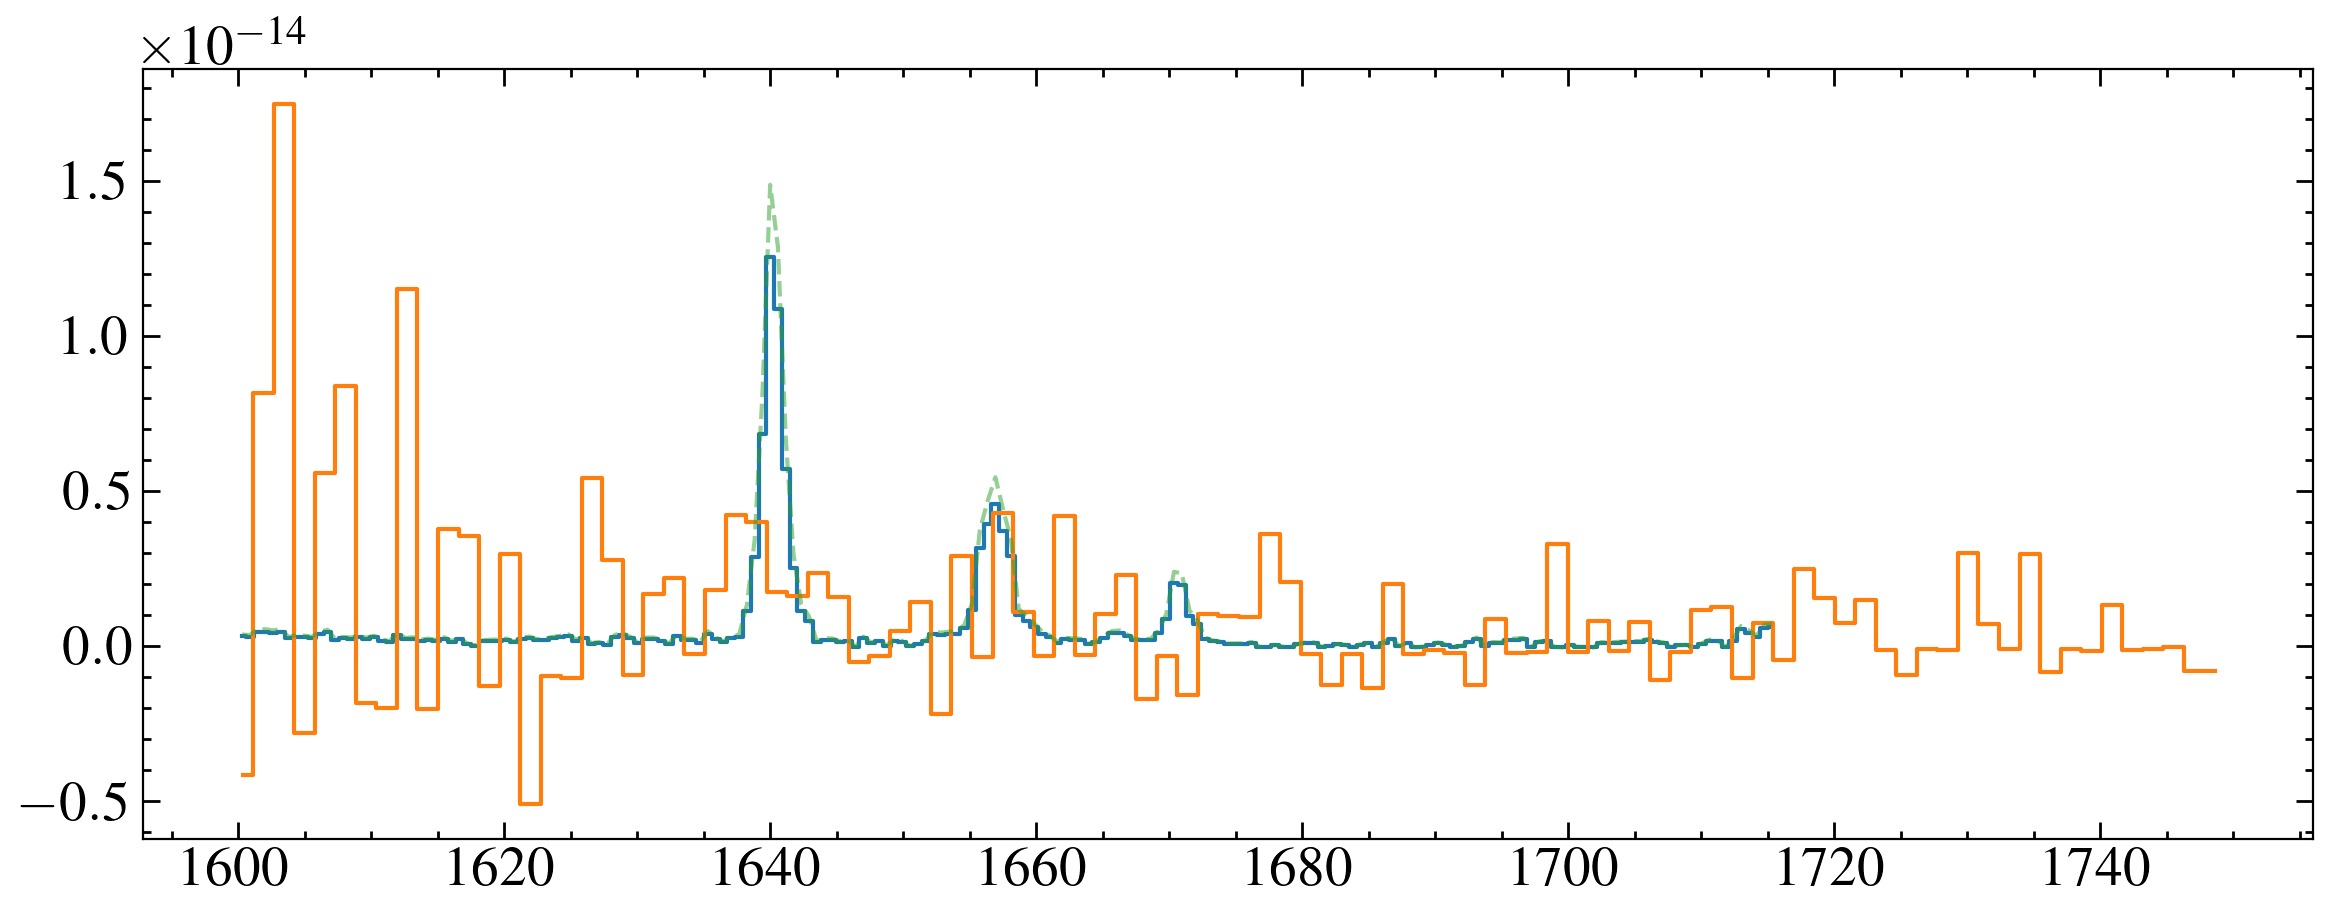

GJ676A
1.7731797184742814e-14 1.4586132811091182e-14 1.2156613006608368


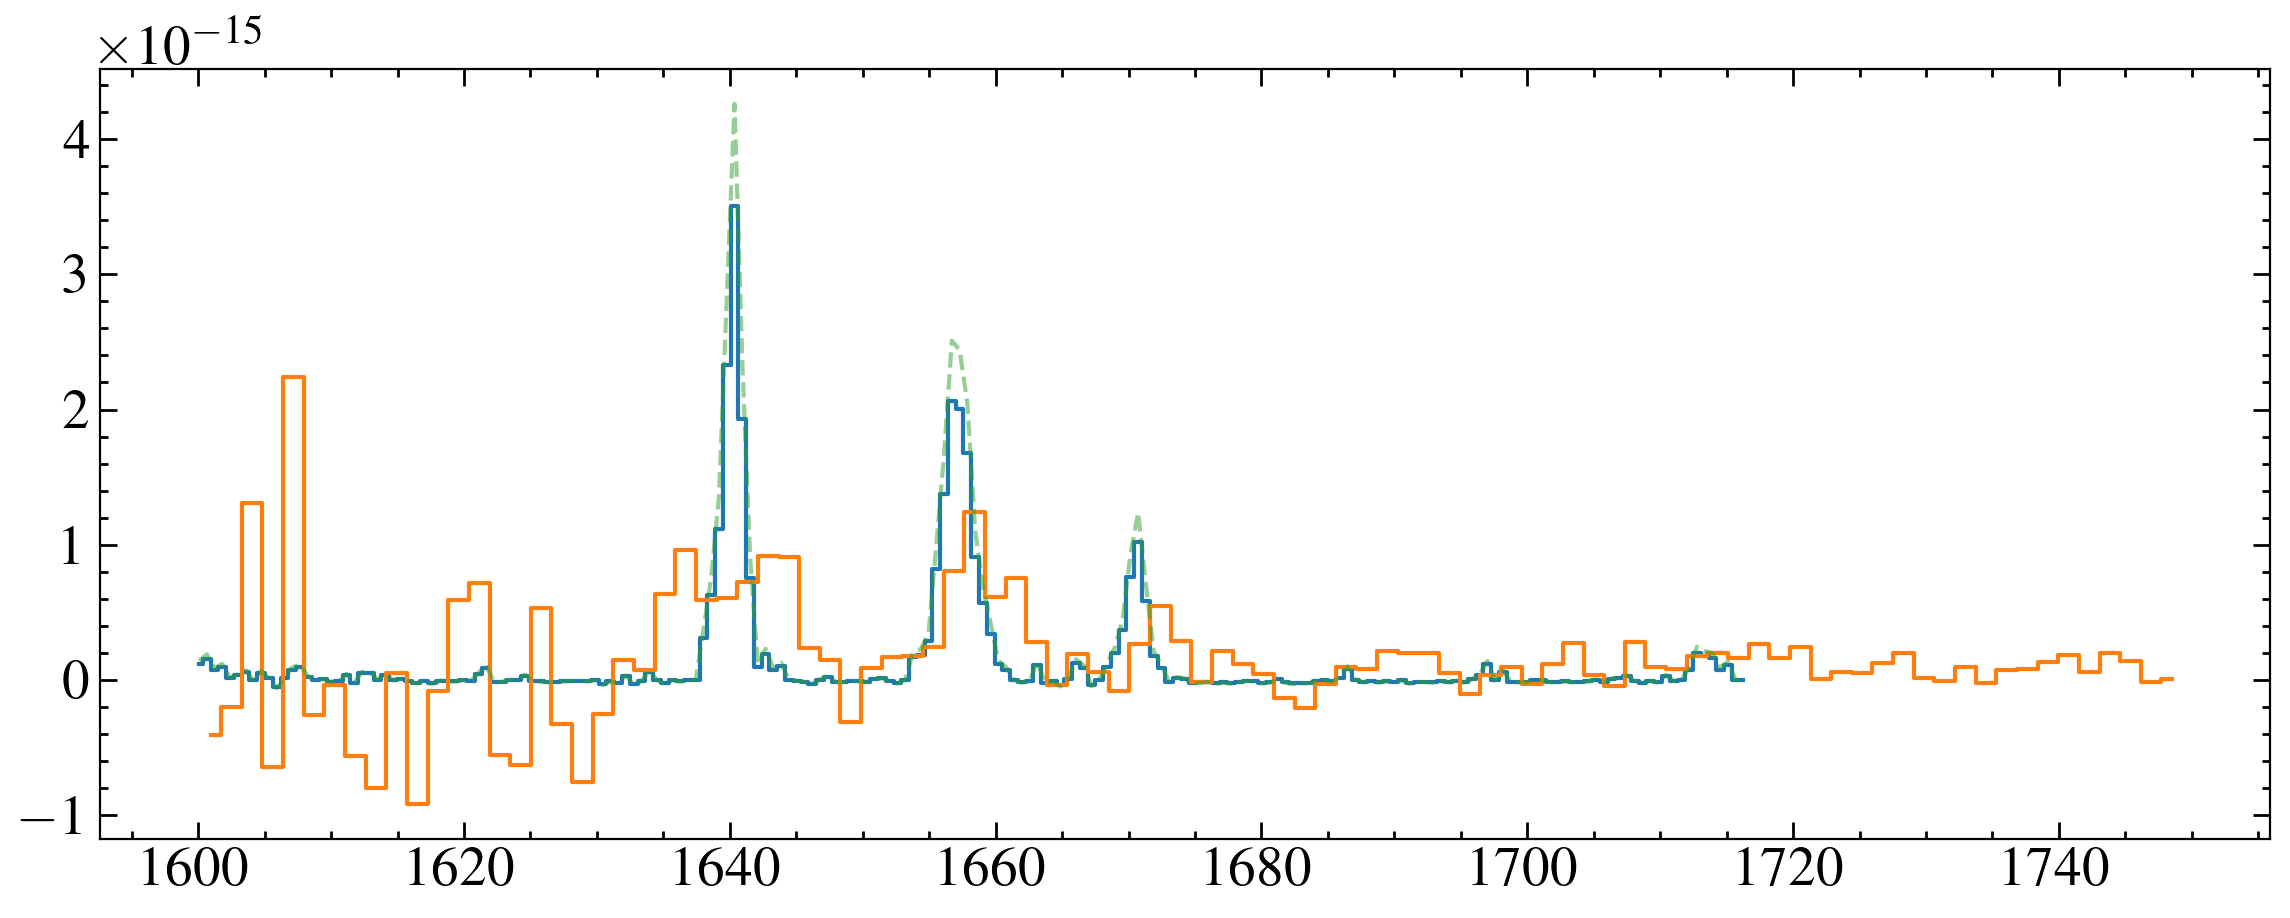

GJ699
1.7354823618427178e-14 1.0098963623573445e-14 1.718475703577819


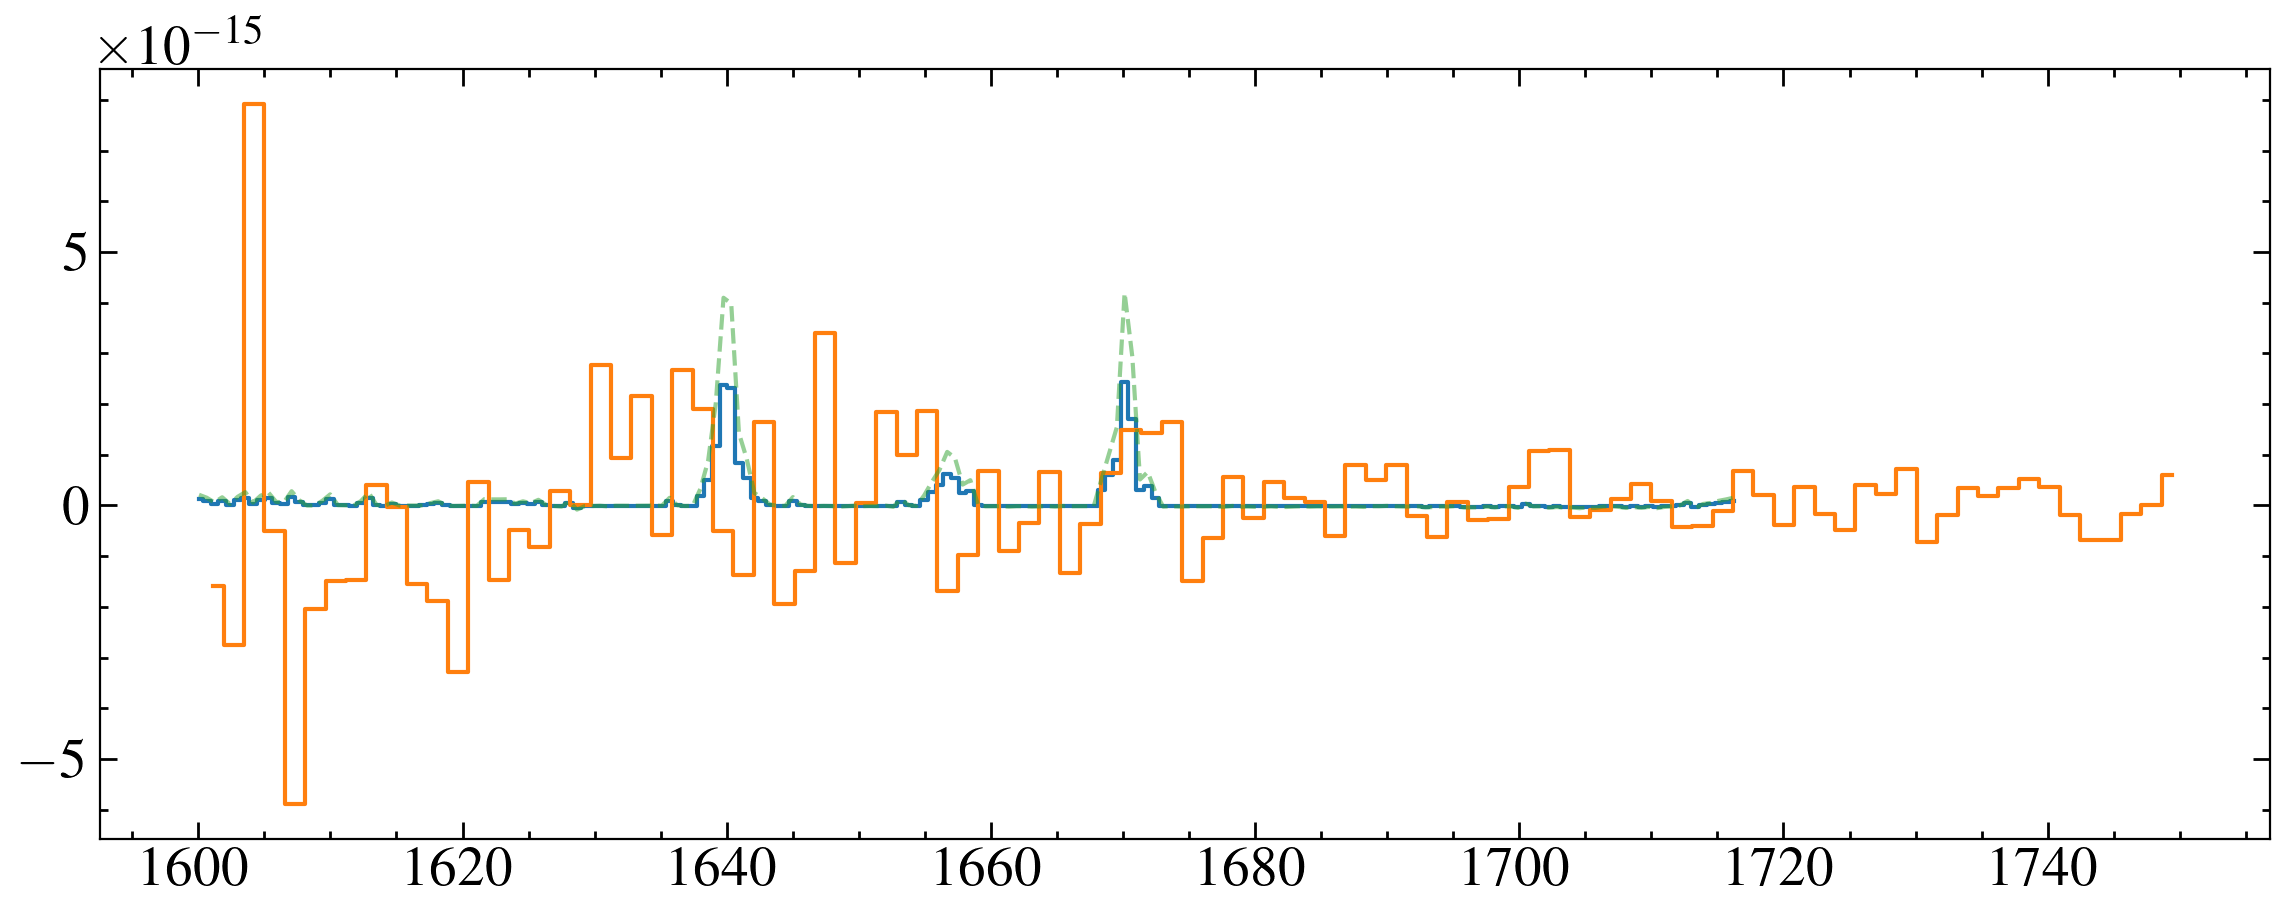

GJ729
1.9501861751936002e-13 2.803315640058634e-14 6.956712784411285


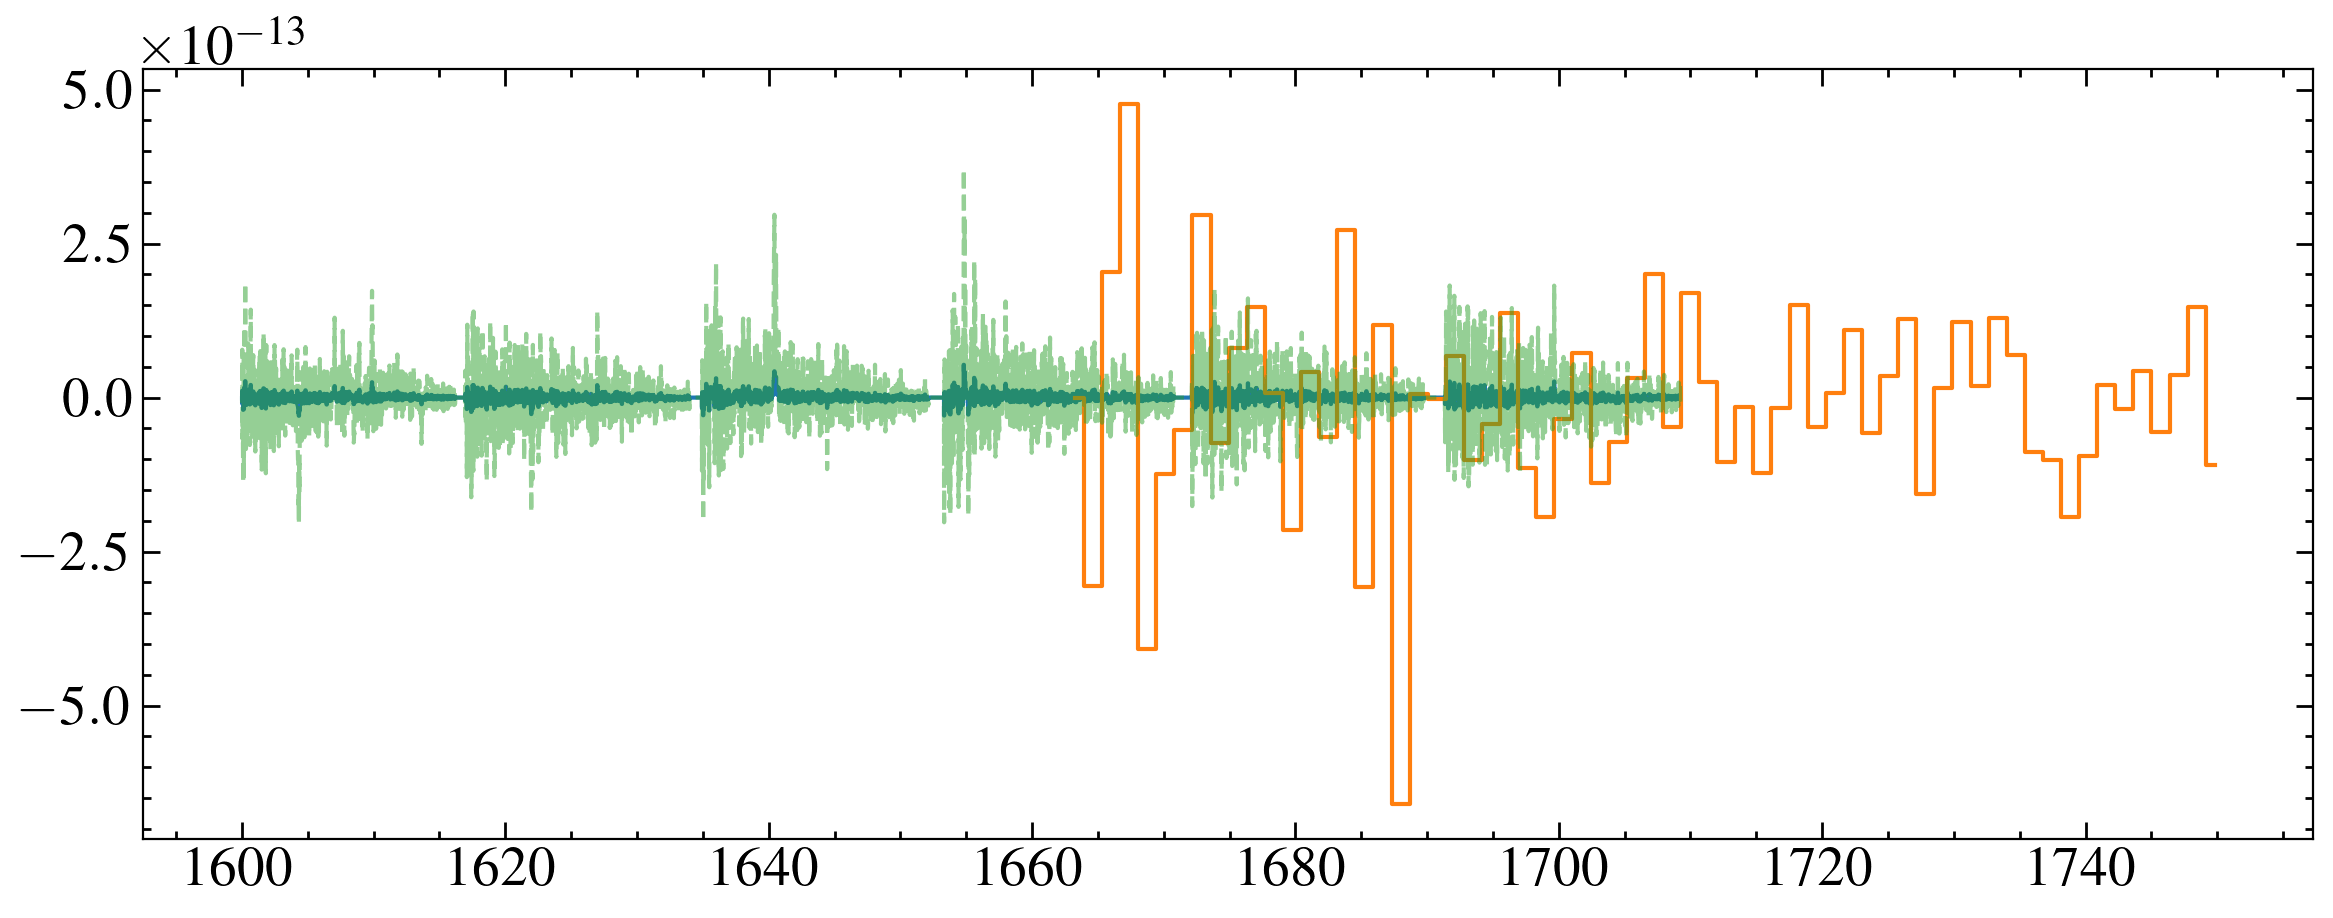

GJ849
L-980-5
LHS-2686
7.651312483700653e-15 3.947666020329099e-15 1.938186372479098


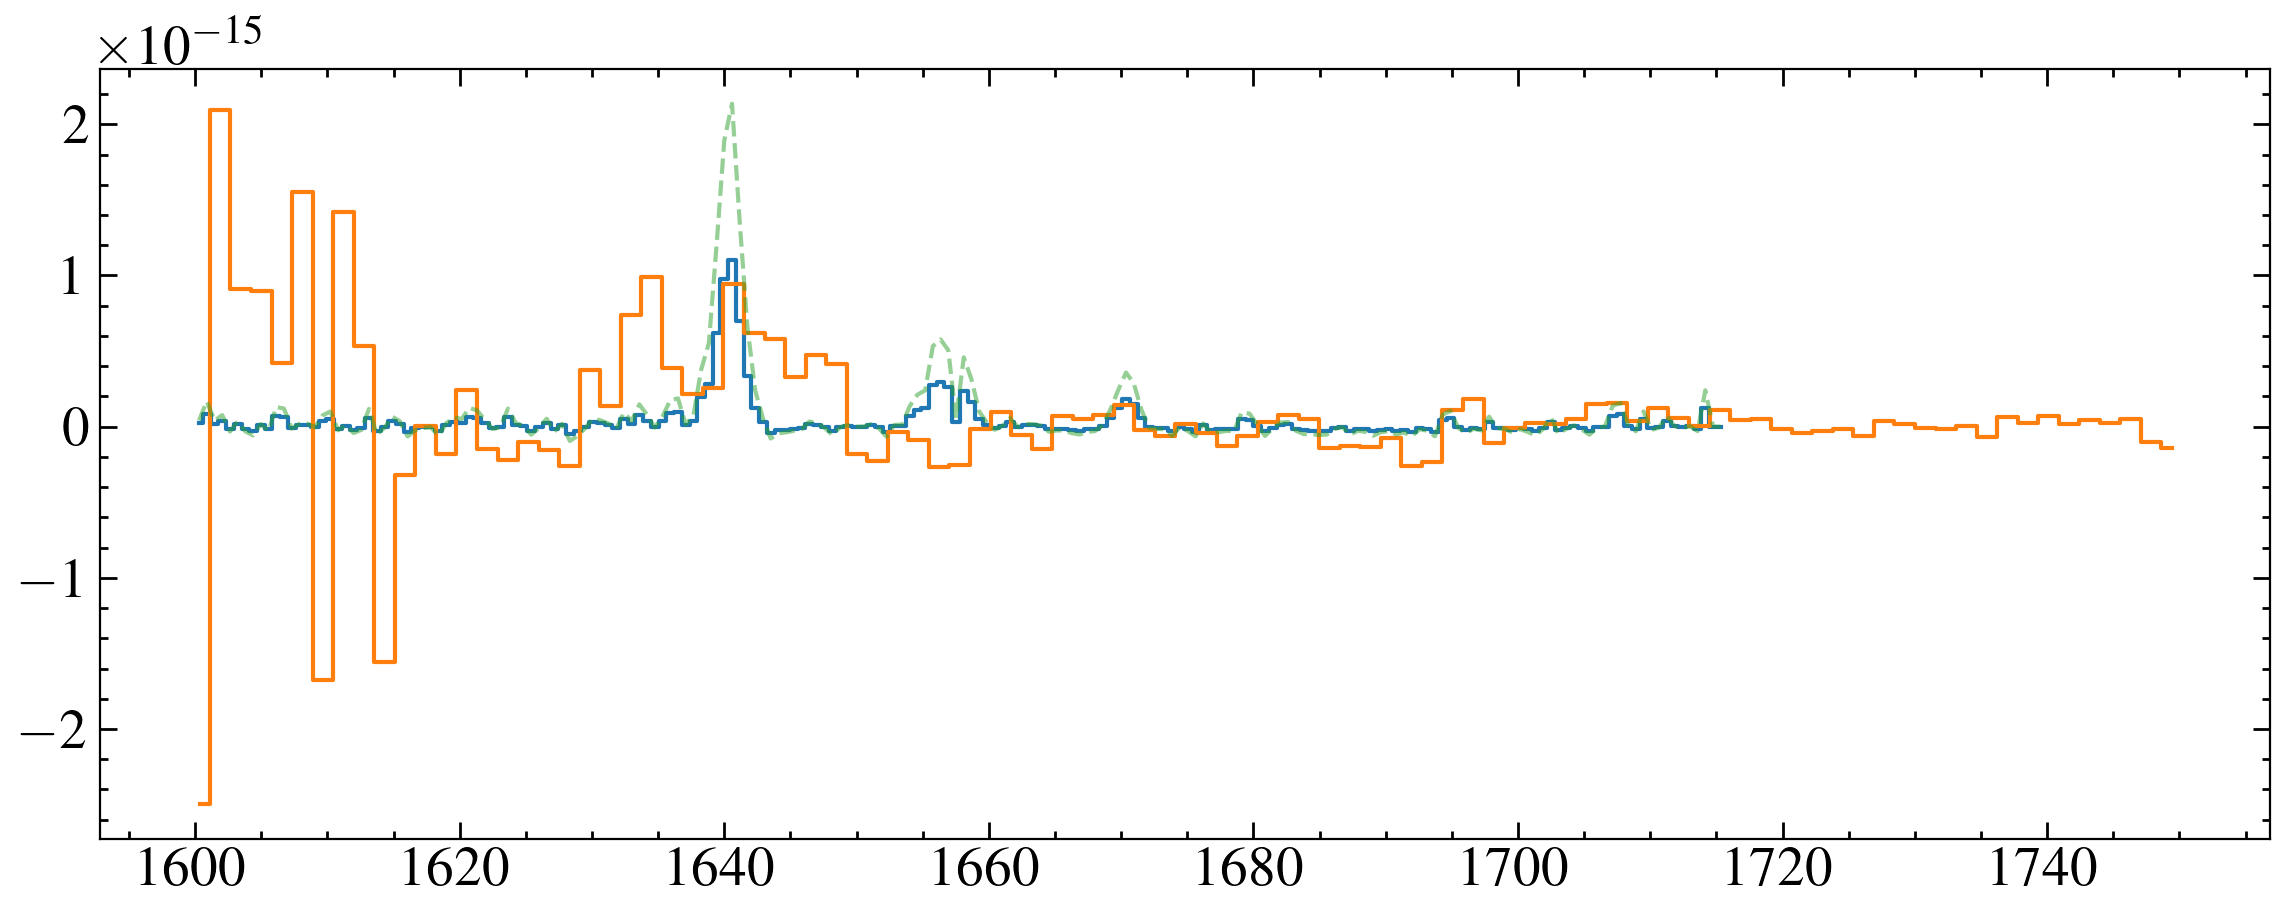

In [12]:
for star in stars[:-1]:
    print(star)
    fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    if len(fuv) == 0:
        fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    ndata = fits.getdata(nuv[0], 1)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    
    lap = [1600, 1750]
    fmask = (fw > lap[0]) & (fw < lap[1])
    fw, ff, fe = fw[fmask], ff[fmask], fe[fmask]
    
    nmask = (nw > lap[0]) & (nw < lap[1])
    nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
    
    plt.step(fw, ff, where='mid')
    plt.step(nw, nf, where='mid')
    
    
    lines =[1630, 1680]
    nlinemask = (nw > lines[0]) & (nw < lines[1])
    nint = np.trapz(nf[nlinemask], nw[nlinemask])

    flinemask = (fw > lines[0]) & (fw < lines[1])
    fint = np.trapz(ff[flinemask], fw[flinemask])

    print(nint, fint, nint/fint)
    
    scale = nint/fint
    
    plt.plot(fw, ff*scale, ls='--', alpha=0.5)

    
    plt.show()


Add some filter for meaningful information?

In [13]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


GJ1132


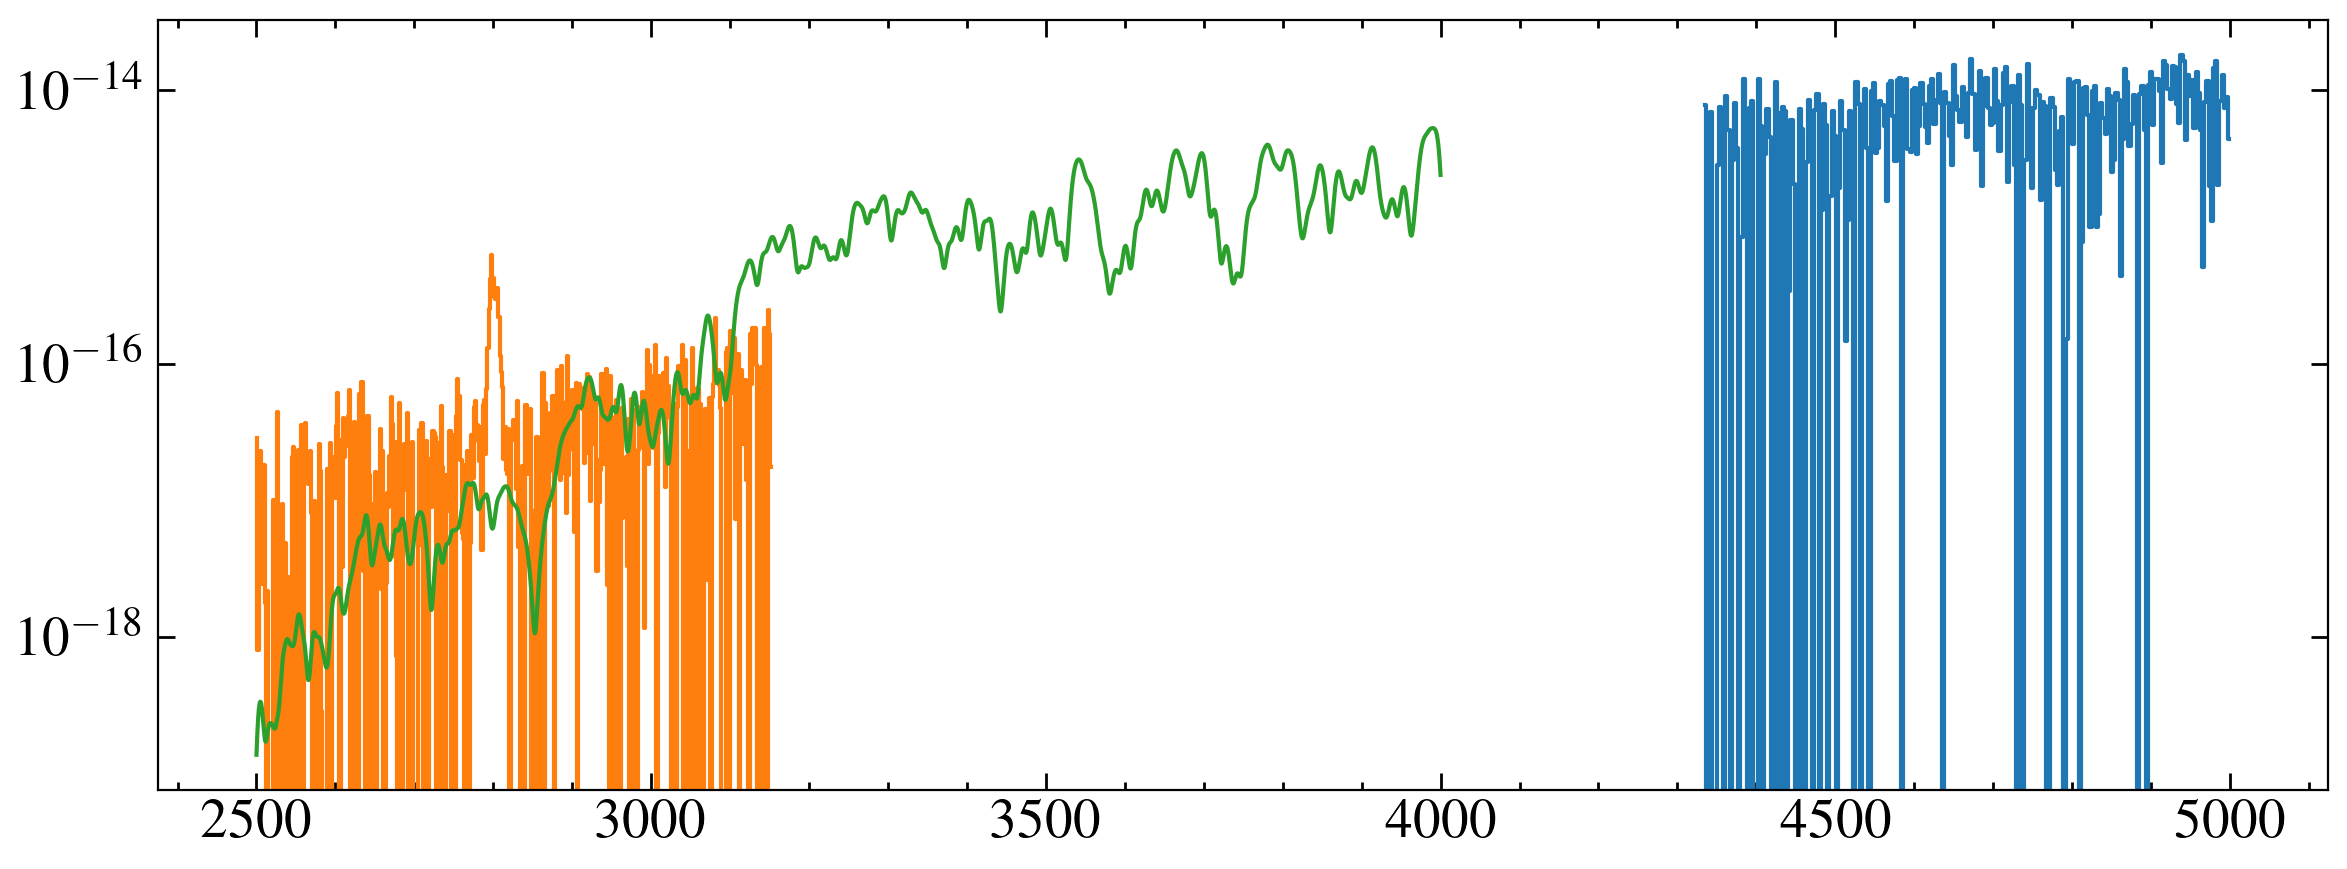

GJ15A


/tmp/ipykernel_101192/1104839509.py:17: RuntimeWarning: invalid value encountered in divide
  sn = np.array([np.mean(of[i:i+bin_width]/oe[i:i+bin_width]) for i in range(len(ow[:-bin_width]))])


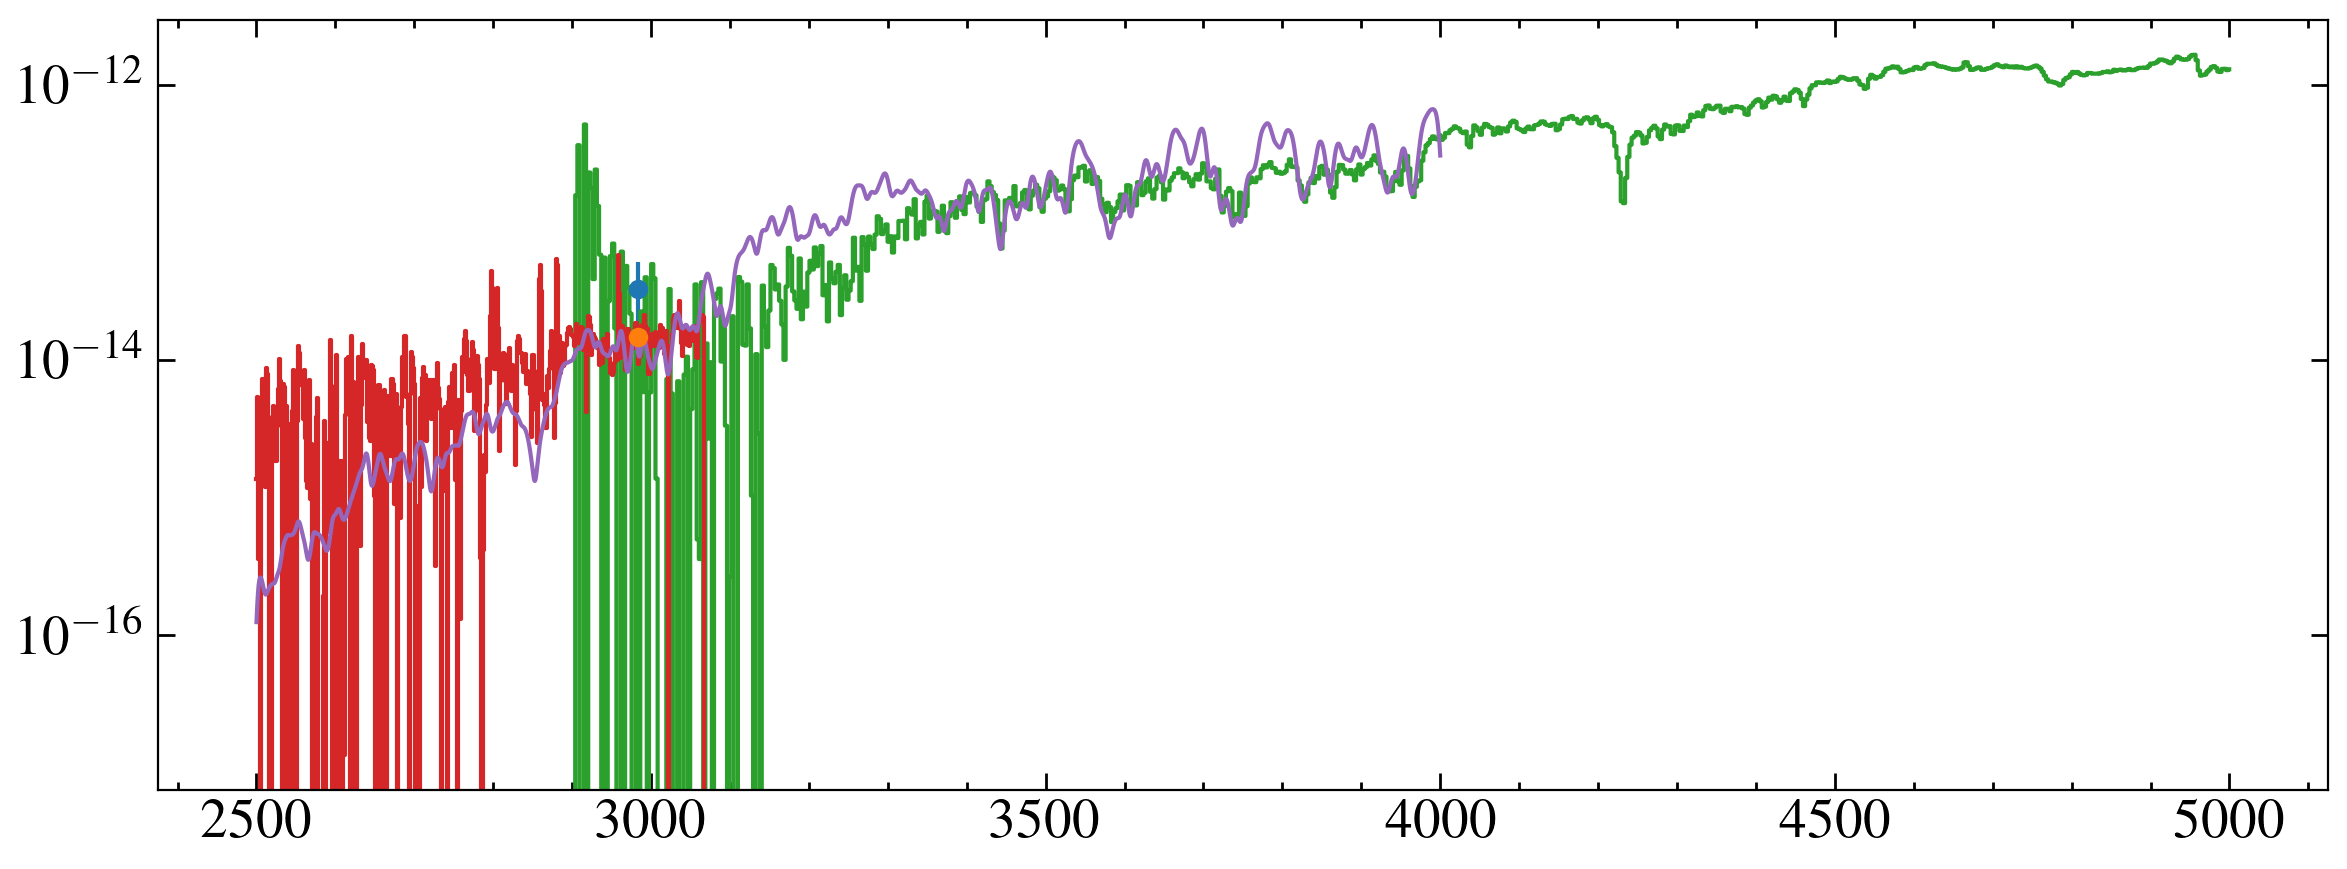

GJ163


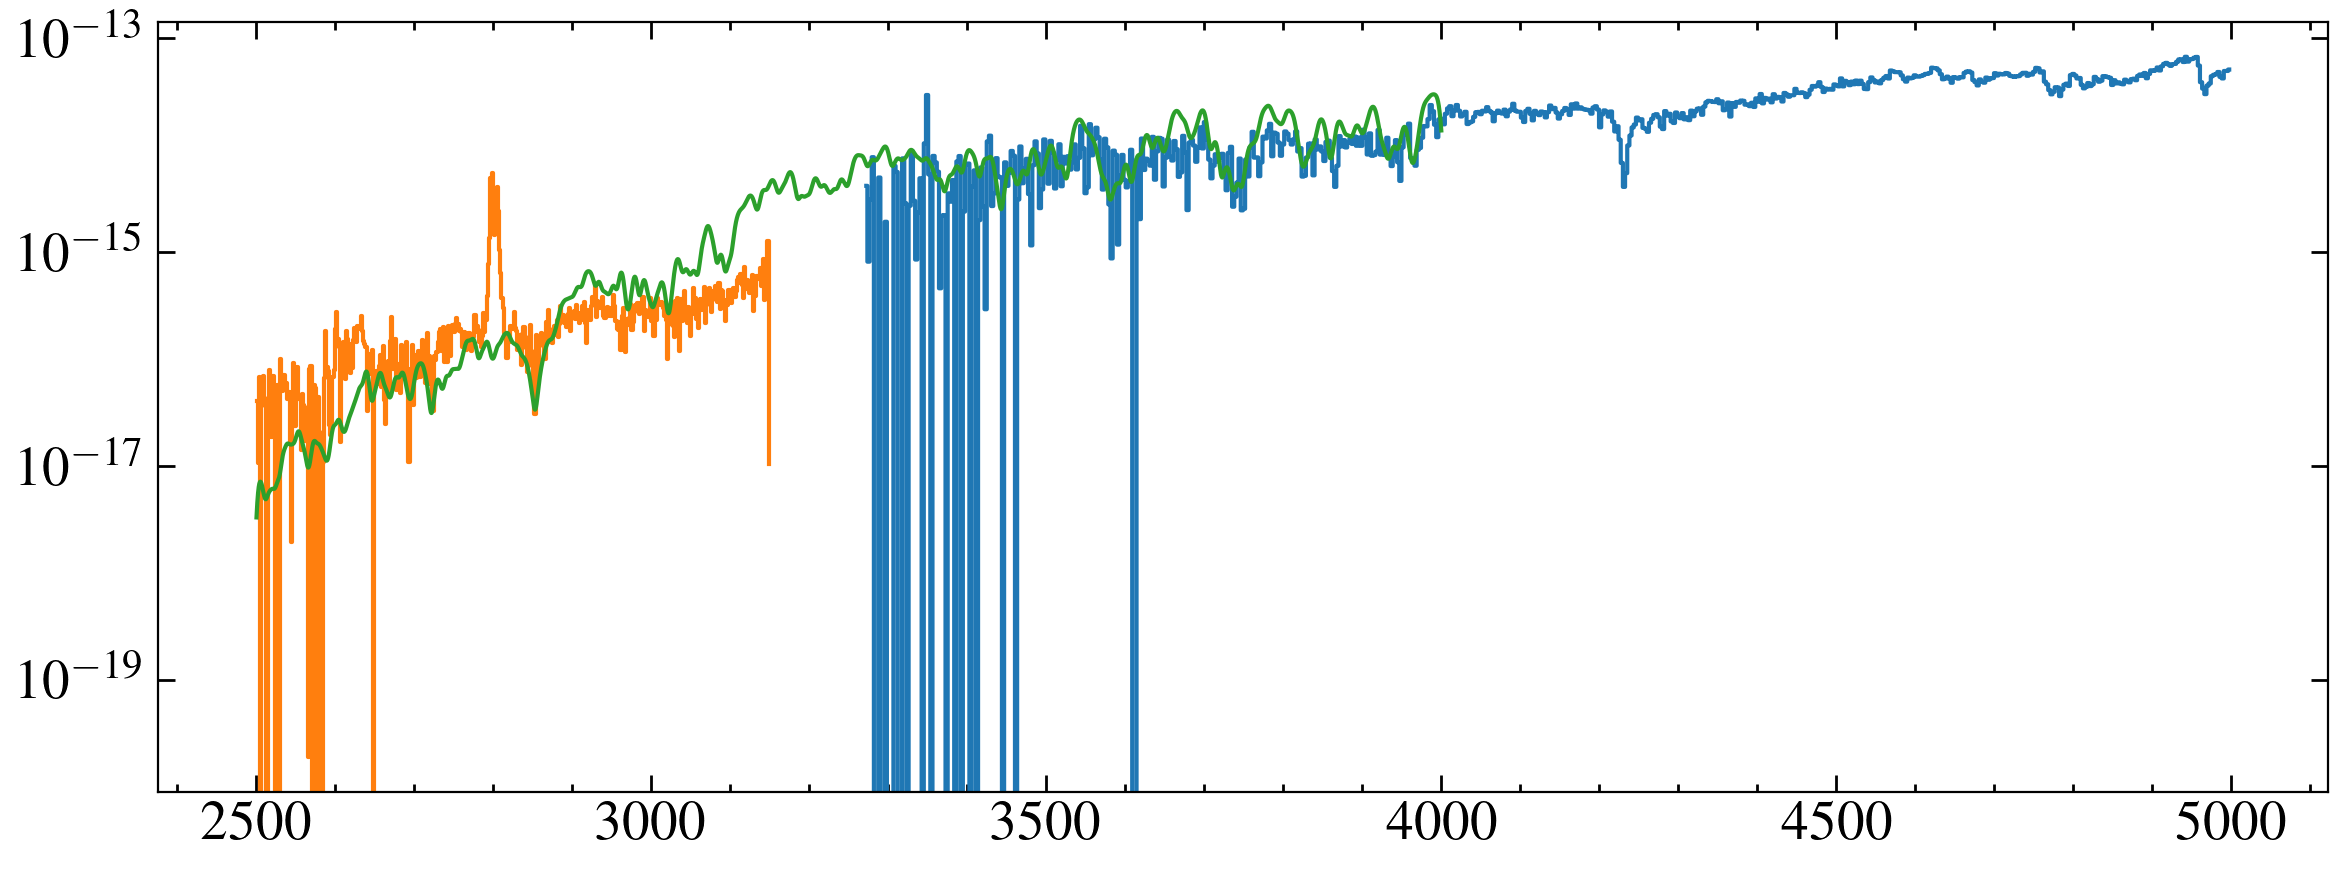

GJ649


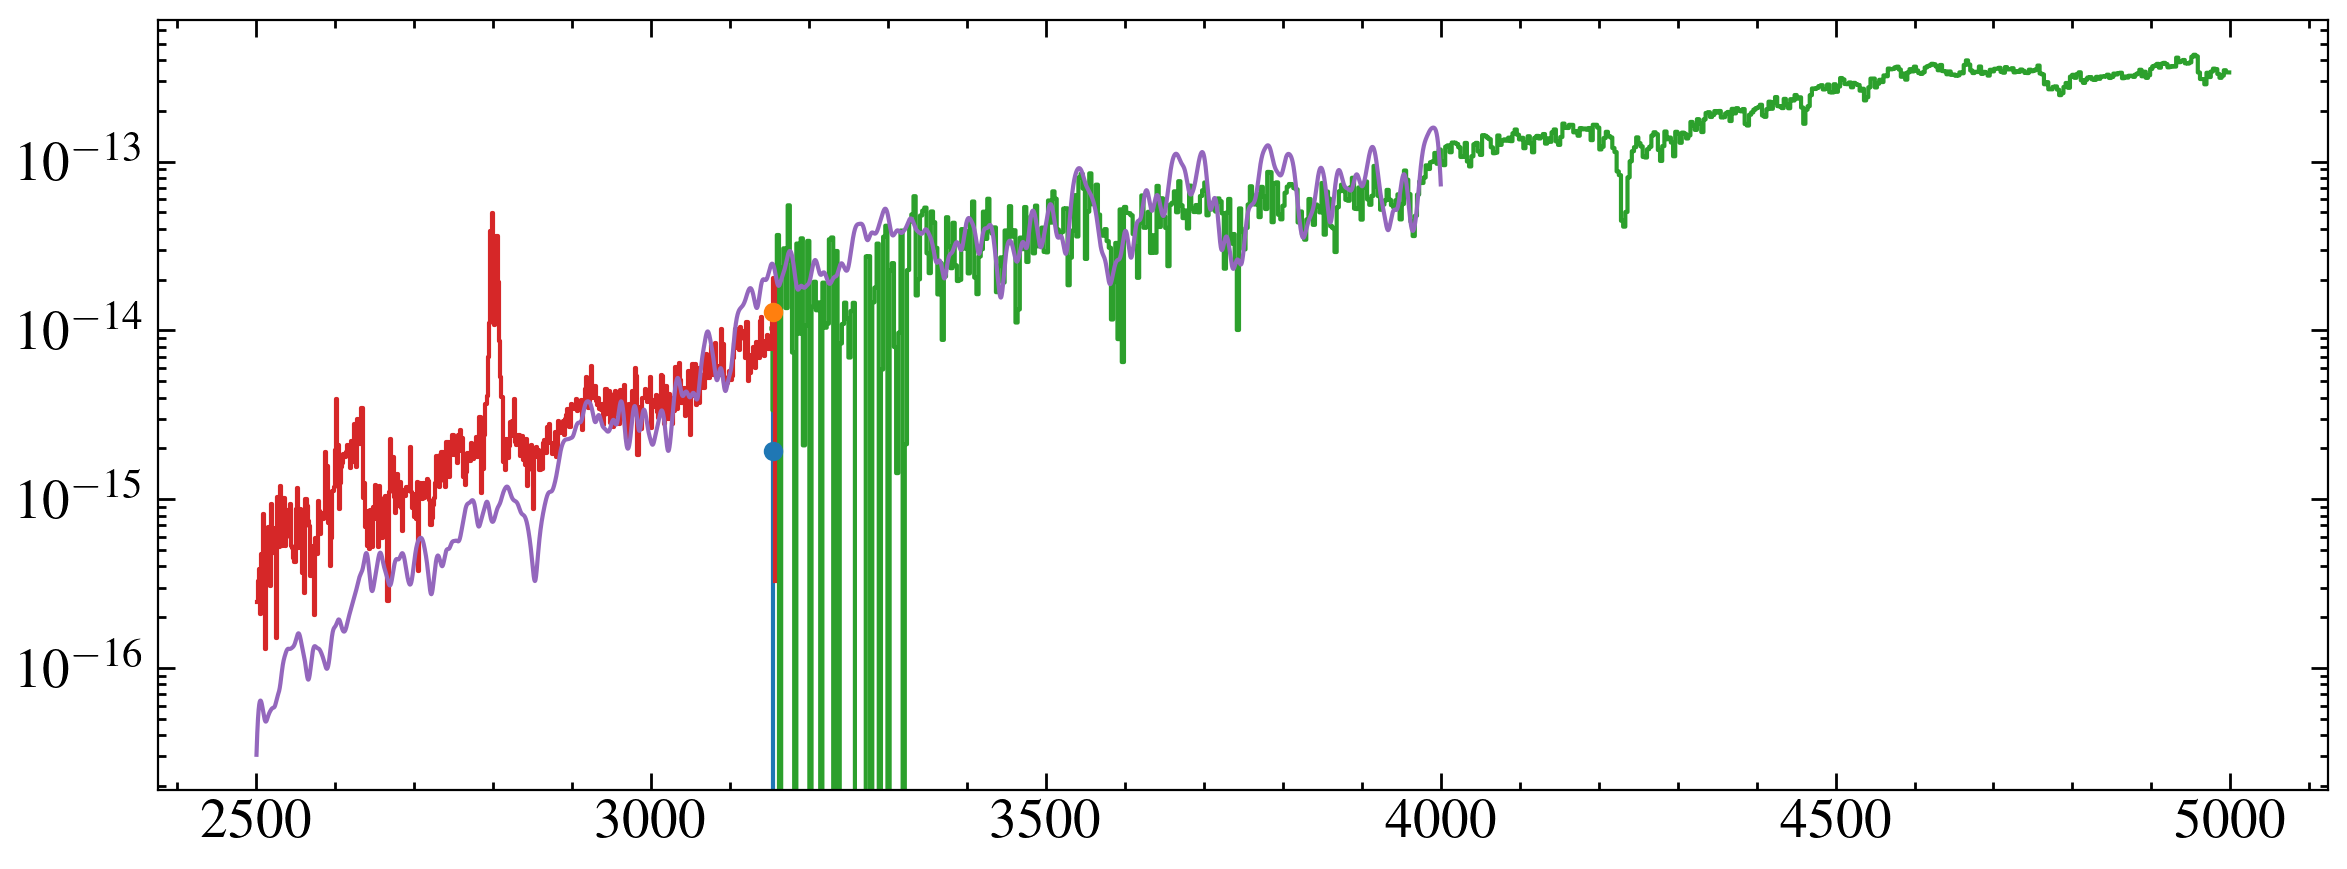

GJ674


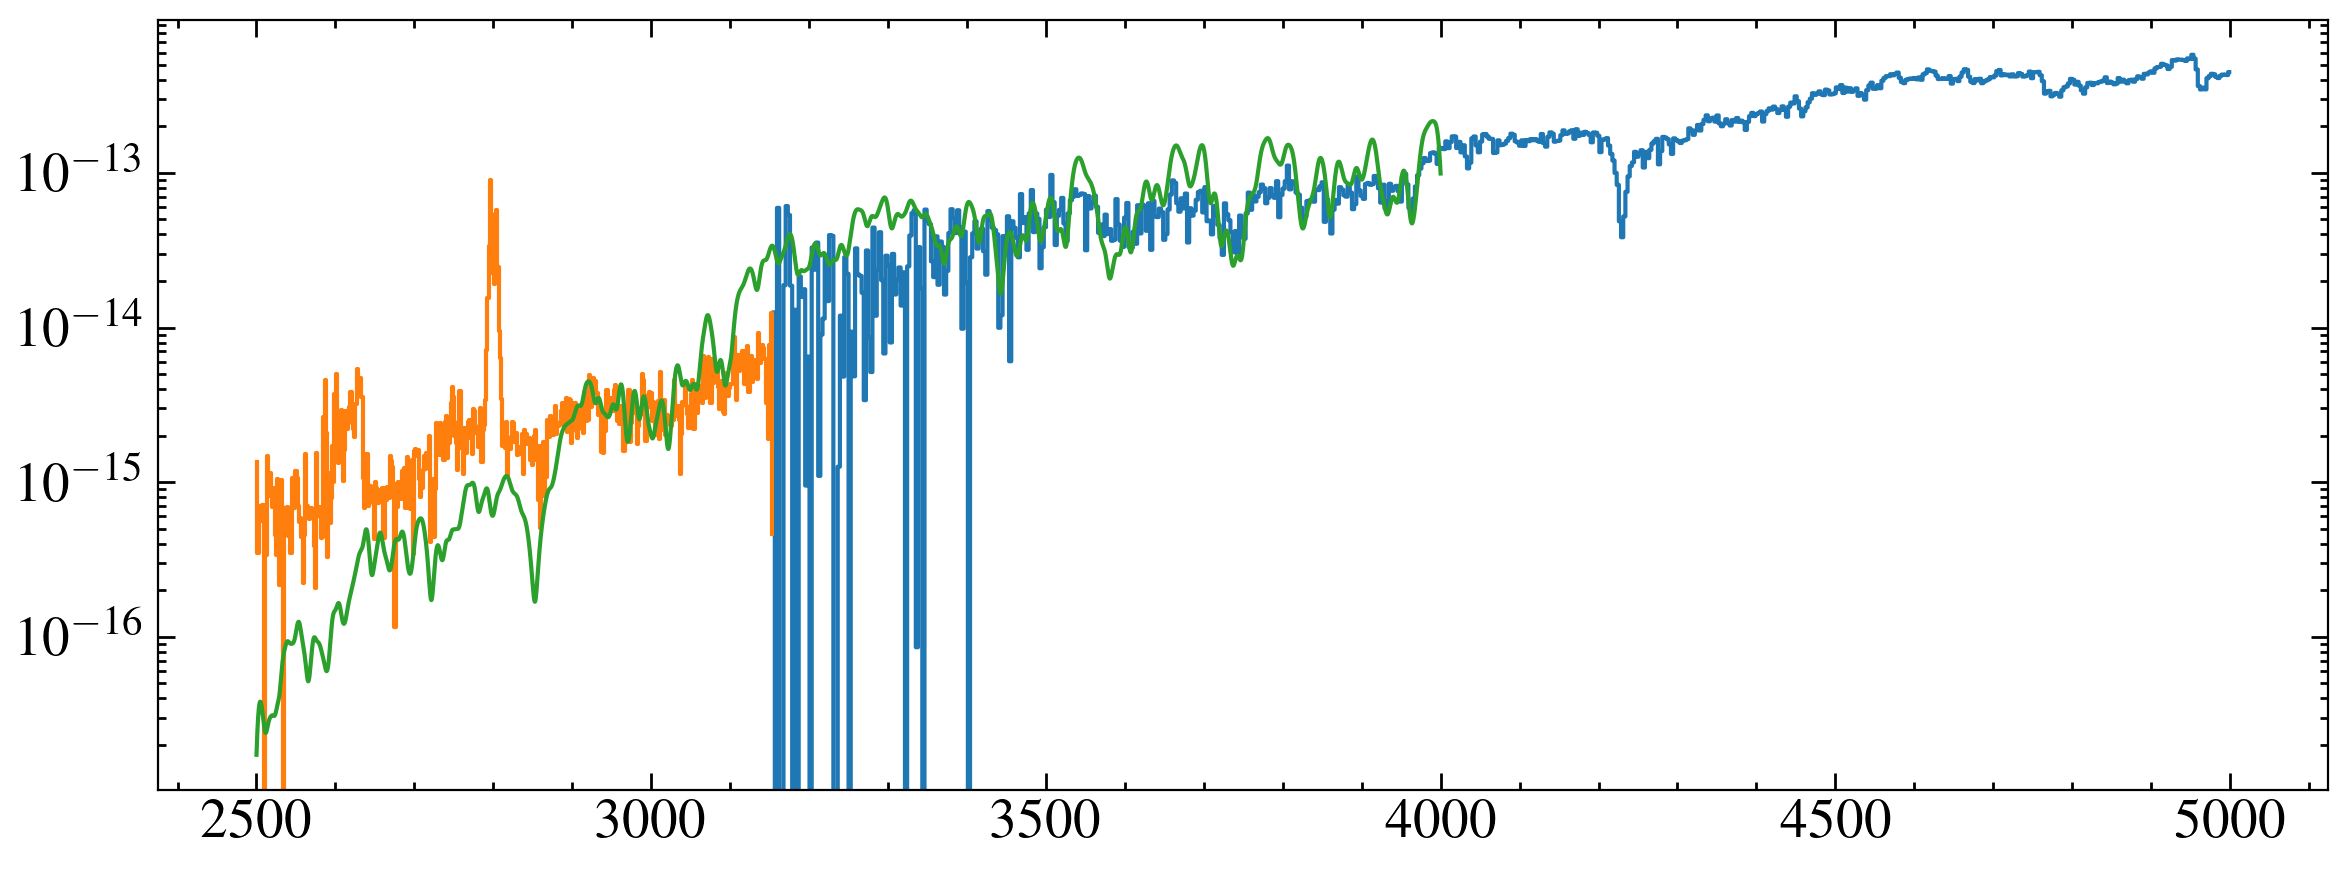

GJ676A


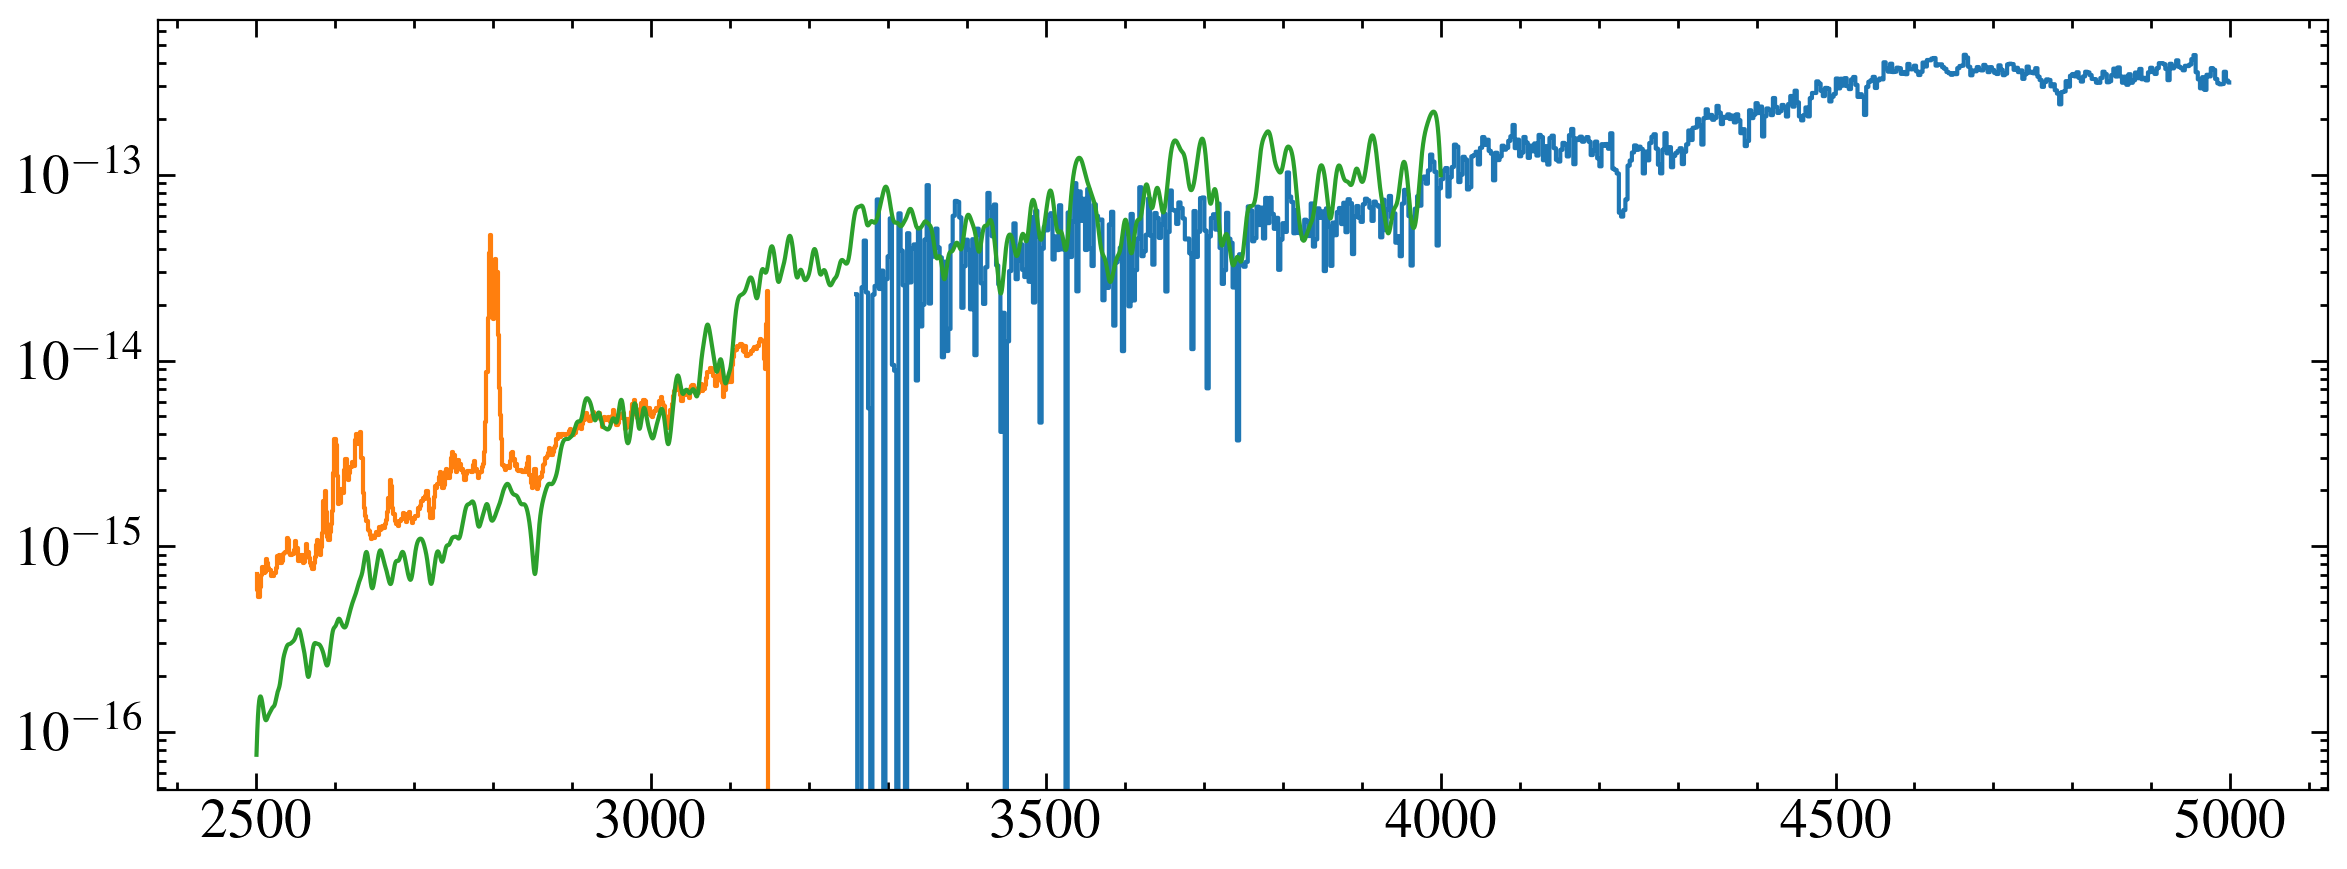

GJ699


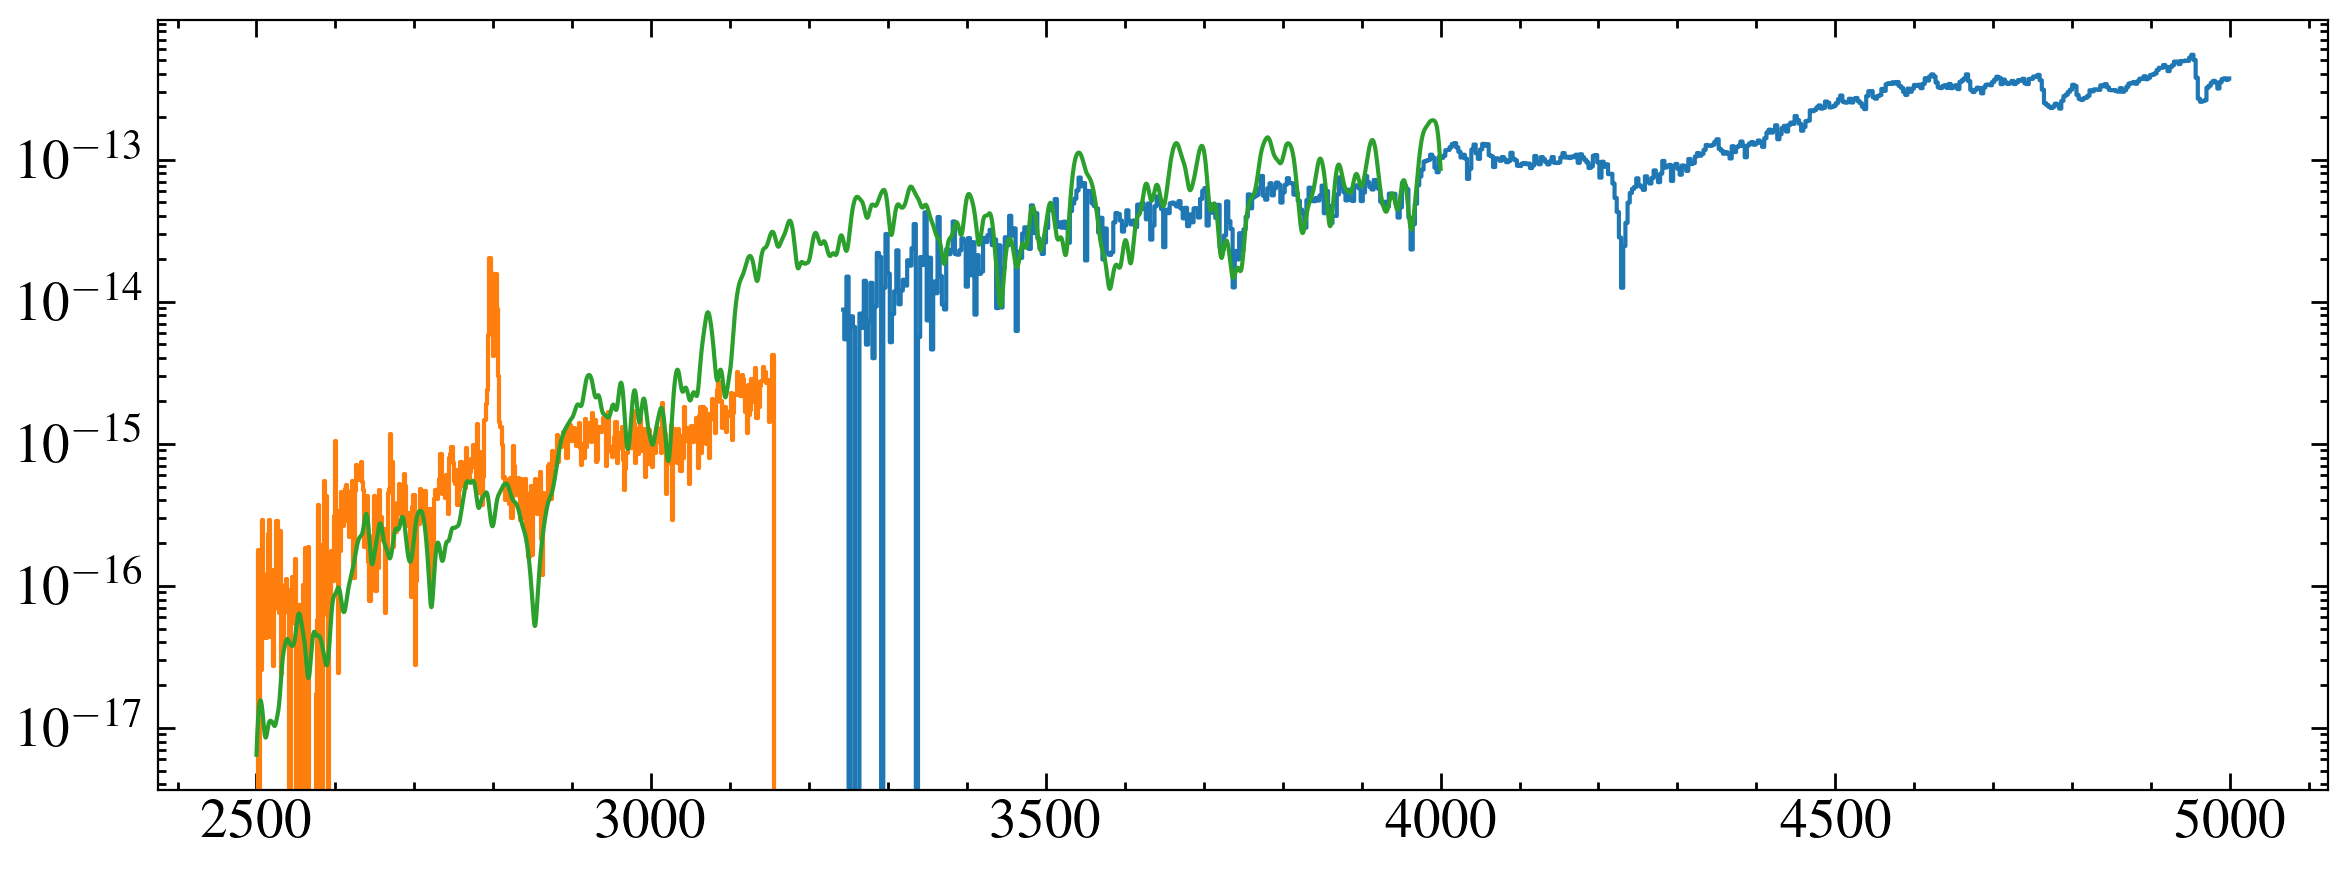

GJ729


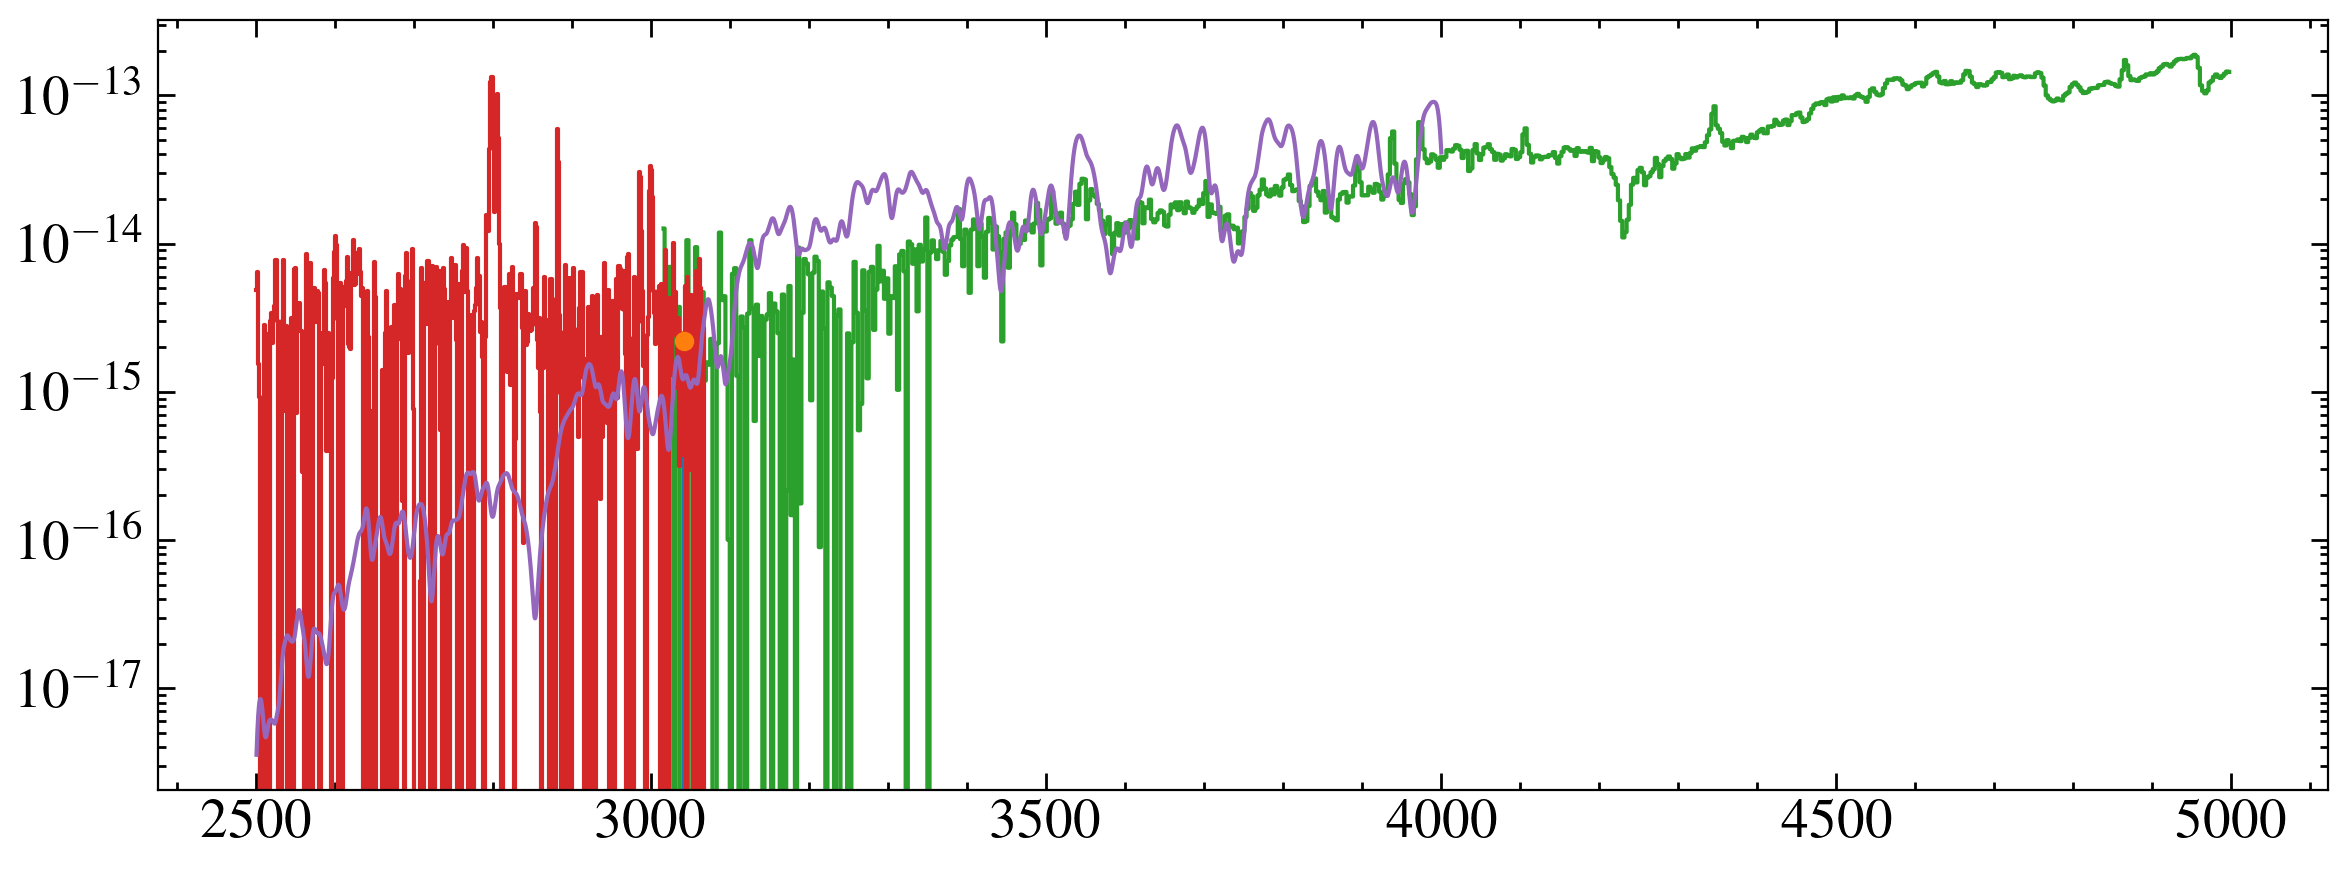

GJ849


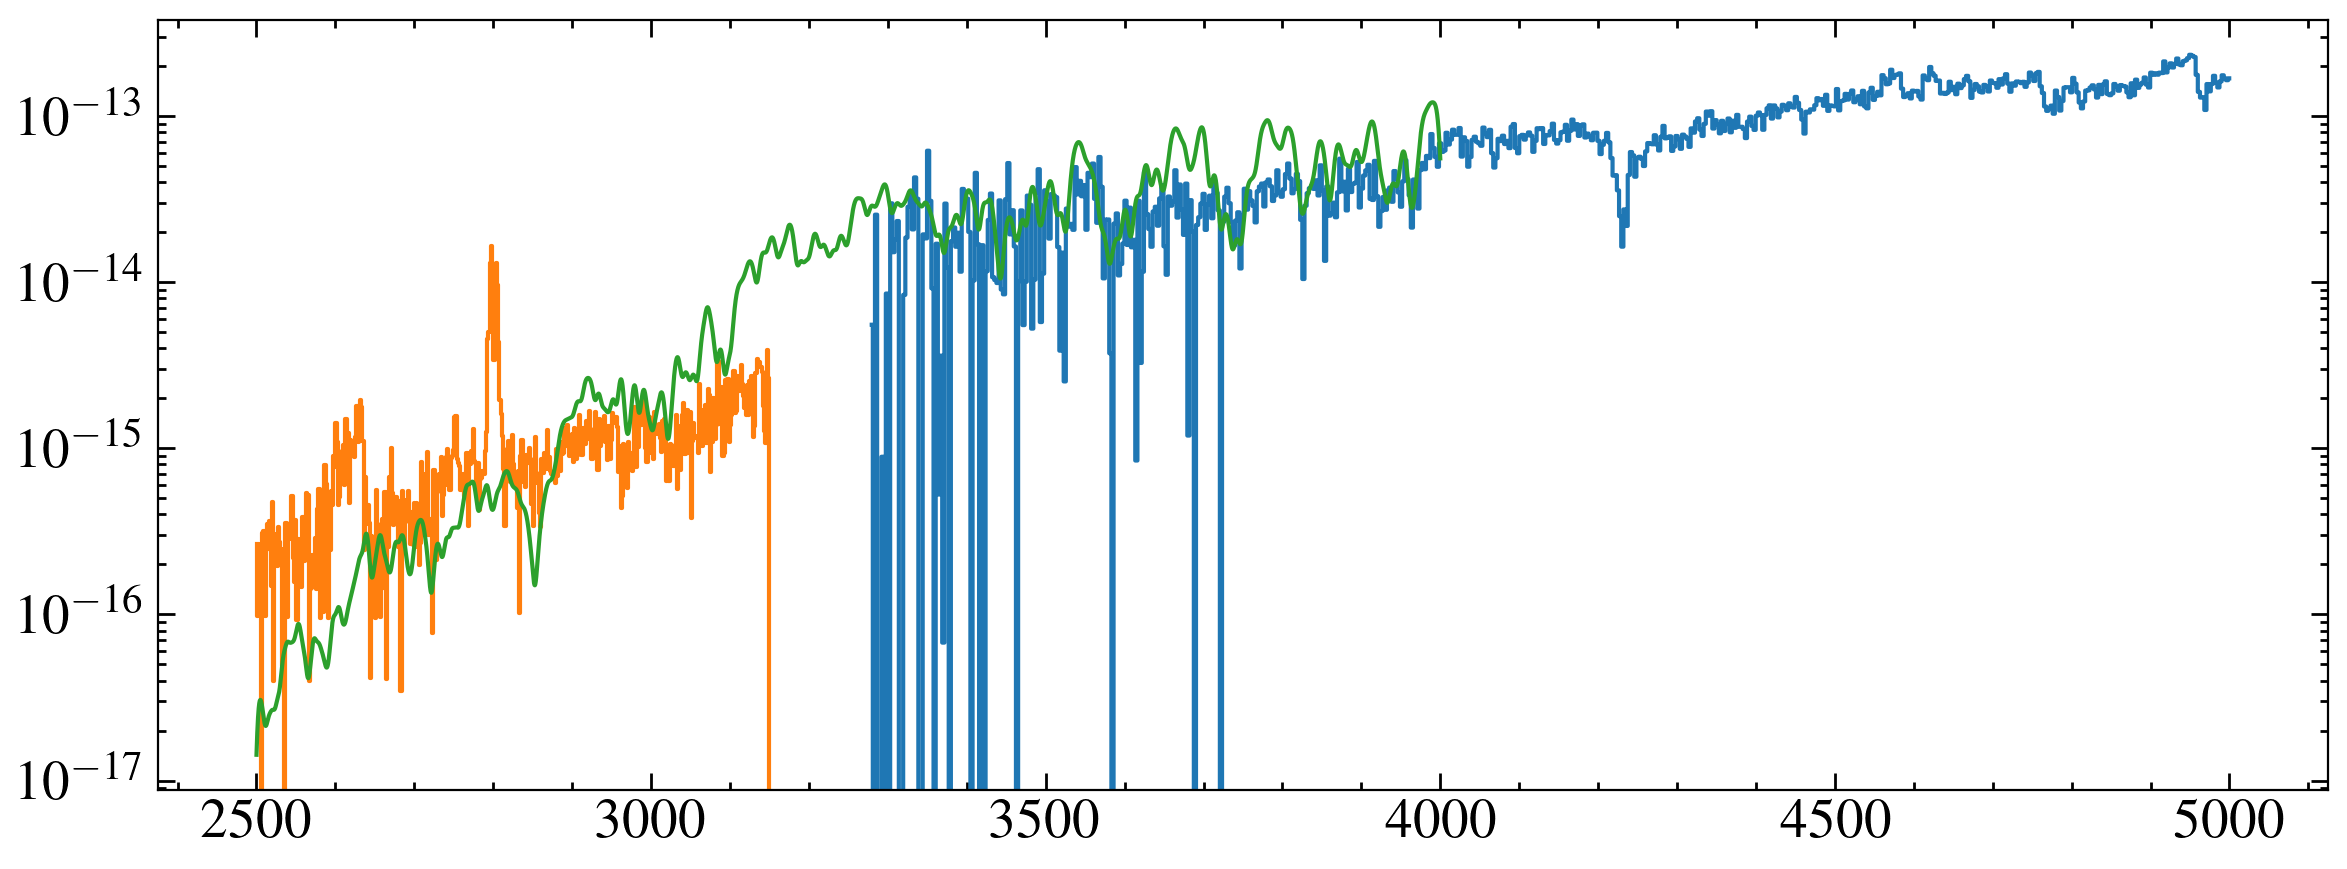

L-980-5


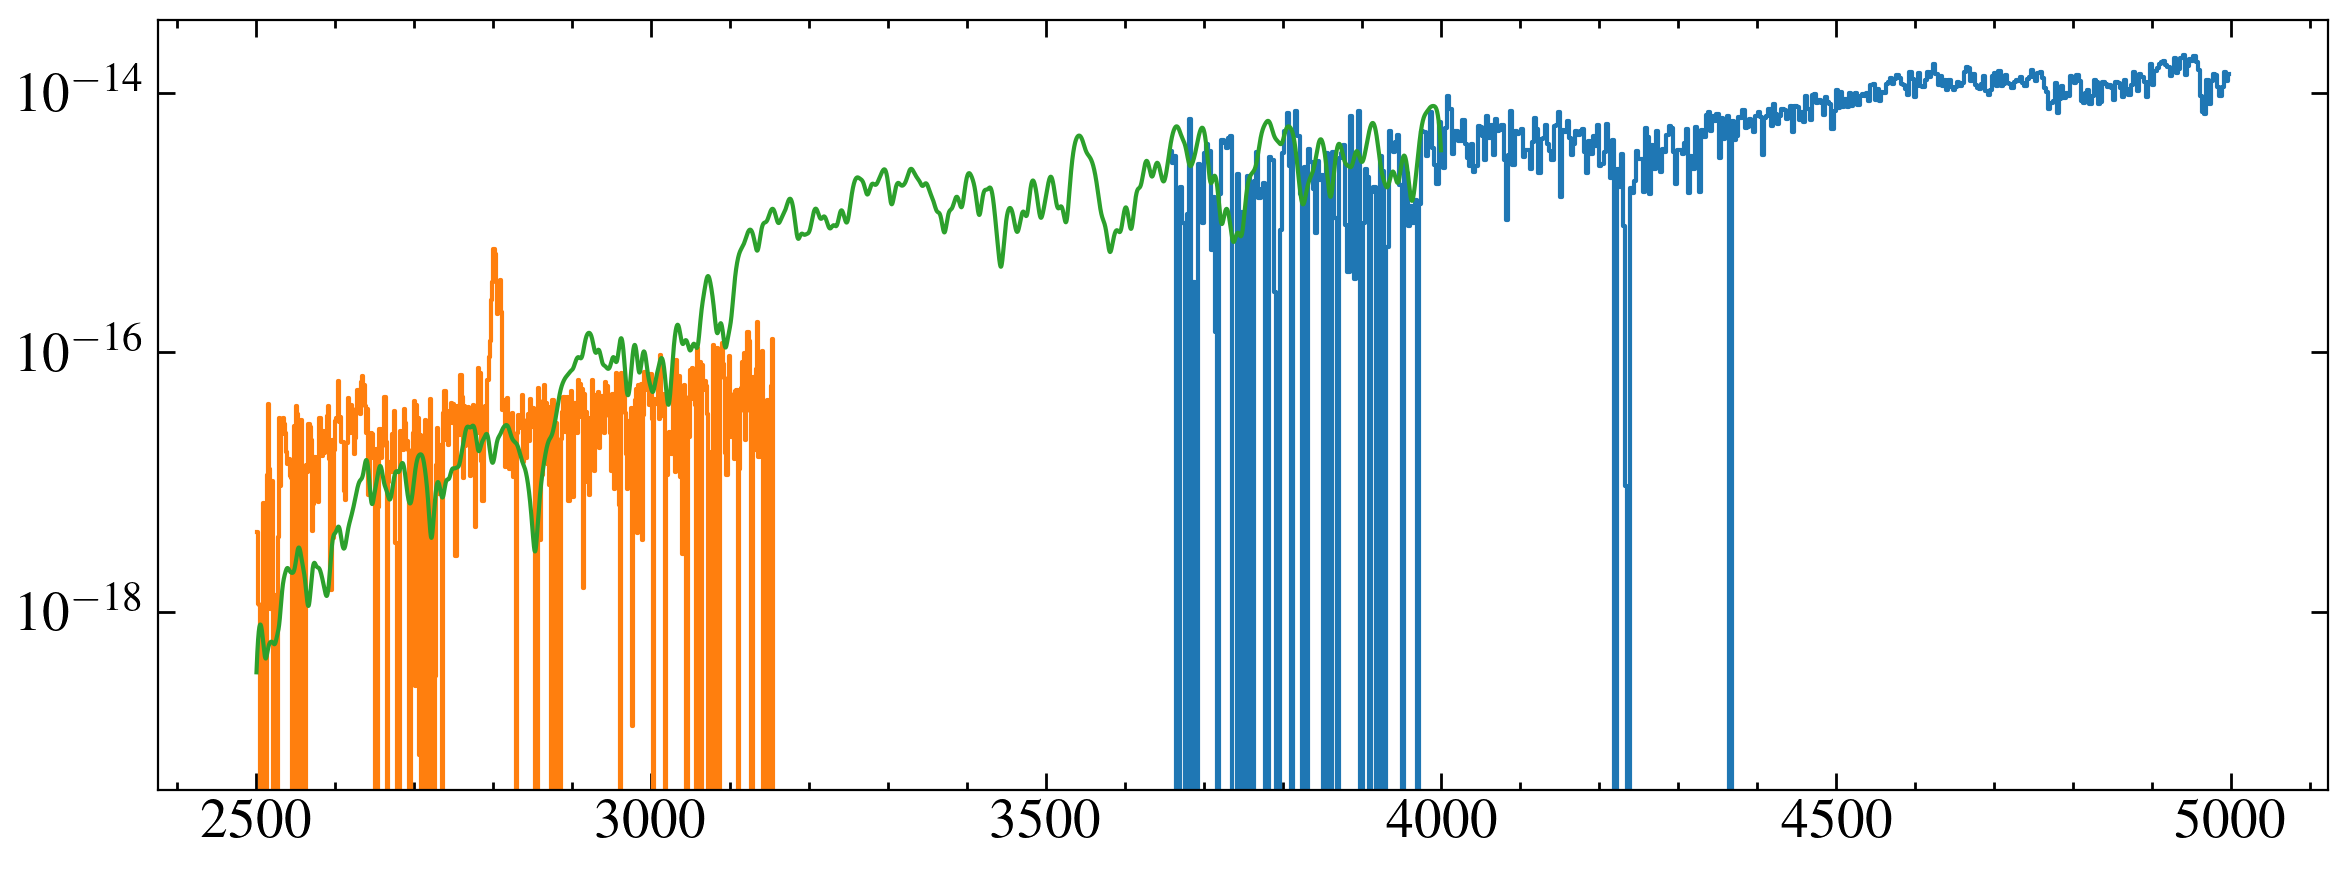

LHS-2686


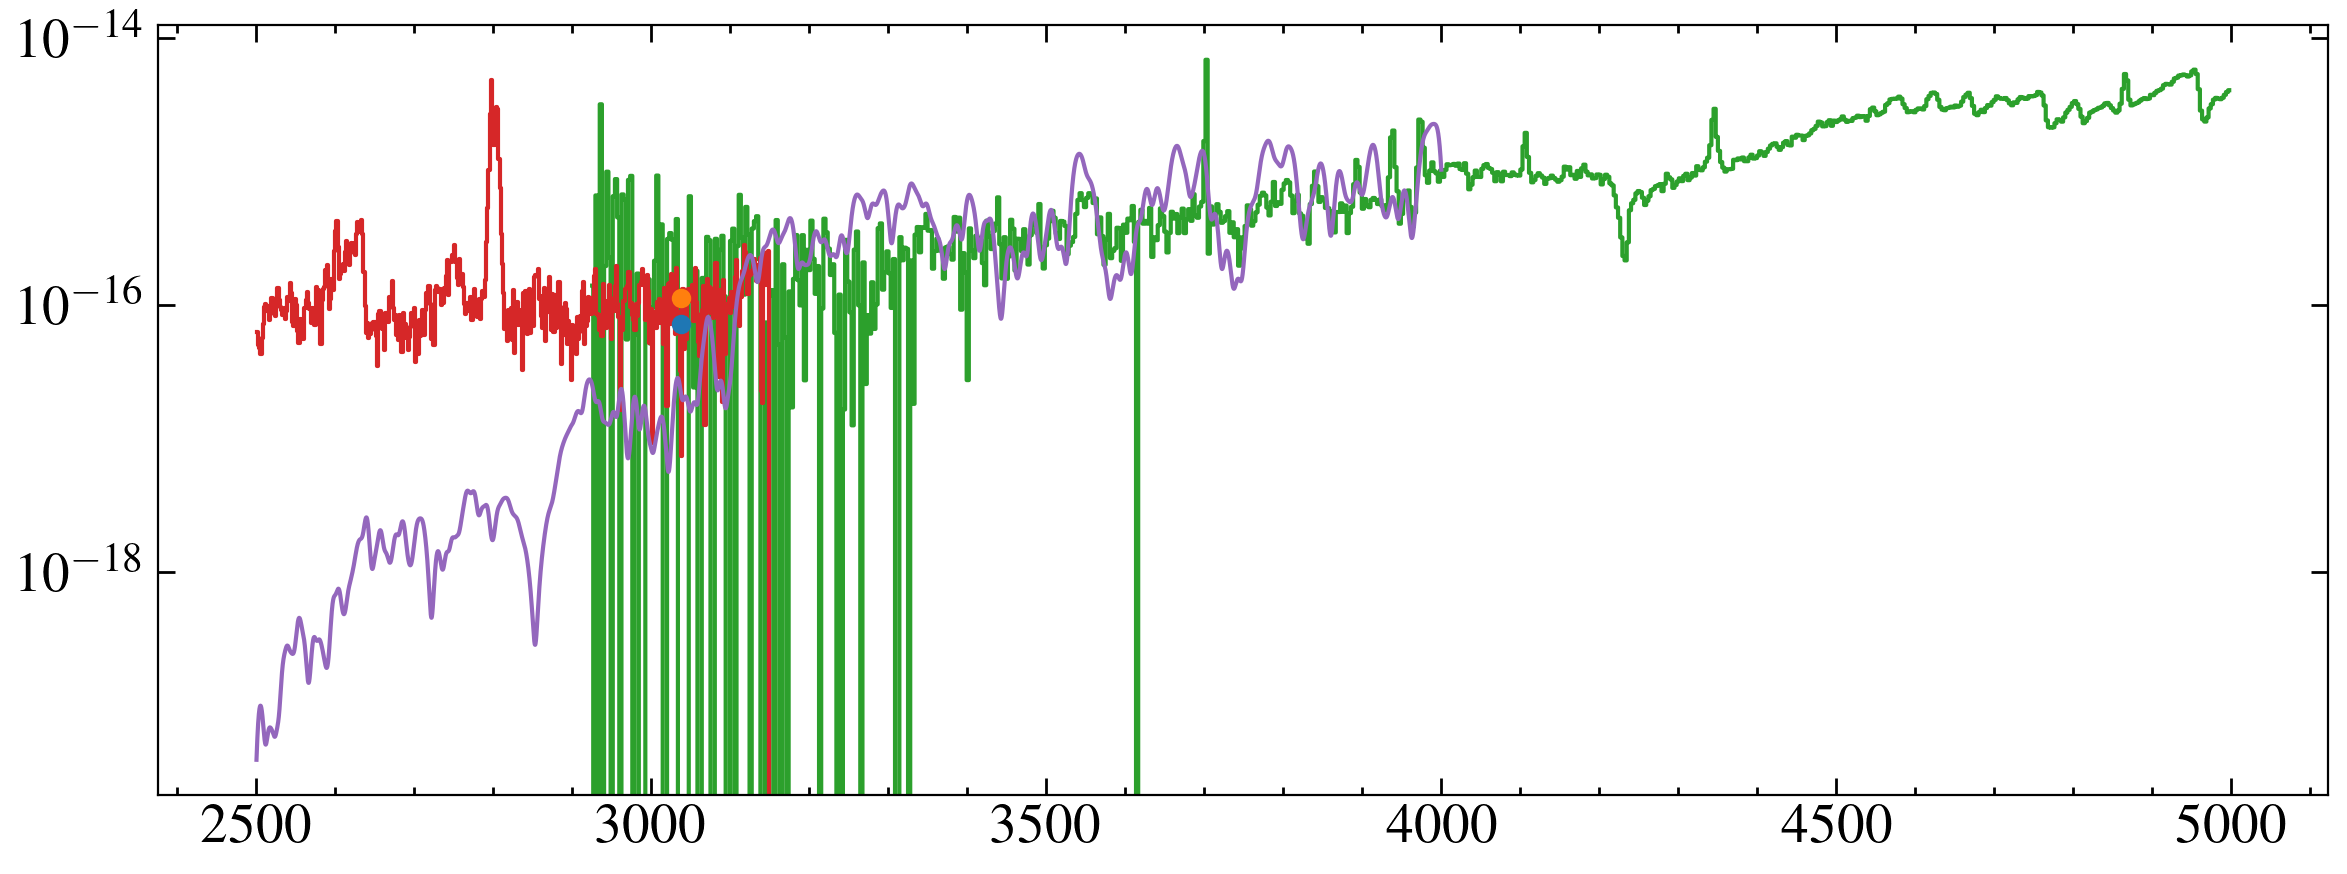

In [14]:
for star in stars[:-1]:

    print(star)
    # fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    # if len(fuv) == 0:
    # fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    # if len(fuv) == 0:
        # continue
    nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    opt = glob.glob('{}{}/*g430l*'.format(path, star))
    odata = fits.getdata(opt[0], 1)
    ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
    
    bin_width = 30
    # w, f, e = g430l['WAVELENGTH'], g430l['FLUX'], g430l['ERROR']
    sn = np.array([np.mean(of[i:i+bin_width]/oe[i:i+bin_width]) for i in range(len(ow[:-bin_width]))])
    start = ow[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (ow > start) & (ow < 5000)
    # mask =  (ow < 4000)
    ow, of, oe = ow[mask], of[mask], oe[mask]
    
  
    
    ndata = fits.getdata(nuv[0], 1)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    
    if nw[-1] > ow[0]:
        band = [ow[0], nw[-1]]
        bp = band[1] - band[0]

        w0, w1 = wavelength_edges(ow) 
        mask  = (ow > band[0]) & (ow < band[1]) #& (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], of[mask], oe[mask]
        ofi = np.sum(f*(w1-w0)) / bp
        oei = ((np.sum(e**2 * (w1-w0)**2))**0.5 )/bp

        plt.errorbar(np.mean(band), ofi, yerr=oei, marker='o')

        w0, w1 = wavelength_edges(nw) 
        mask  = (nw > band[0]) & (nw < band[1]) #& (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], nf[mask], ne[mask]
        nfi = np.sum(f*(w1-w0)) /bp
        nei = ((np.sum(e**2 * (w1-w0)**2))**0.5 ) /bp

        plt.errorbar(np.mean(band), nfi, yerr=nei, marker='o')

#     lap = [1600, 1750]
#     fmask = (fw > lap[0]) & (fw < lap[1])
#     fw, ff, fe = fw[fmask], ff[fmask], fe[fmask]
    
    nmask = (nw > 2500) #& (nw < lap[1])
    nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
    
    plt.step(ow, of, where='mid')
    plt.step(nw, nf, where='mid')
    
    phx = glob.glob('{}{}/*phx*'.format(path, star))
    pdata = fits.getdata(phx[0], 1)
    pw, pf = pdata['WAVELENGTH'], pdata['FLUX']
    
    pmask = (pw > 2500) & (pw < 4000)
    pw, pf = pw[pmask], pf[pmask]
    pf *= fits.getheader(phx[0], 0)['NORMFAC']
    
    pw, pf = smear(pw, pf, 1000)
    
    plt.plot(pw, pf)
    
    plt.yscale('log')

    
#     lines =[1630, 1680]
#     nlinemask = (nw > lines[0]) & (nw < lines[1])
#     nint = np.trapz(nf[nlinemask], nw[nlinemask])

#     flinemask = (fw > lines[0]) & (fw < lines[1])
#     fint = np.trapz(ff[flinemask], fw[flinemask])

#     print(nint, fint, nint/fint)
    
#     scale = nint/fint
    
#     plt.plot(fw, ff*scale, ls='--', alpha=0.5)

    
    plt.show()


Might have to admit defeat. At GJ 15A and LHS 2686 thee is reasonalble overap and they are in good agreement. No scaling needed? Check the FUV overlap with COS. How many G140M have NV and SIII

GJ1132
1206.499 6.938782884497318e-17 1.6724303361398554e-16 0.4148921921921577
1238.821 8.109003254026765e-17 8.679547796998387e-17 0.934265637298647
1242.804 4.744109007727847e-17 1.3221483130680893e-17 3.5881821735407153


/tmp/ipykernel_101192/374552733.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


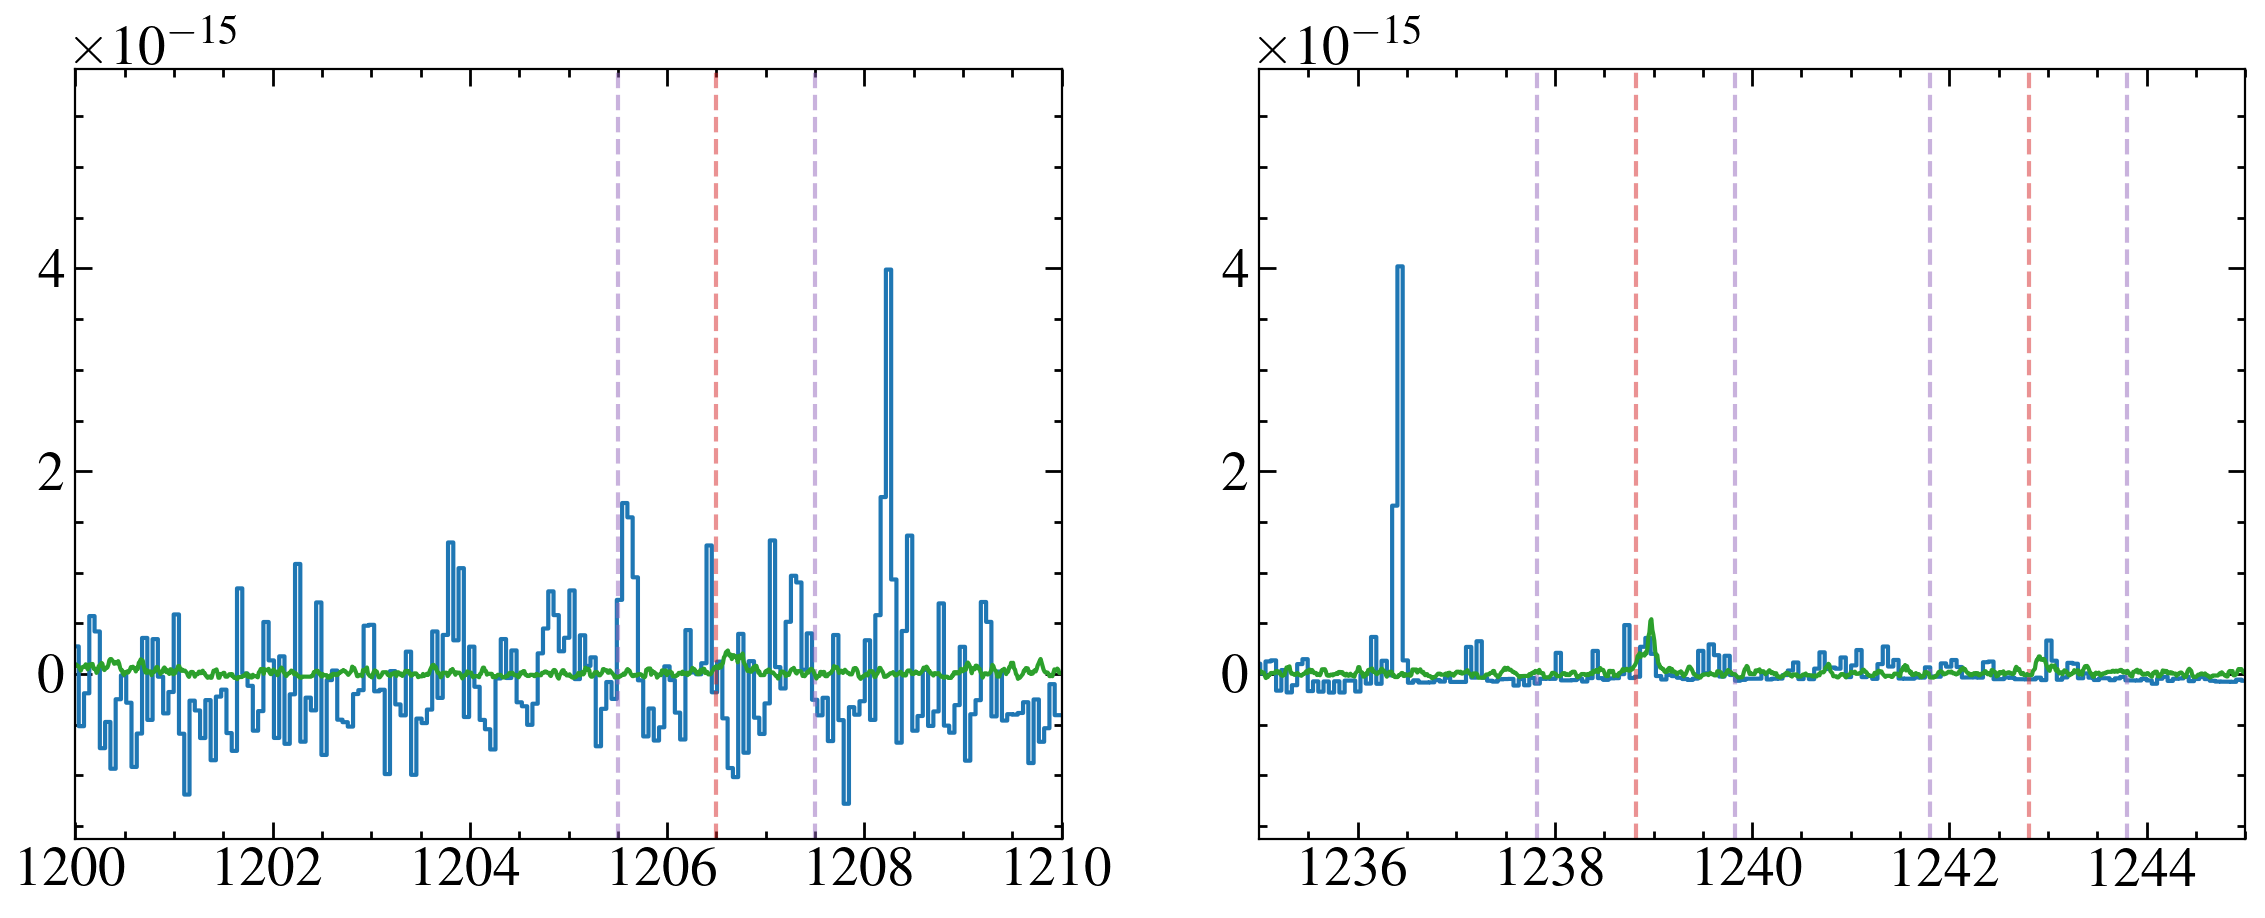

GJ15A
GJ163
1206.499 1.7460647579889217e-16 5.105647155376911e-16 0.3419869616626539
1238.821 1.2370717458753481e-16 8.785965902953603e-16 0.1408008817174533
1242.804 6.106317905405349e-17 -2.640262109577134e-17 -2.3127695857375845


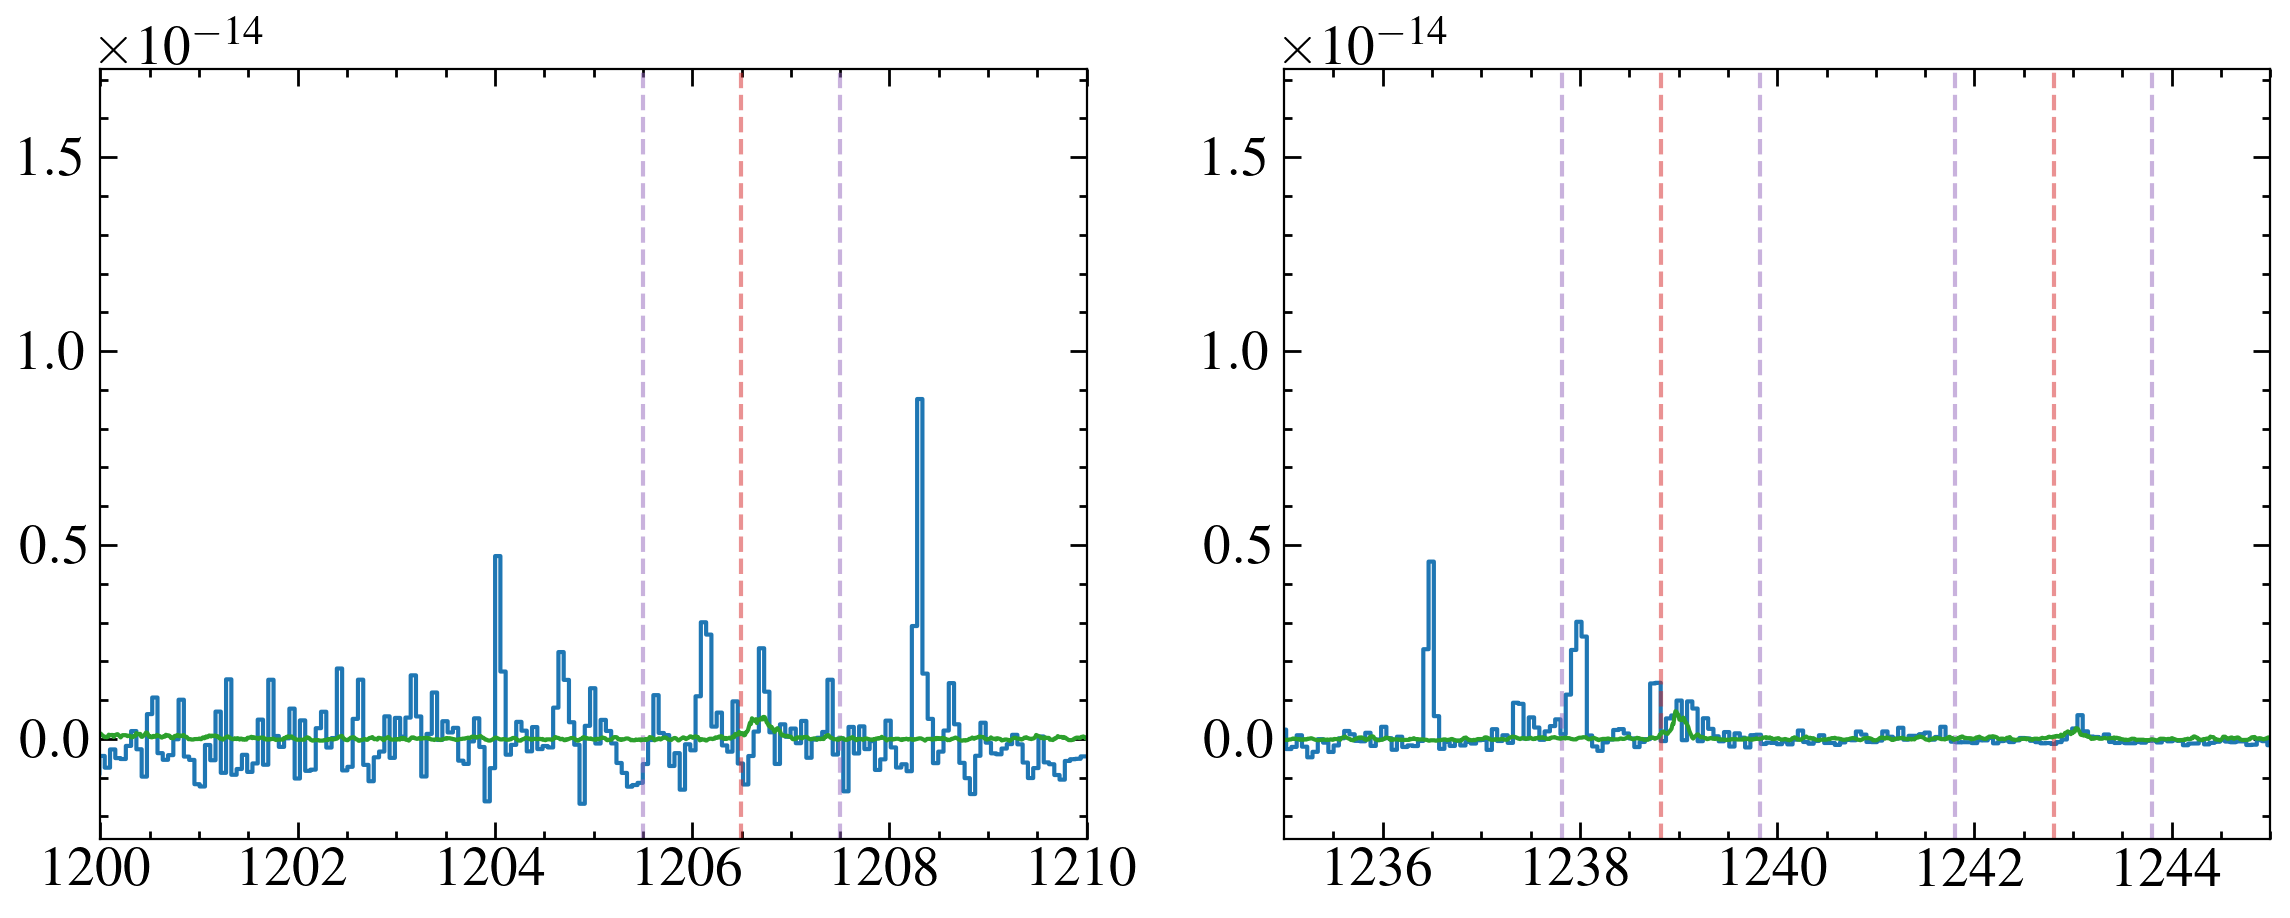

GJ649
1206.499 2.119229194201727e-15 1.0055564813095235e-15 2.1075188053503284
1238.821 1.8860884724530104e-15 1.0414315592798197e-15 1.8110536939722623
1242.804 9.932172658172606e-16 5.406989731996339e-16 1.8369135416326199


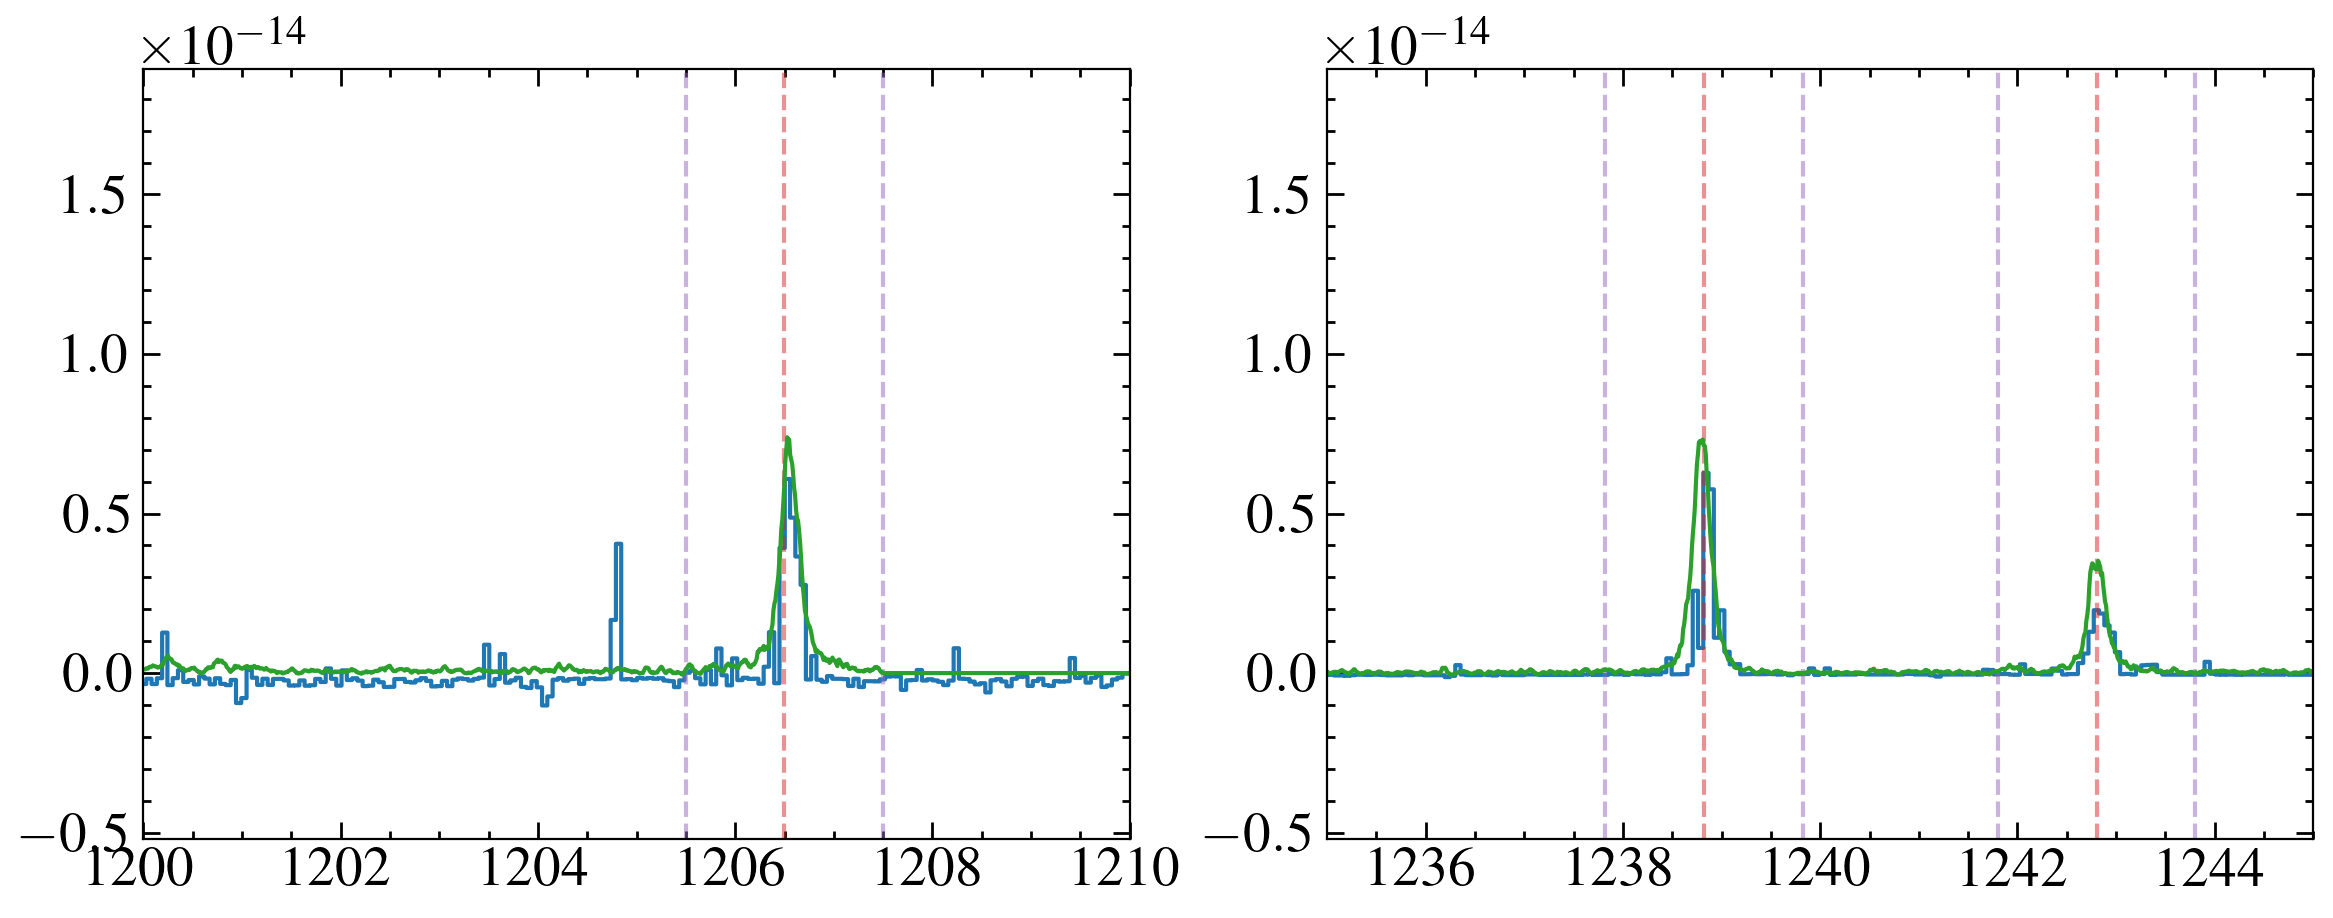

GJ674
1206.499 1.1274790316390783e-14 8.179693972993465e-15 1.3783877922103518
1238.821 9.279183616231212e-15 7.71311090529949e-15 1.2030403465164377
1242.804 5.127680084830951e-15 4.557641134560543e-15 1.1250732414949935


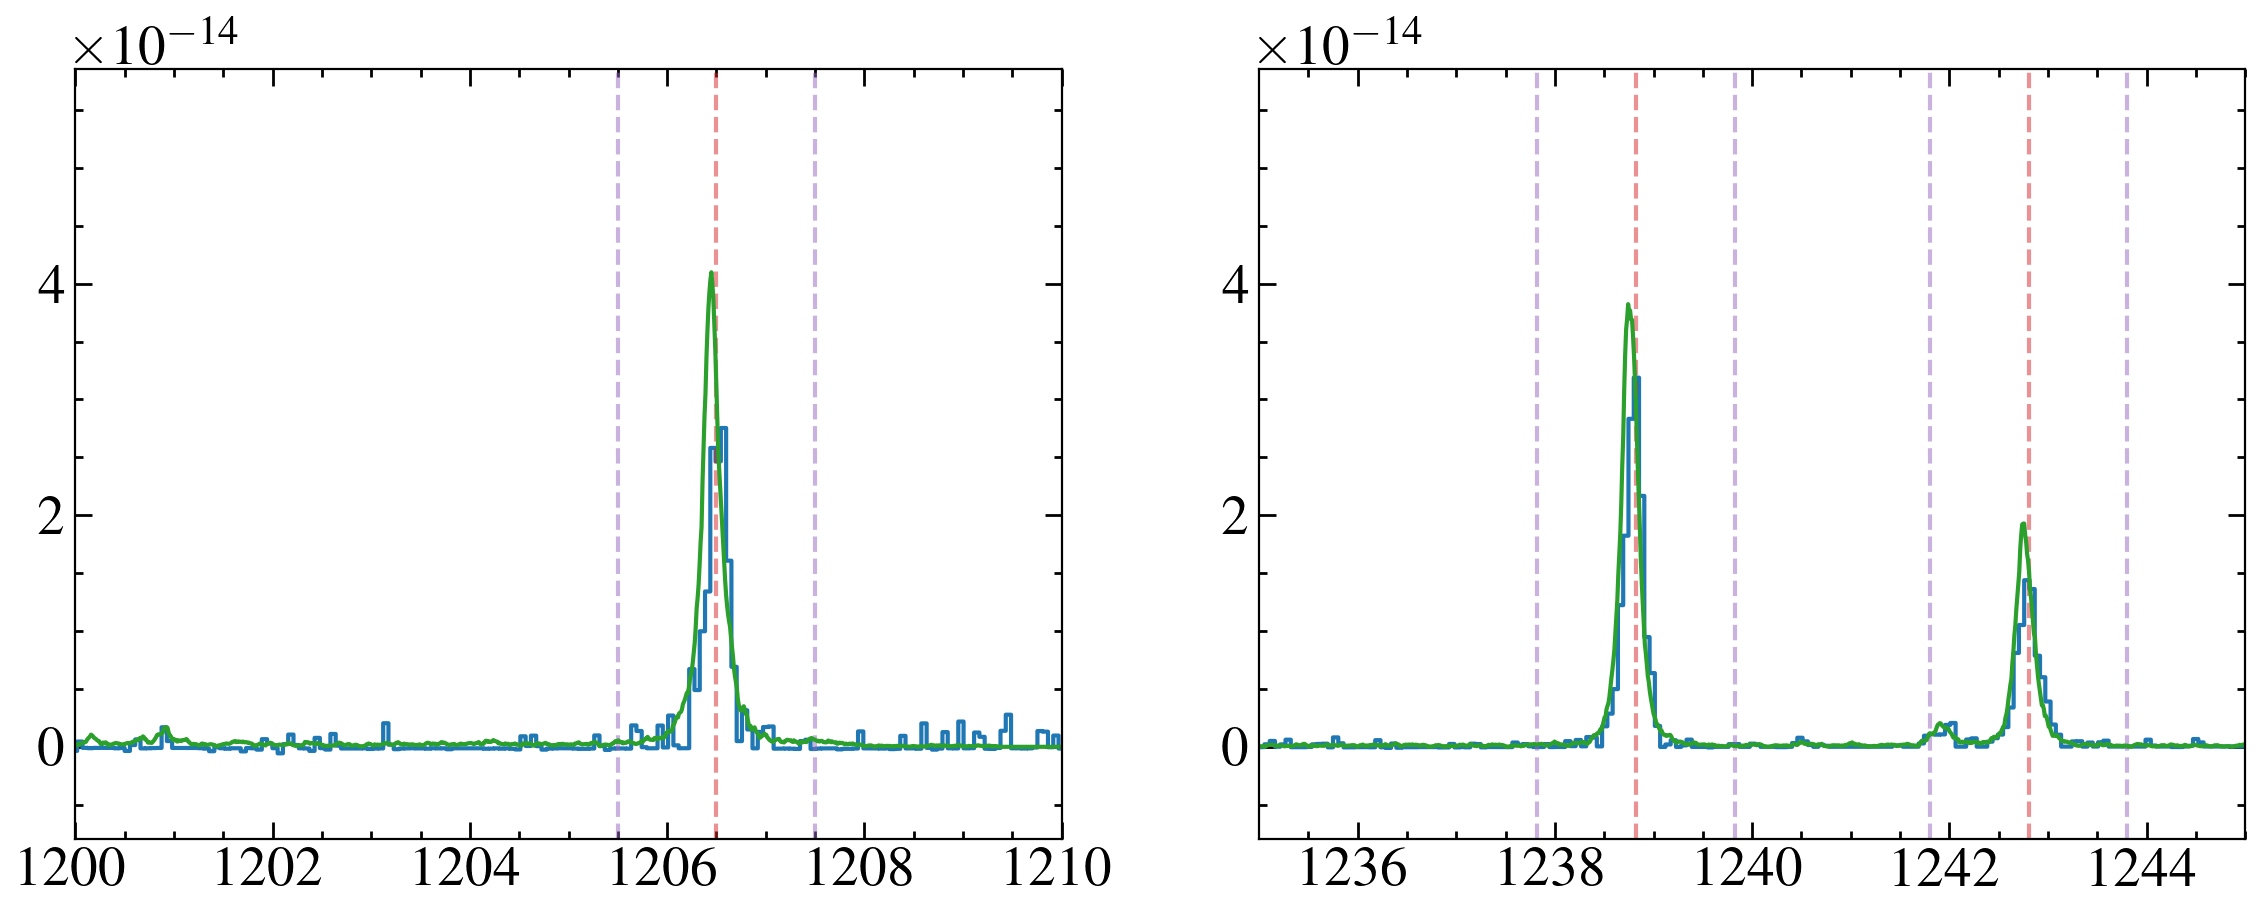

GJ676A
1206.499 2.271628034756737e-15 3.3773459520282015e-15 0.6726074459125378
1238.821 3.661967777293535e-15 3.4957370995103296e-15 1.0475523968339868
1242.804 1.8967280539439297e-15 1.4833673395125685e-15 1.2786637560506022


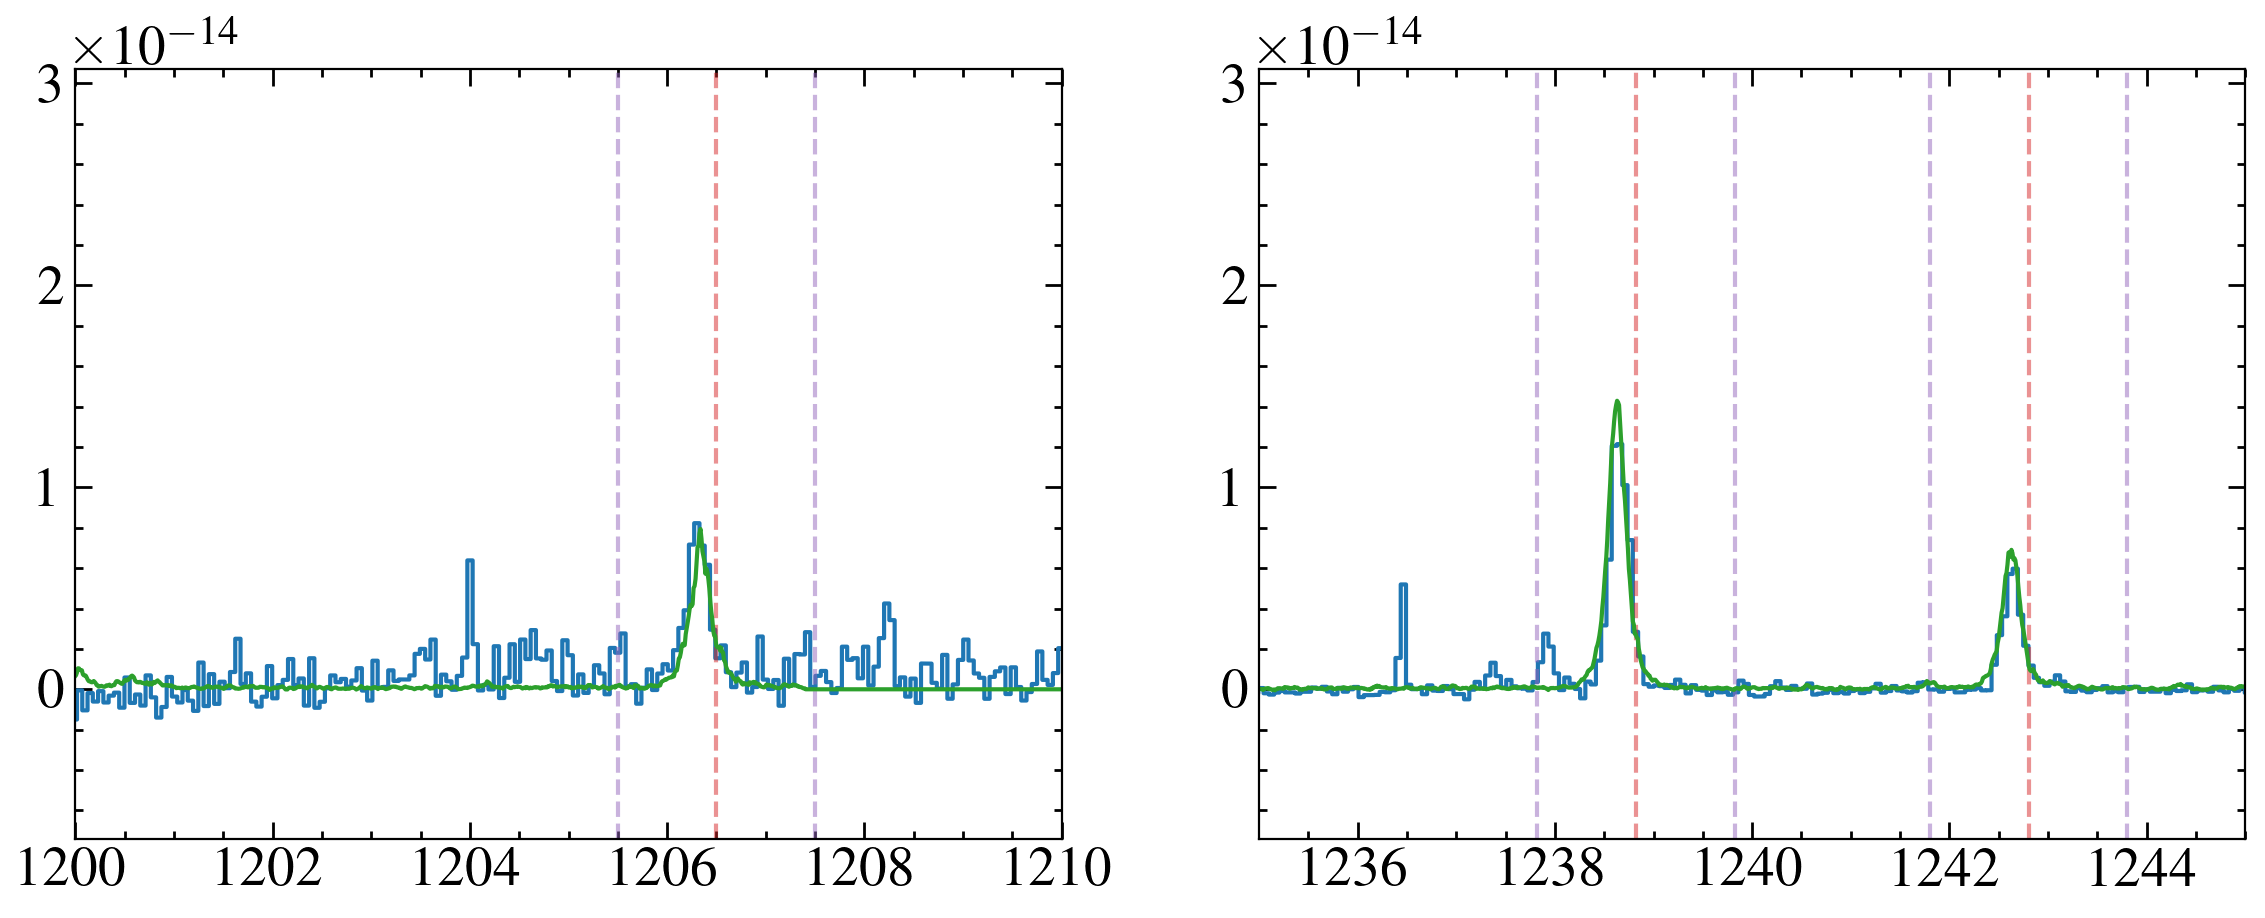

GJ699
1206.499 5.616016123909912e-16 2.3598746836558837e-15 0.23797942165342698
1238.821 1.5138750886709646e-15 -3.865720755901525e-18 -391.6152211356285
1242.804 7.83626543429769e-16 -3.371557789837006e-17 -23.2422693685358


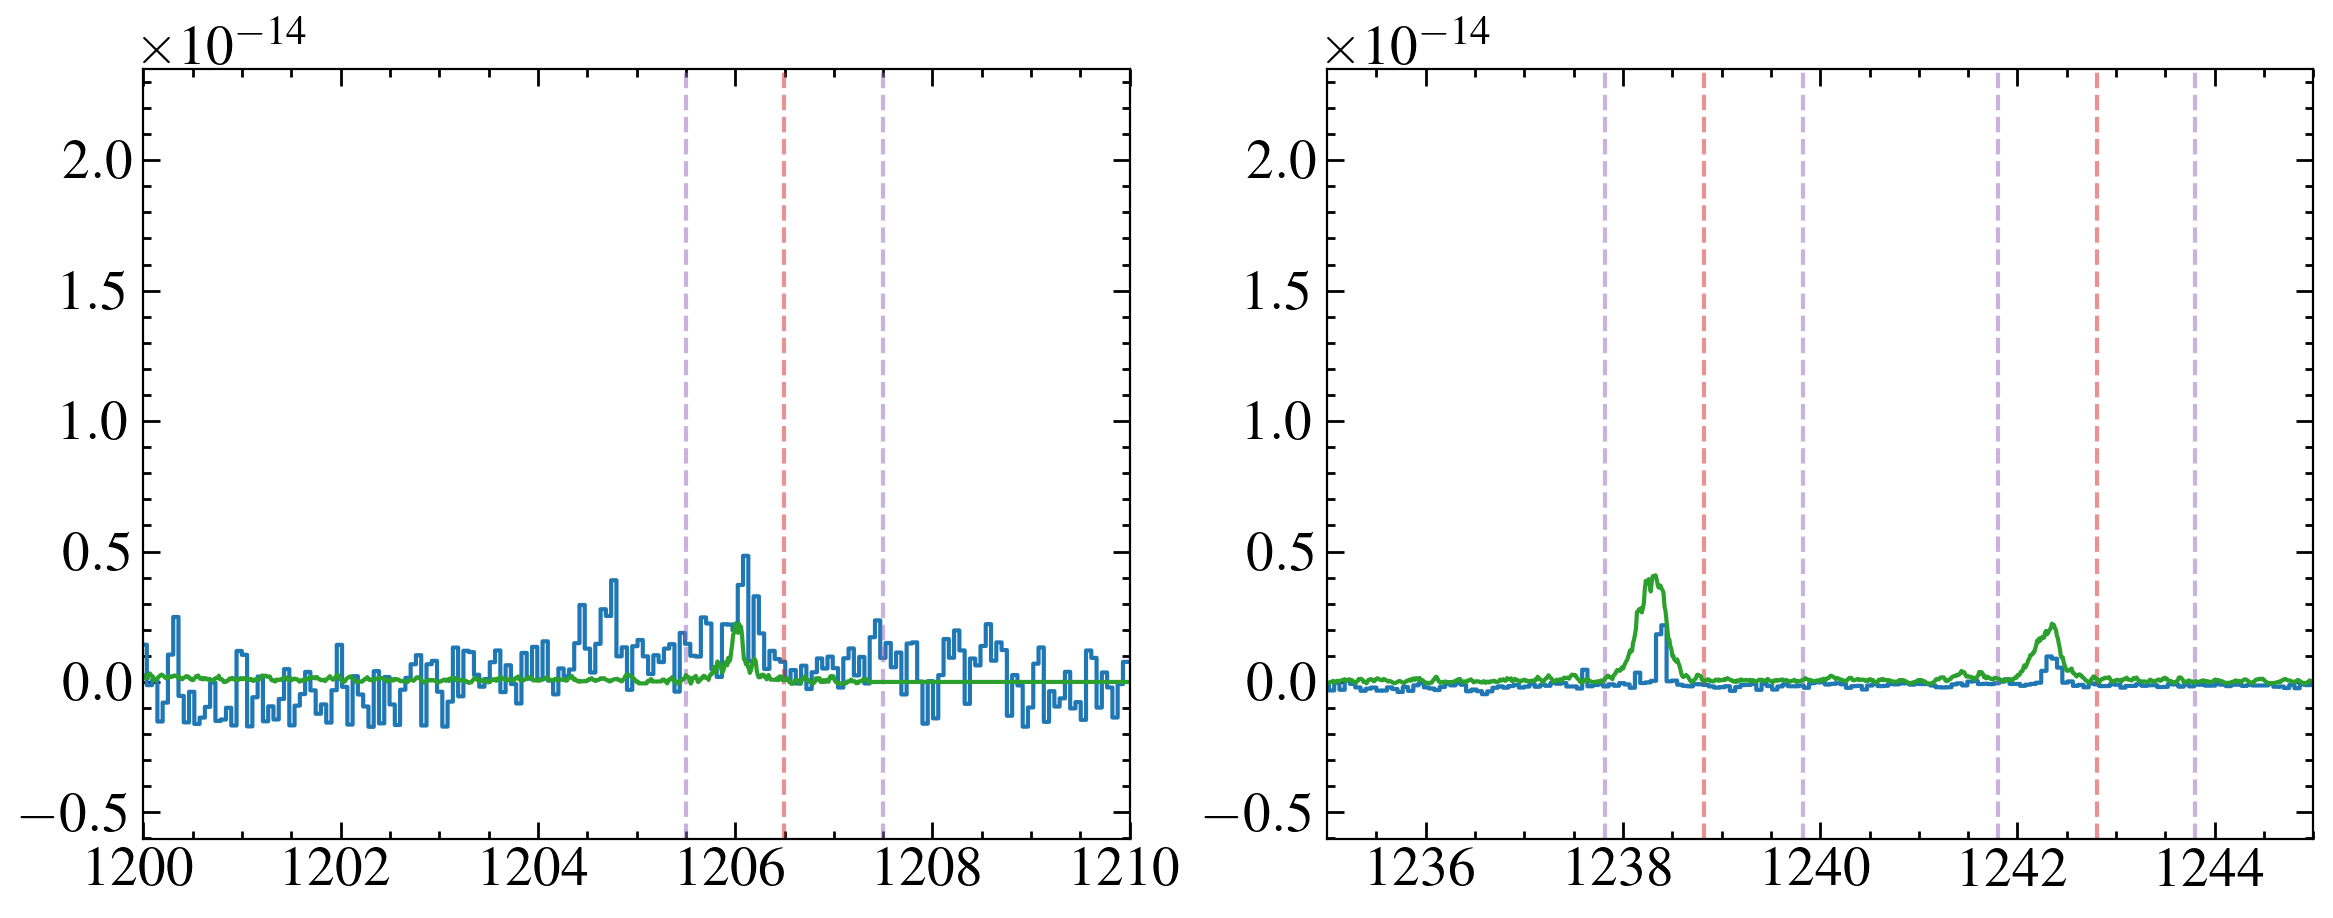

GJ729
GJ849
1206.499 2.280093945768607e-15 3.55230371545761e-15 0.6418634577462878
1238.821 3.106617591761363e-15 4.462361963441535e-15 0.6961823395799626
1242.804 1.6296449606170976e-15 2.5360226035706488e-15 0.6425987522045754


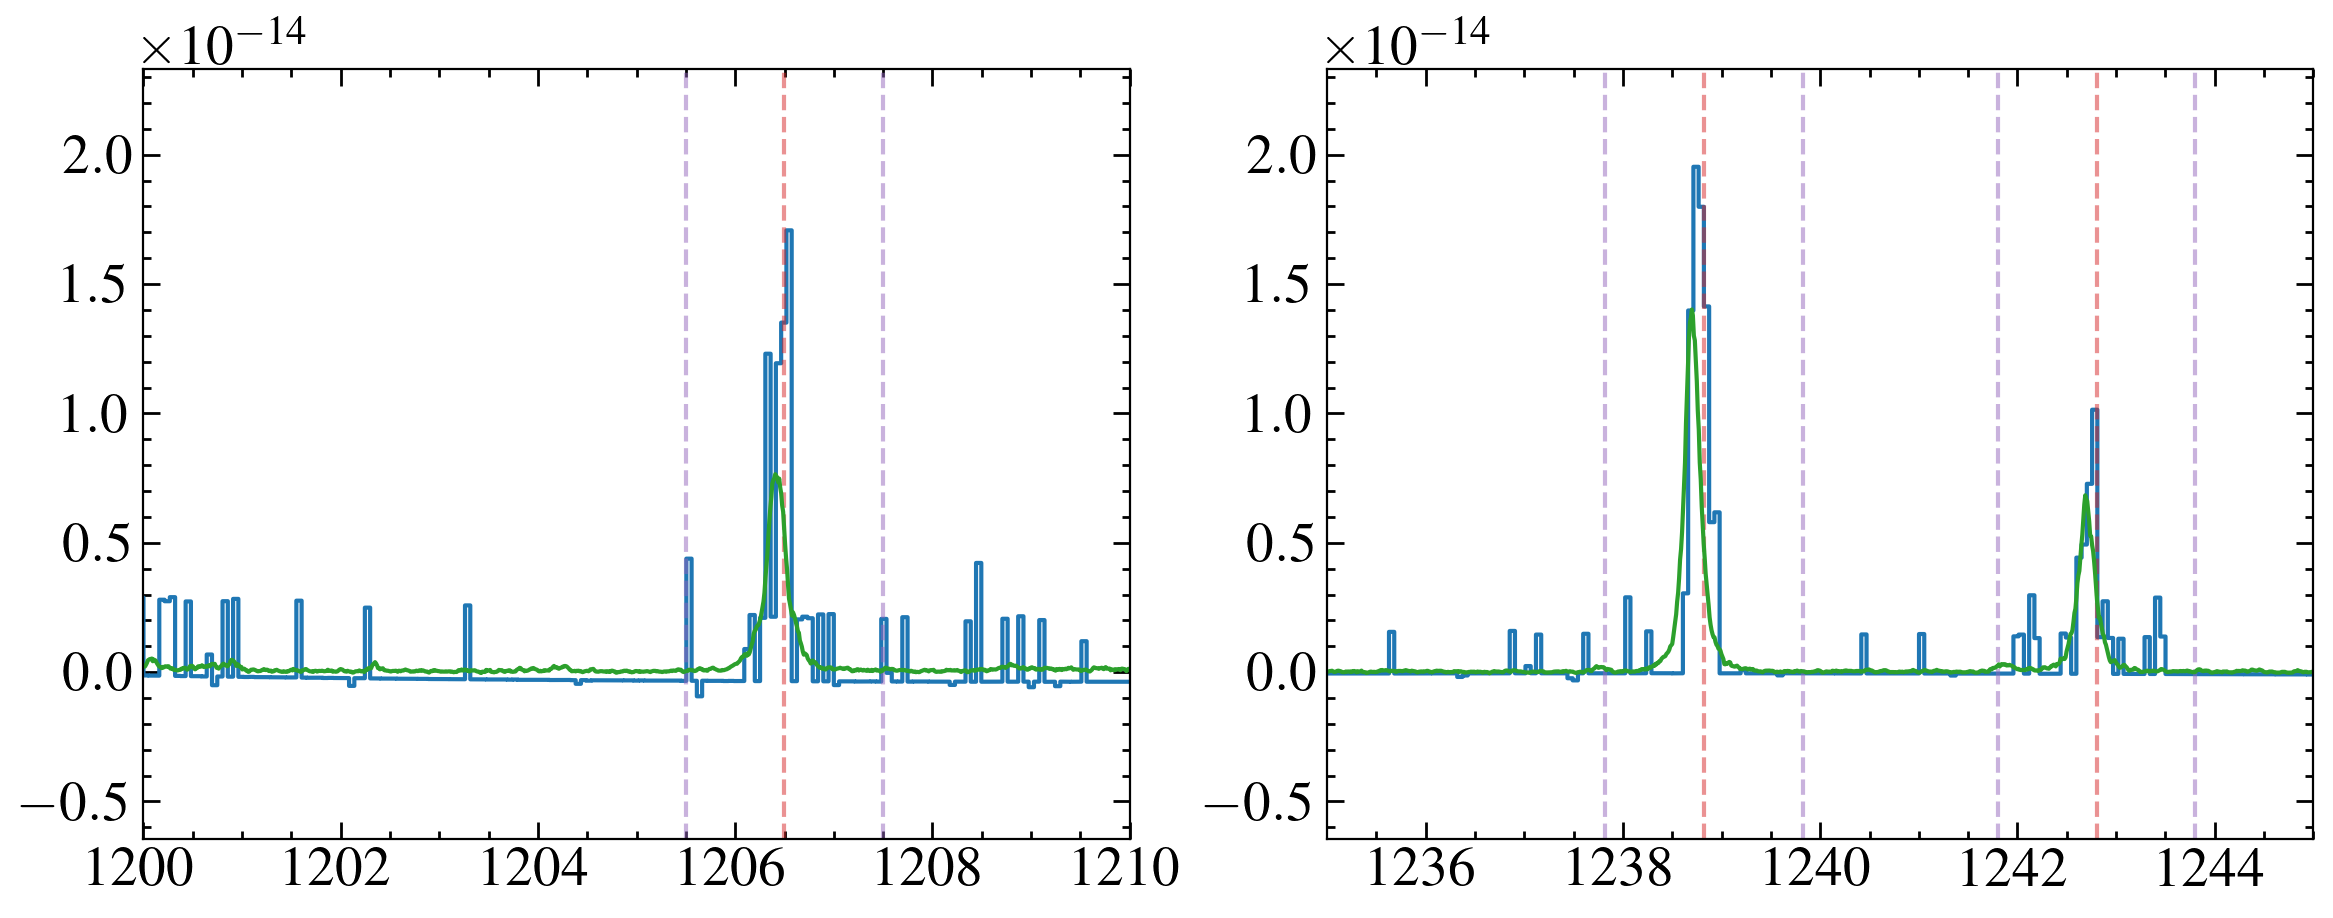

L-980-5
1206.499 2.253705036755443e-16 1.5675684303116902e-15 0.14377075942434767
1238.821 1.5623759717569503e-16 2.9134858910311756e-18 53.625657723846935
1242.804 8.722766783584204e-17 -5.654700649844775e-18 -15.425691515294712


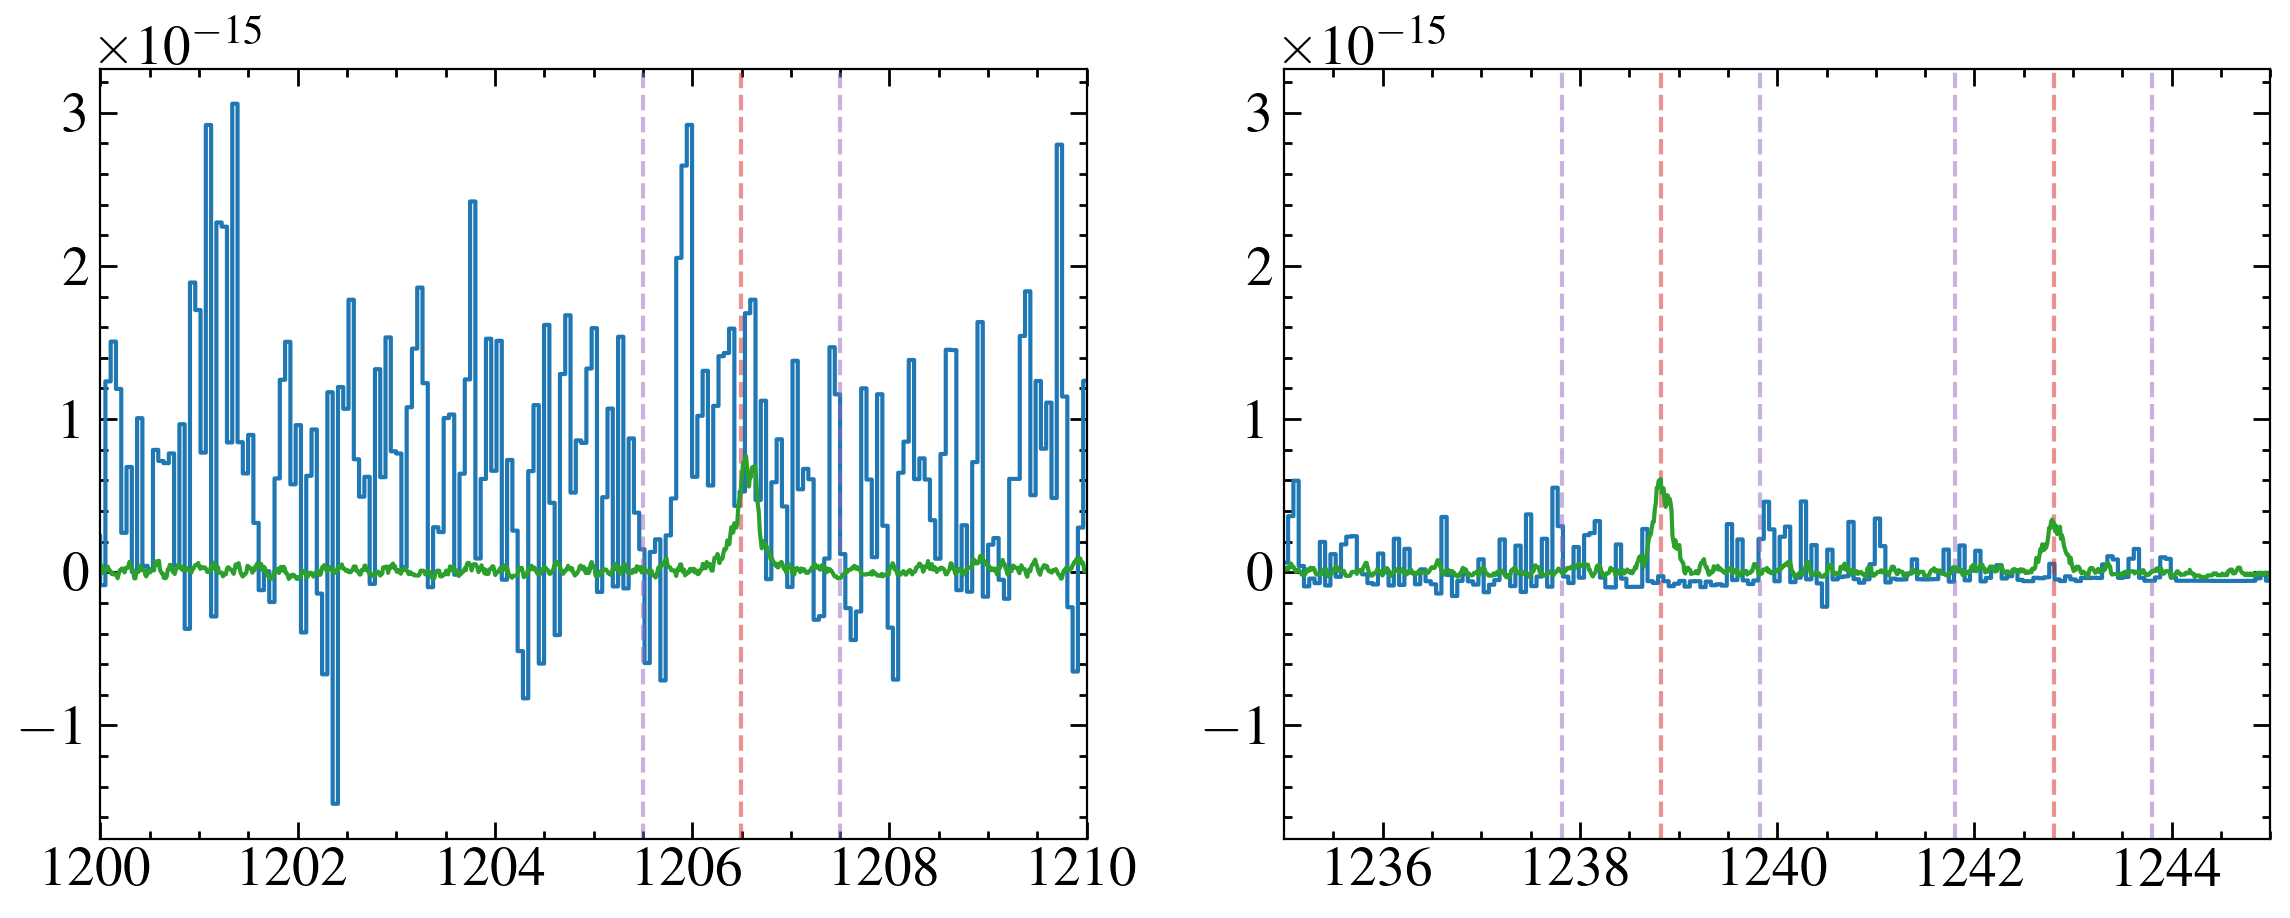

LHS-2686
1206.499 1.1636501651298294e-15 7.825094876965014e-16 1.4870748322238294
1238.821 1.7345784598724538e-15 1.003079208946723e-15 1.729253726327193
1242.804 9.01502641262521e-16 4.679660618591207e-16 1.926427394501772


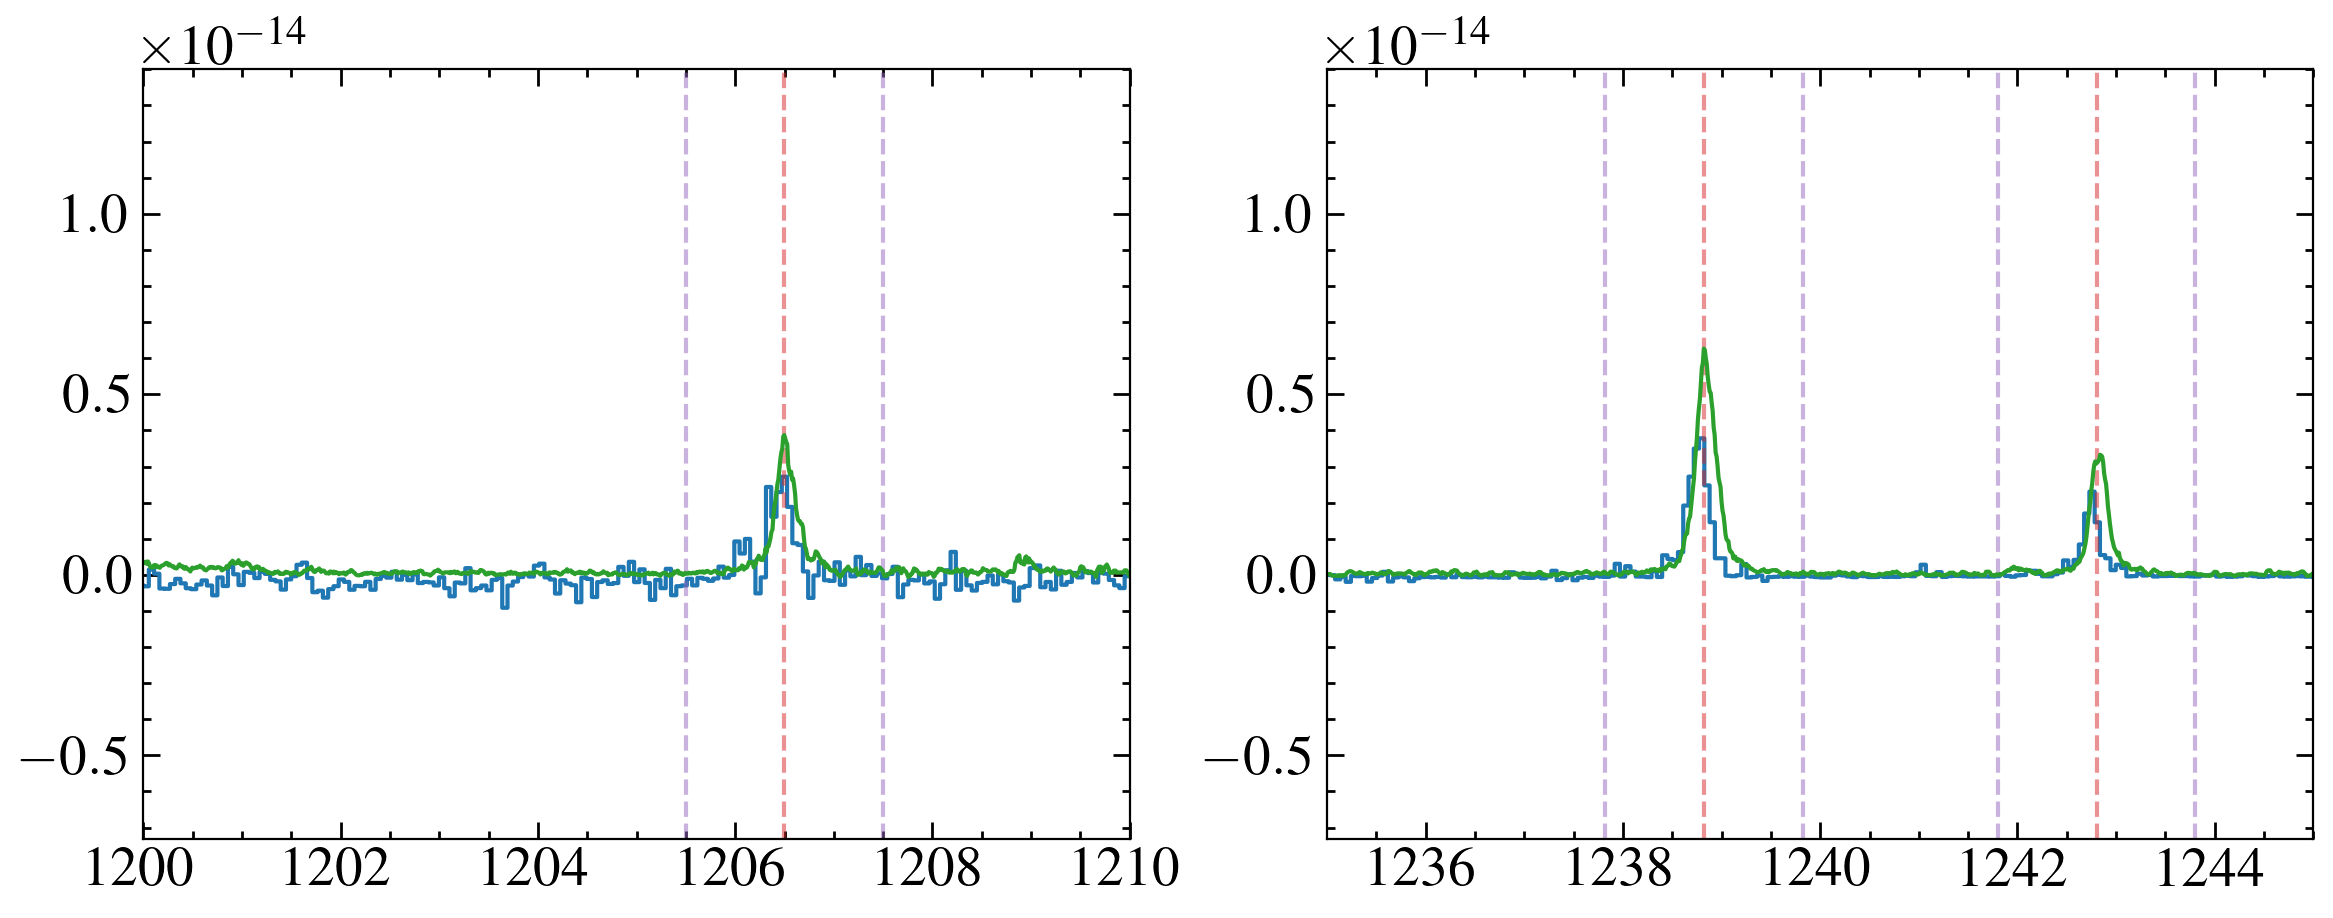

In [23]:
lines = [1206.499, 1238.821,1242.804]
for star in stars[:-1]:
    print(star)
    fuv = glob.glob('{}{}/*g140m*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    mask = (fw < 1210) | (fw > 1220) #mask lya
    
    fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    # plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    cos = glob.glob('{}{}/*g130m*'.format(path, star))
    if len(cos) > 0:
        smooth=5
        cdata = fits.getdata(cos[0], 1)
        cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
        
        if star == 'GJ699':
            sav = '../gj_699/COS/GJ699_quiesc_G130M_Mm1_NOSCL_24may2019.sav'
            cdata = readsav(sav)
            cw, cf, ce = cdata['wave'], cdata['flux'], cdata['err']
            
        if star == 'GJ674':
            spec = '../../stars/gj674_flare/gj674_flare_spectra/gj674_cos_preflare.csv'
            cdata = Table.read(spec)
            cw, cf, ce = cdata['wavelength'], cdata['flux'], cdata['error']
        
        
        
        
        mask = (cw < 1210) | (cw > 1220) #mask lya
        cw, cf, ce = cw[mask], cf[mask], ce[mask]
        cf = convolve(cf,Box1DKernel(smooth))
        ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
        
        
   
        # plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
        
    plt.subplot(121)
    
    plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    [plt.axvline(line+1, ls='--', c='C4', alpha=0.5) for line in lines]
    [plt.axvline(line-1, ls='--', c='C4', alpha=0.5) for line in lines]
    
    plt.plot(cw, cf,  c='C2')#, zorder=-10)

        
    plt.xlim(1200, 1210)
    
    
    plt.subplot(122)
    
    plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    [plt.axvline(line+1, ls='--', c='C4', alpha=0.5) for line in lines]
    [plt.axvline(line-1, ls='--', c='C4', alpha=0.5) for line in lines]
    
    
    plt.plot(cw, cf, c='C2')#, zorder=-10)

        
    plt.xlim(1235, 1245)
    
    
    for line in lines:
        clmask = (cw > line -1) & (cw < line +1)
        flmask = (fw > line -1) & (fw < line +1)
        cint = np.trapz(cf[clmask], cw[clmask])
        fint = np.trapz(ff[flmask], fw[flmask])
        
        print(line, cint, fint, cint/fint)
    
    
    plt.show()

ugrh flares. Flare in LHS 2886?

In [ ]:
spec = Table.read('../lya/coadds/LHS-2686_g140m_coadd_v1.ecsv')
w,f, e = spec['WAVELENGTH'], spec['FLUX'], spec['ERROR']
plt.plot(w,f)
plt.step(fw, ff, where='mid')

Uh-oh, did I not include the re-extracted spectra? I did not, need to fix!!! Checking COS v G140L first though

In [24]:
# rstars = ['GJ1132' ,'GJ163', 'GJ849', 'LHS-2686']
# lines = [1206.499, 1238.821,1242.804]
# for star in rstars:
#     print(star)
#     fuv = glob.glob('{}{}/*g140m*'.format(path, star))
#     # if len(fuv) == 0:
#     #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
#     if len(fuv) == 0:
#         continue
#     # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
#     fdata = fits.getdata(fuv[0], 1)
#     fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
# #     mask = (fw < 1210) | (fw > 1220) #mask lya
    
# #     fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    
    
#     # smooth = 2
#     # ff = convolve(ff,Box1DKernel(smooth))
#     # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
#     plt.step(fw, ff, where='mid')
#     # plt.step(fw, fe, where='mid')
    
   
    
    
#     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
#     coadd = Table.read('../lya/coadds/{}_g140m_coadd_v1.ecsv'.format(star))
#     fw1, ff1, fe1 = coadd['WAVELENGTH'], coadd['FLUX'], coadd['ERROR']
    
# #     mask = (fw1 < 1210) | (fw1 > 1220) #mask lya
    
# #     fw1, ff1, fe1 = fw1[mask], ff1[mask], fe1[mask]
    
#     plt.step(fw1, ff1, where='mid')
    
# #     cos = glob.glob('{}{}/*g130m*'.format(path, star))
# #     if len(cos) > 0:
# #         smooth=5
# #         cdata = fits.getdata(cos[0], 1)
# #         cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
# #         mask = (cw < 1210) | (cw > 1220) #mask lya
# #         cw, cf, ce = cw[mask], cf[mask], ce[mask]
# #         cf = convolve(cf,Box1DKernel(smooth))
# #         ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
# #         # plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
        
#     # plt.subplot(121)
    
# #     plt.step(fw, ff, where='mid')
# #     # plt.step(fw, fe, where='mid')
    
# #     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
# #     plt.plot(cw, cf,  c='C2')#, zorder=-10)

        
# #     plt.xlim(1200, 1210)
    
    
# #     plt.subplot(122)
    
# #     plt.step(fw, ff, where='mid')
# #     # plt.step(fw, fe, where='mid')
    
# #     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
# #     plt.plot(cw, cf, c='C2')#, zorder=-10)

        
# #     plt.xlim(1235, 1245)
    
#     plt.show()

GJ1132
GJ15A
GJ163
GJ649
COS 1.1537550696634855e-14 3.6690945466108857e-16
STIS 1.4843497528108194e-14 3.864608051211732e-16
0.7772797937135048


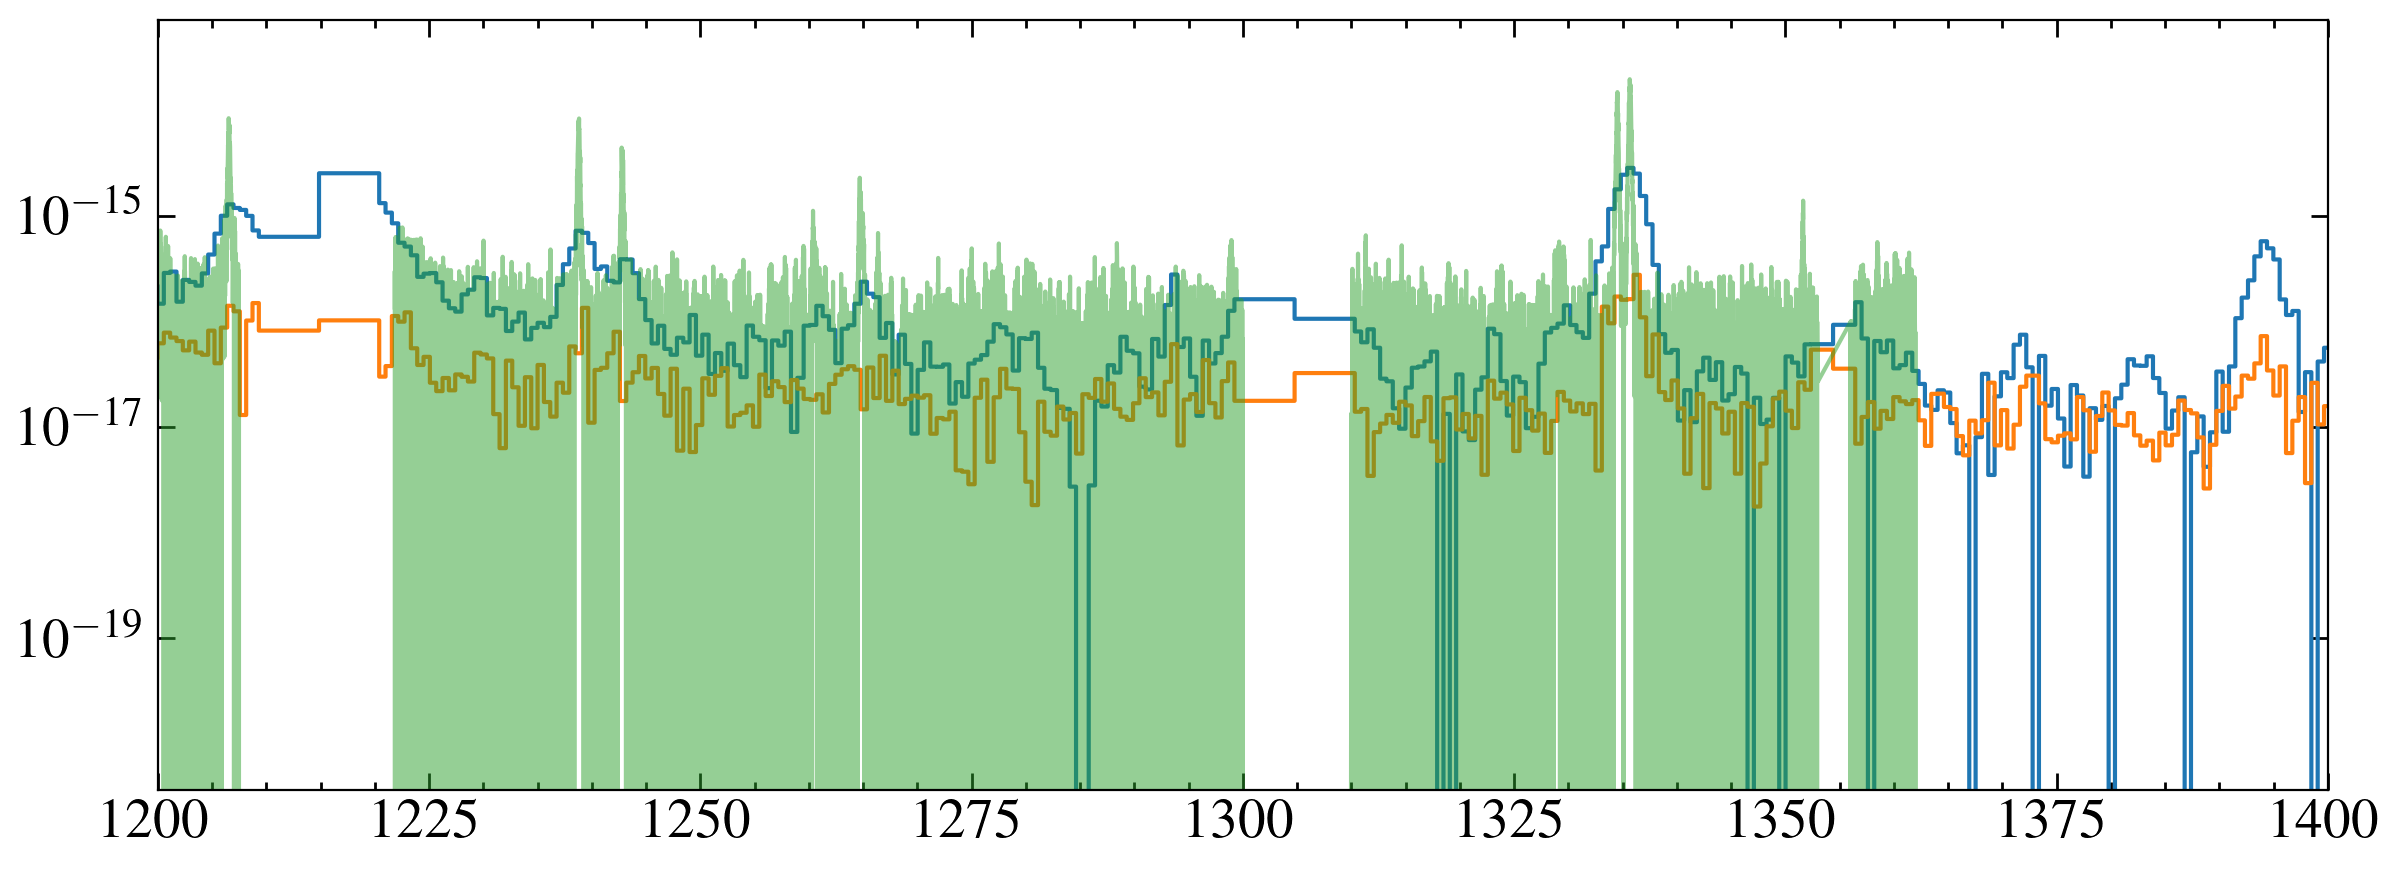

GJ674
COS 3.776468003287951e-14 8.376079977025424e-16
STIS 5.528548321935139e-14 2.091198591994762e-15
0.6830849227281578


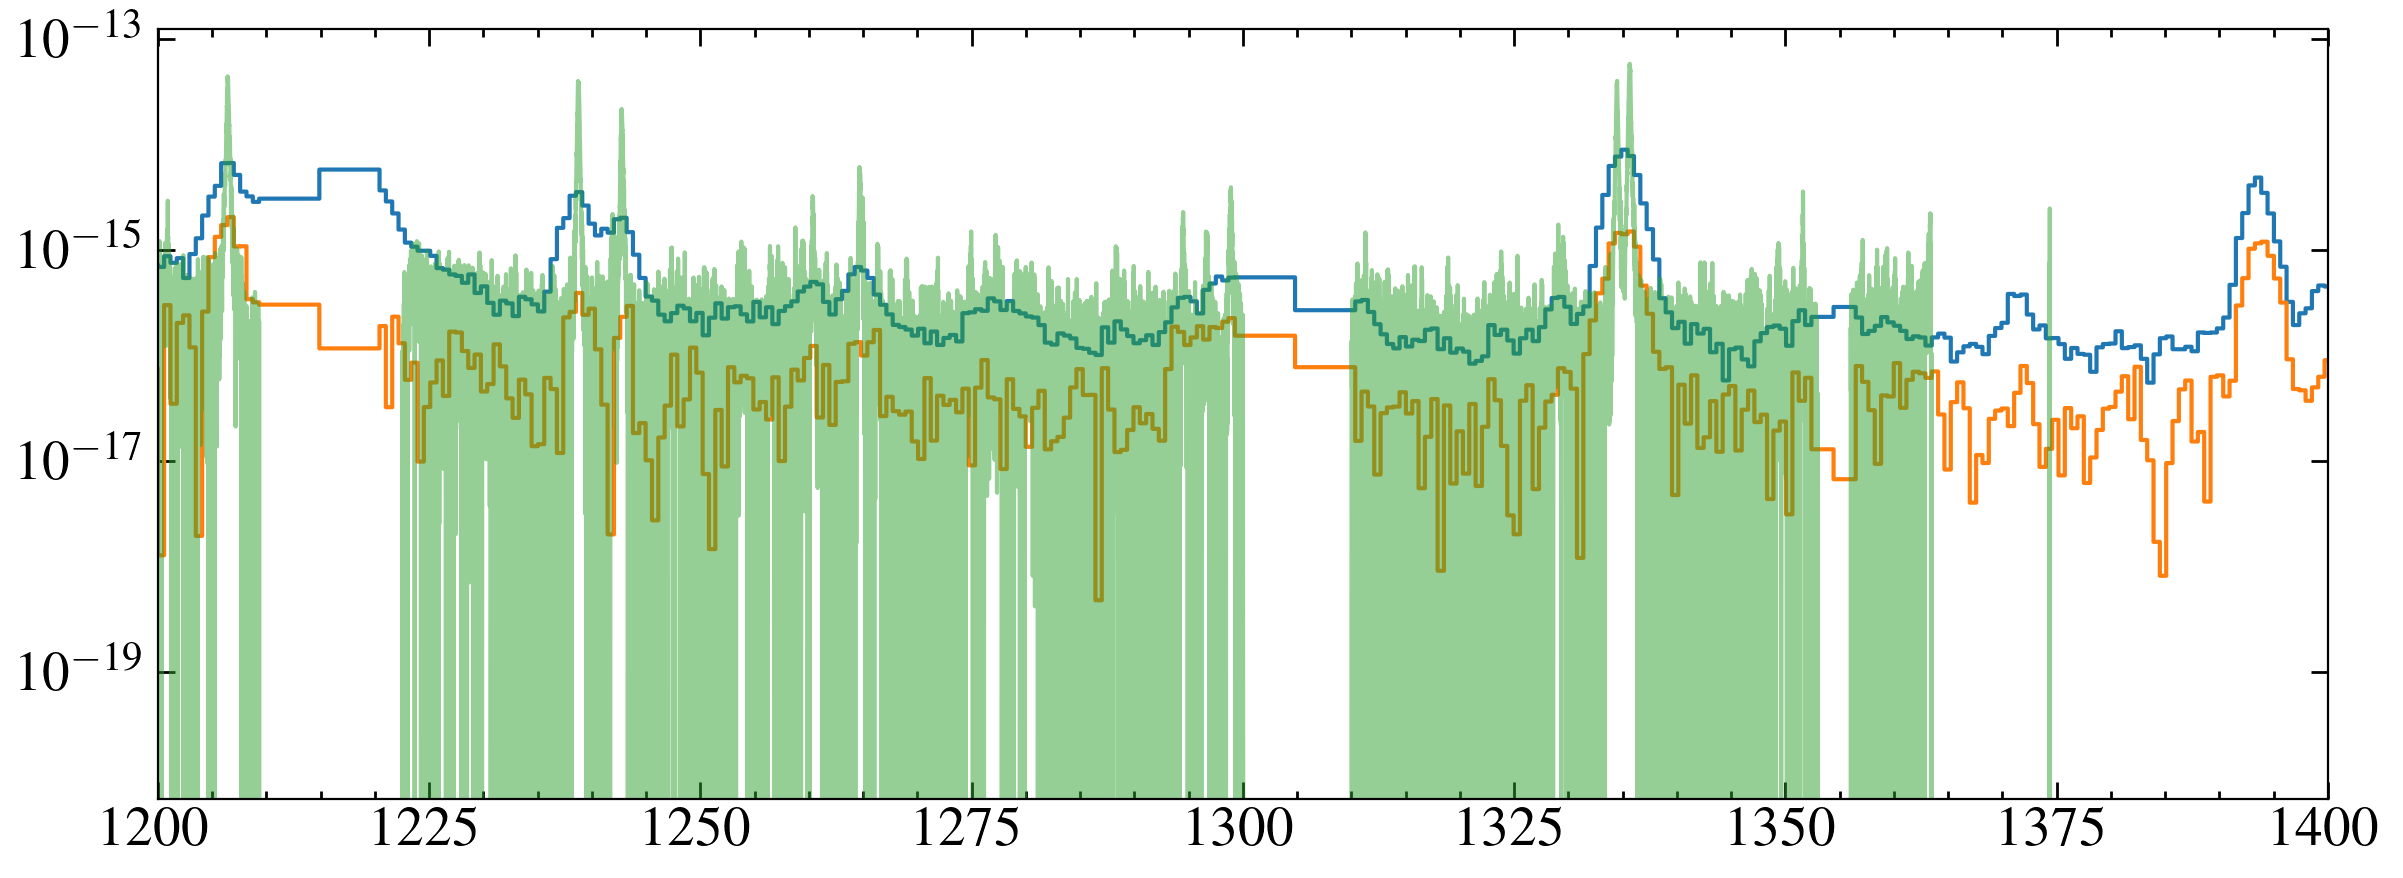

GJ676A
COS 1.6730482988647765e-14 3.830666810338502e-16
STIS 1.8992924305839265e-14 2.5300884229238522e-16
0.8808797802402695


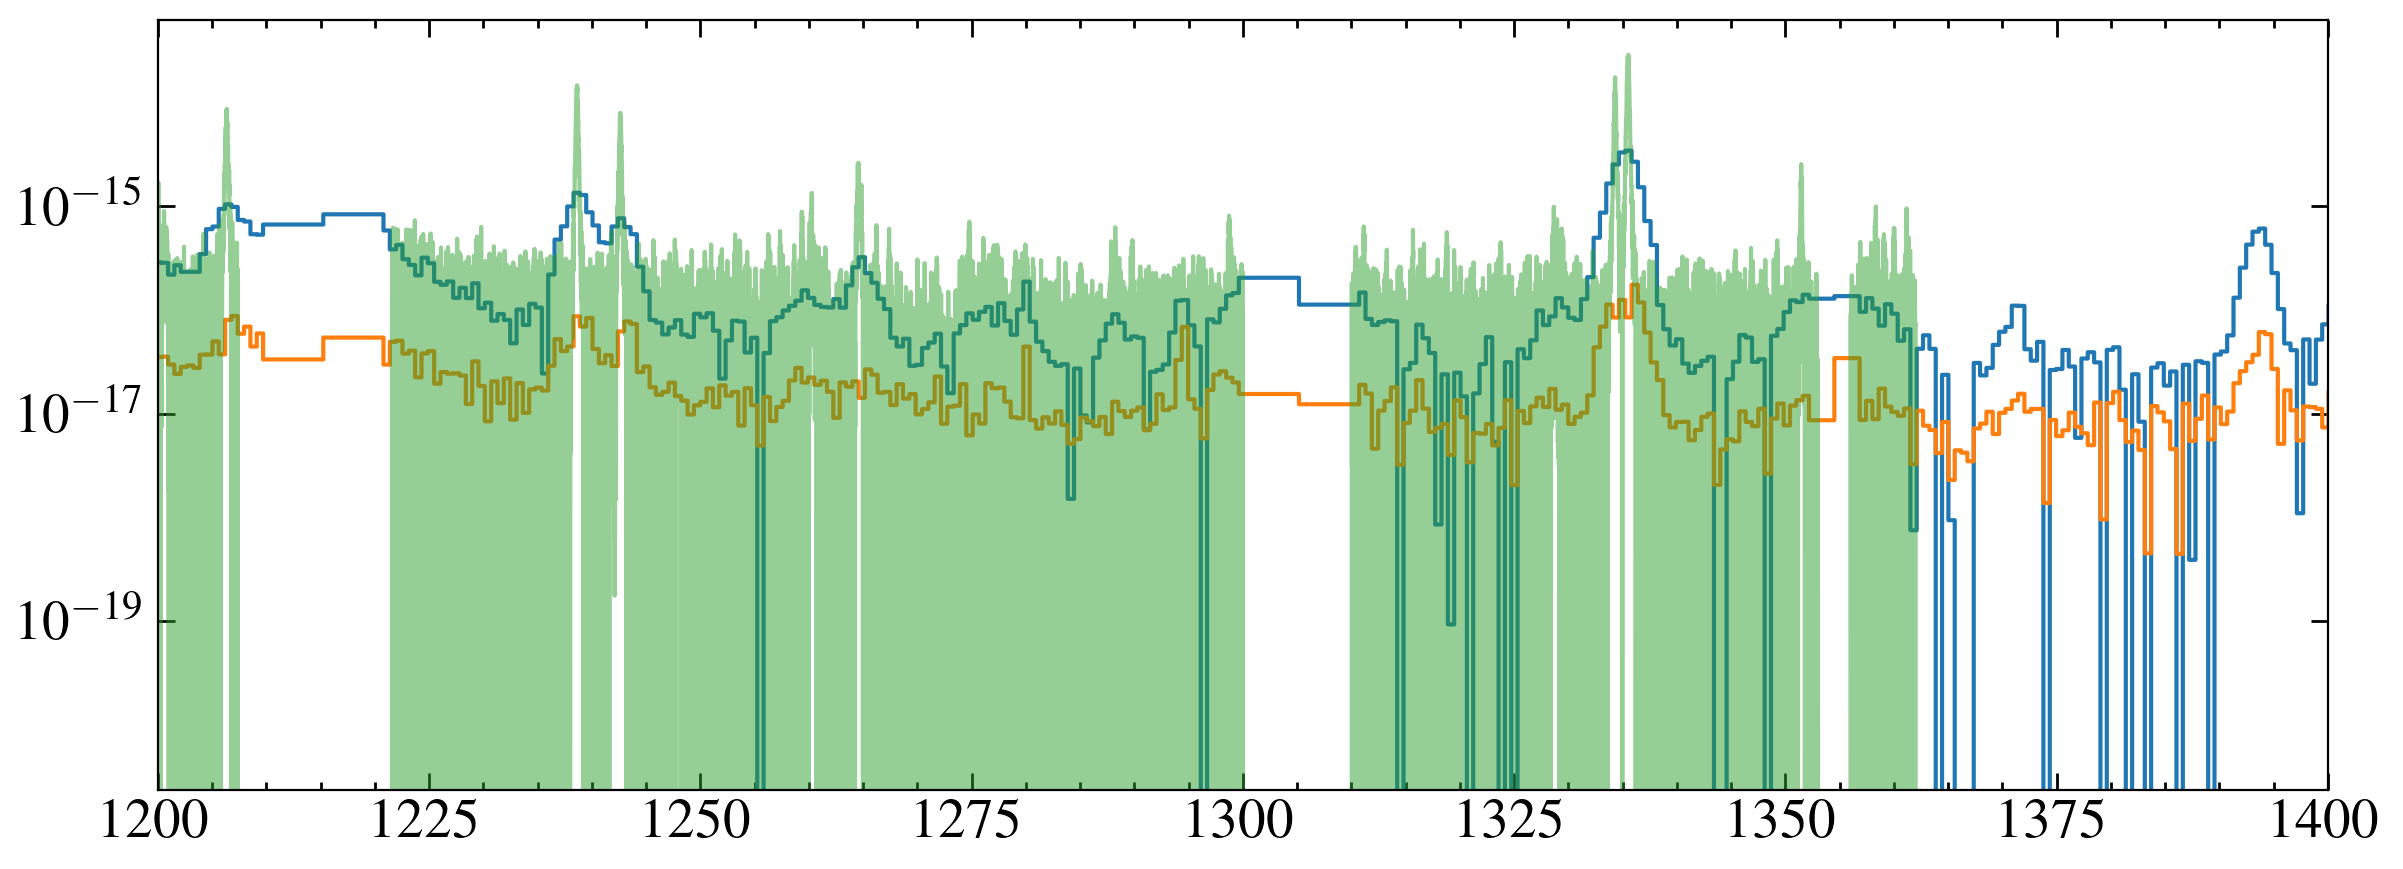

GJ699
COS 9.665756014816673e-15 7.882224014171475e-16
STIS 7.9676642023194e-15 4.559792118771077e-16
1.2131229139906468


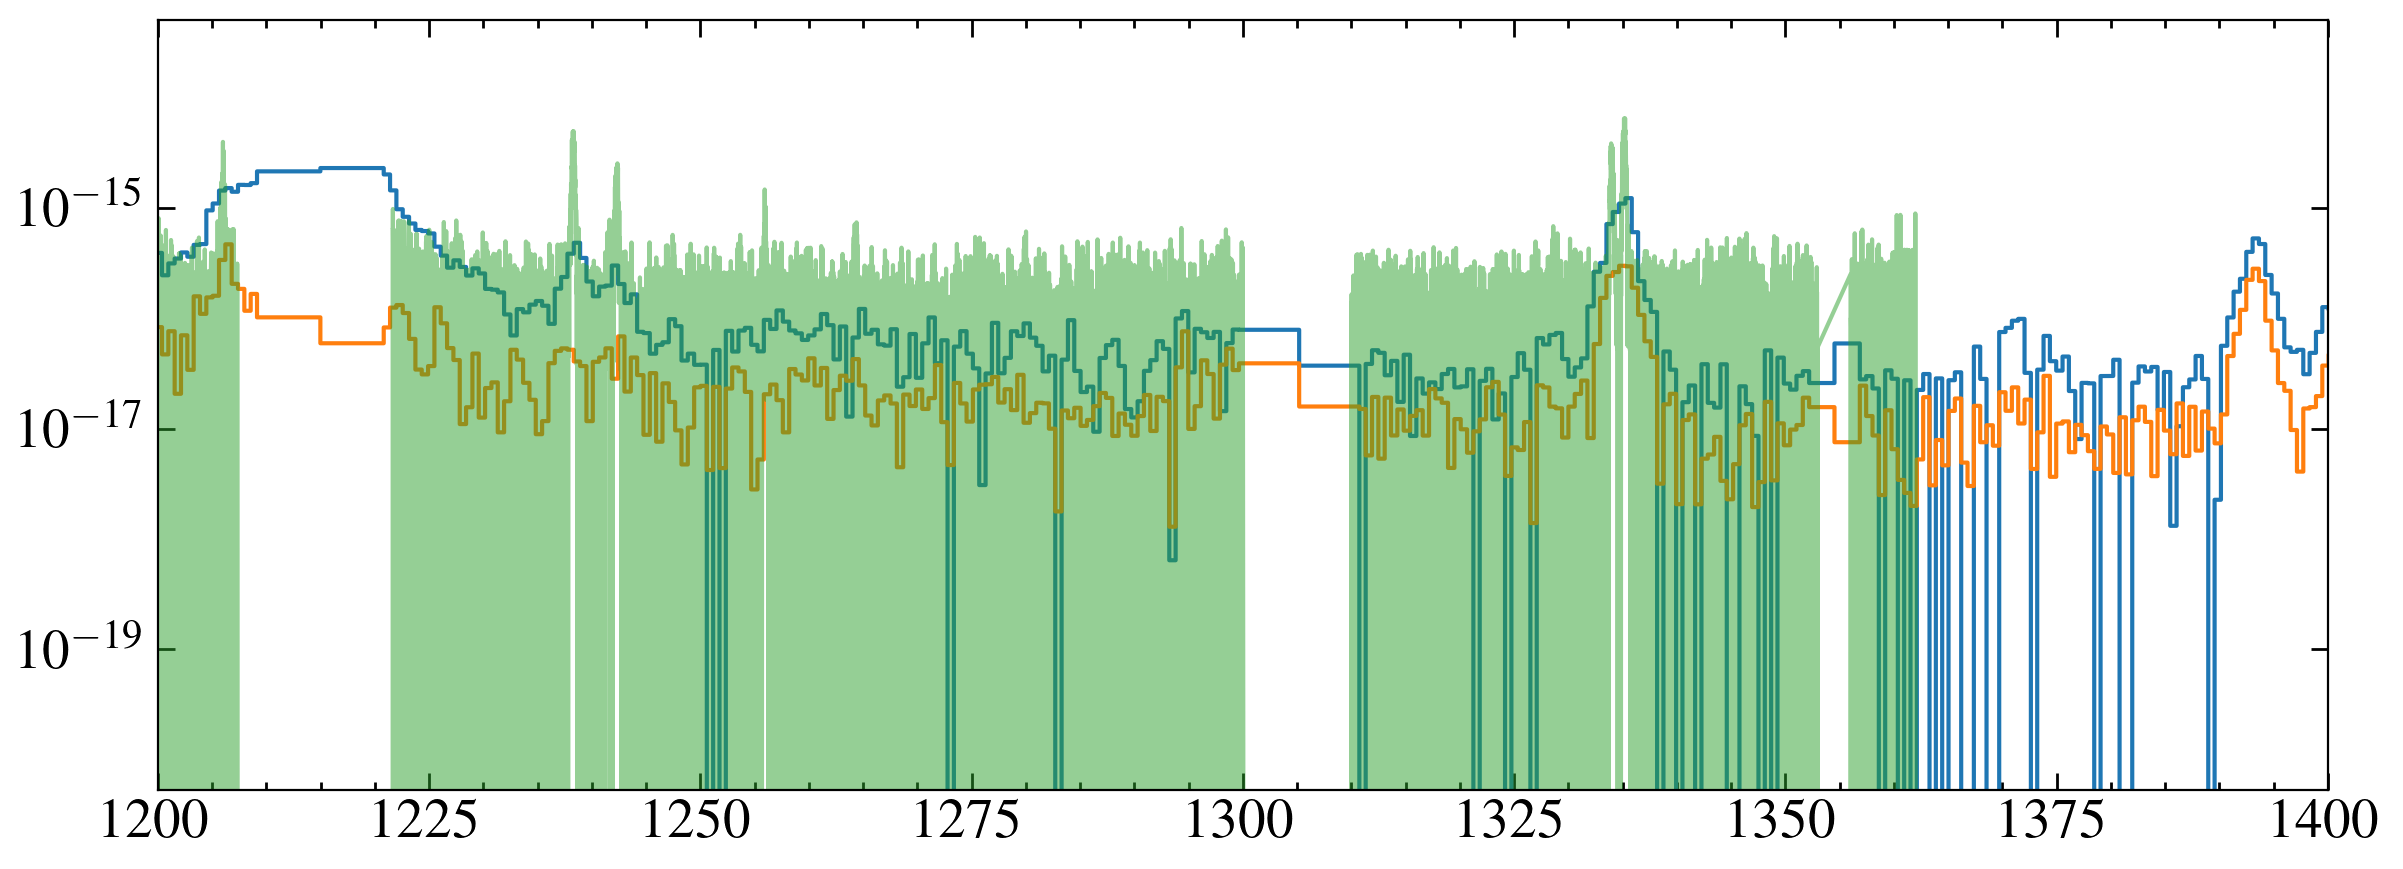

GJ729
GJ849
L-980-5
LHS-2686
COS 6.835062836420524e-15 5.146076033184597e-16
STIS 8.493524778256693e-15 3.956978754531464e-16
0.8047380816405211


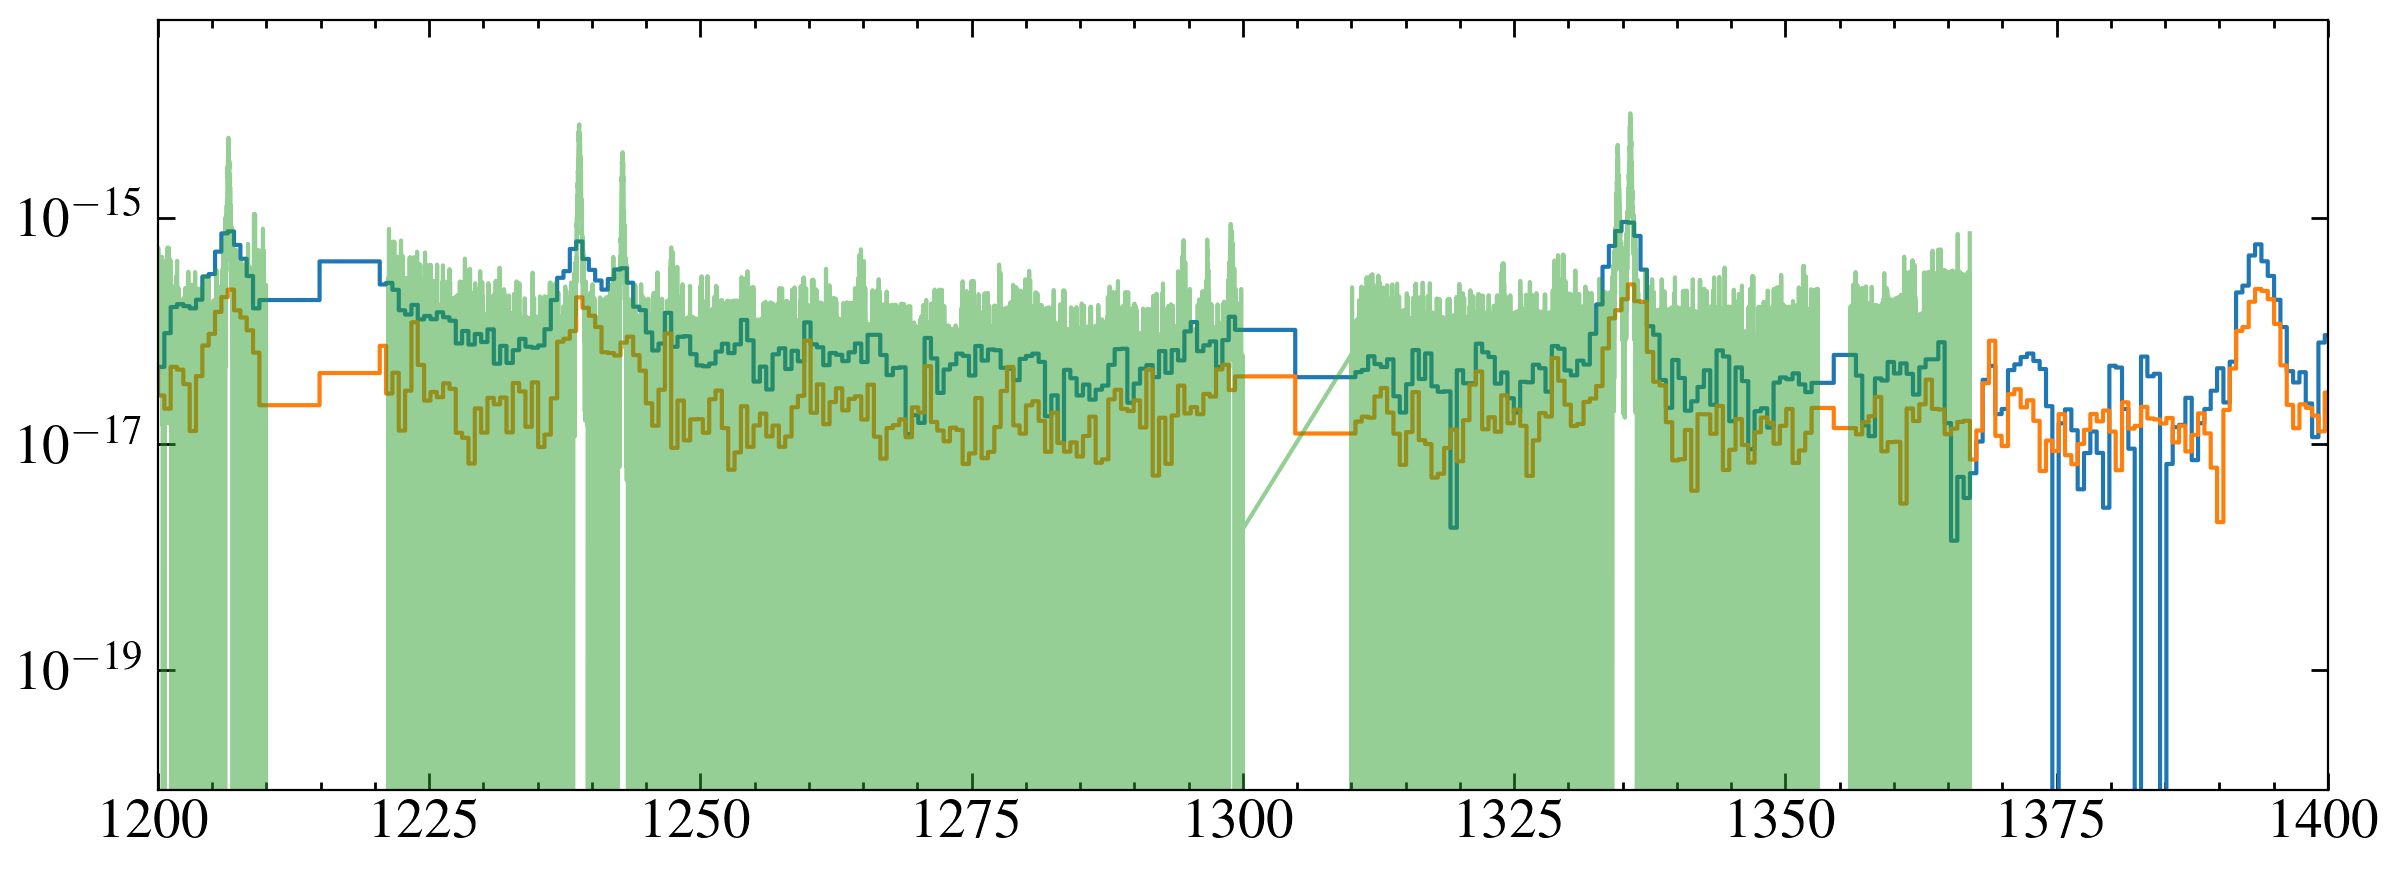

In [78]:
# lines = [1206.499, 1238.821,1242.804]
cosf = []
stisf = []
cose = []
stise = []

for star in stars[:-1]:
    print(star)
    fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        cosf.append(1.0)
        stisf.append(1.0)
        cose.append(1.0)
        stise.append(1.0)
        continue
    # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    mask = (fw < 1210) | (fw > 1220) & (fw < 1300) | (fw > 1310) & (fw < 1353) | (fw > 1356) #mask lya and o
    
    fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    plt.step(fw, ff, where='mid')
    plt.step(fw, fe, where='mid')
    
    # [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    # 1300, 1310, 1353, 1356 
    cos = glob.glob('{}{}/*g130m*'.format(path, star))
    if len(cos) > 0:
        smooth=5
        cdata = fits.getdata(cos[0], 1)
        cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
     
        if star == 'GJ699':
            sav = '../gj_699/COS/GJ699_quiesc_G130M_Mm1_NOSCL_24may2019.sav'
            cdata = readsav(sav)
            cw, cf, ce = cdata['wave'], cdata['flux'], cdata['err']
            
        if star == 'GJ674':
            spec = '../../stars/gj674_flare/gj674_flare_spectra/gj674_cos_preflare.csv'
            cdata = Table.read(spec)
            cw, cf, ce = cdata['wavelength'], cdata['flux'], cdata['error']
        
        mask = (cw < 1210) | (cw > 1220) & (cw < 1300) | (cw > 1310) & (cw < 1353) | (cw > 1356) #mask lya and oii
        cw, cf, ce = cw[mask], cf[mask], ce[mask]
        # cf = convolve(cf,Box1DKernel(smooth))
        # ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
        plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
         
    
    plt.xlim(1200, 1400)
    # plt.ylim(-1e-15)
    
    lines =[1250, cw[-1]]
    clinemask = (cw > lines[0]) & (cw < lines[1]) 
    # cint = np.trapz(cf[clinemask], cw[clinemask])
    cw0, cw1 = wavelength_edges(cw) 
    cw0, cw1, cf, ce = cw0[clinemask], cw1[clinemask], cf[clinemask], ce[clinemask]
    cfi = np.sum(cf*(cw1-cw0))
    cei = (np.sum(ce**2 * (cw1-cw0)**2))**0.5
    

    flinemask = (fw > lines[0]) & (fw < lines[1])
    # fint = np.trapz(ff[flinemask], fw[flinemask])
    fw0, fw1 = wavelength_edges(fw) 
    fw0, fw1, ff, fe = fw0[flinemask], fw1[flinemask], ff[flinemask], fe[flinemask]
    ffi = np.sum(ff*(fw1-fw0))
    fei = (np.sum(fe**2 * (fw1-fw0)**2))**0.5
    
    print('COS', cfi, cei)
    print('STIS', ffi, fei)
    print(cfi/ffi)
    
    cosf.append(cfi)
    stisf.append(ffi)
    cose.append(cei)
    stise.append(fei)
    


  
    
#     print(cint, fint, cint/fint)
    
#     scale = cint/fint
    
    plt.yscale('log')
    
    
#     plt.subplot(121)
    
#     plt.step(fw, ff, where='mid')
#     # plt.step(fw, fe, where='mid')
    
#     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
#     plt.plot(cw, cf,  c='C2')#, zorder=-10)

        
#     plt.xlim(1200, 1210)
    
    
#     plt.subplot(122)
    
#     plt.step(fw, ff, where='mid')
#     # plt.step(fw, fe, where='mid')
    
#     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
#     plt.plot(cw, cf, c='C2')#, zorder=-10)

        
#     plt.xlim(1235, 1245)
    
    plt.show()
cosf, stisf, cose, stise = np.array(cosf), np.array(stisf), np.array(cose), np.array(stise)

[1.15375507e-14 3.77646800e-14 1.67304830e-14 9.66575601e-15
 6.83506284e-15]
1.0
1.0
1.0
0.7772797937135048
0.6830849227281578
0.8808797802402695
1.2131229139906468
1.0
1.0
1.0
0.8047380816405211


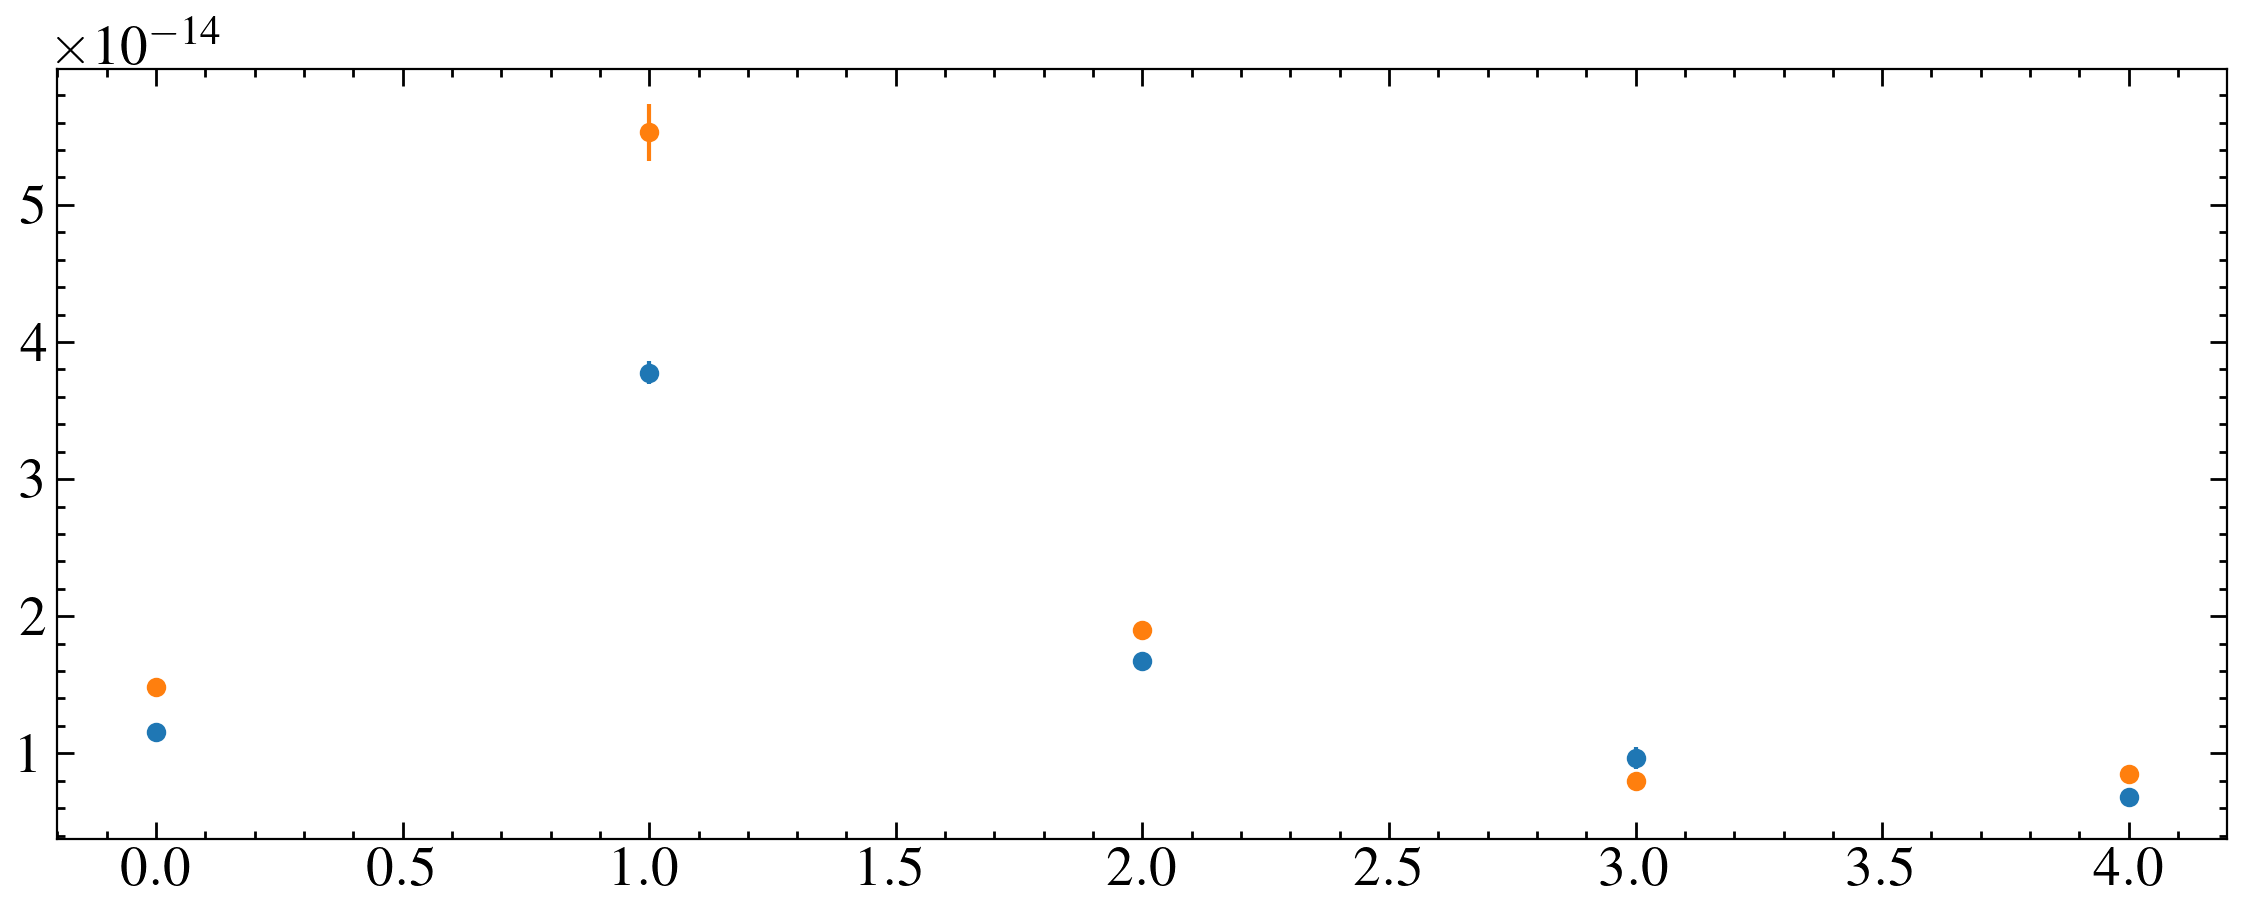

In [79]:
# print(cosf)
mask = (cosf != 1.0)
print(cosf[mask])
xax = np.arange(len(cosf[mask]))

plt.errorbar(xax, cosf[mask], yerr=cose[mask], ls='none', marker='o')
plt.errorbar(xax, stisf[mask], yerr=stise[mask], ls='none', marker='o')

for c, s in zip(cosf, stisf):
    print(c/s)

Ok intergrate over the 1335 lines. Sorted. Last step - when COS overlaps directly with 230L. Also need to use flare-free COS spectra. 

GJ1132
COS -1.4496674744675806e-15 2.991734632367045e-16
STIS 8.948379446799619e-15 3.331085216324011e-16
-0.16200335301897073


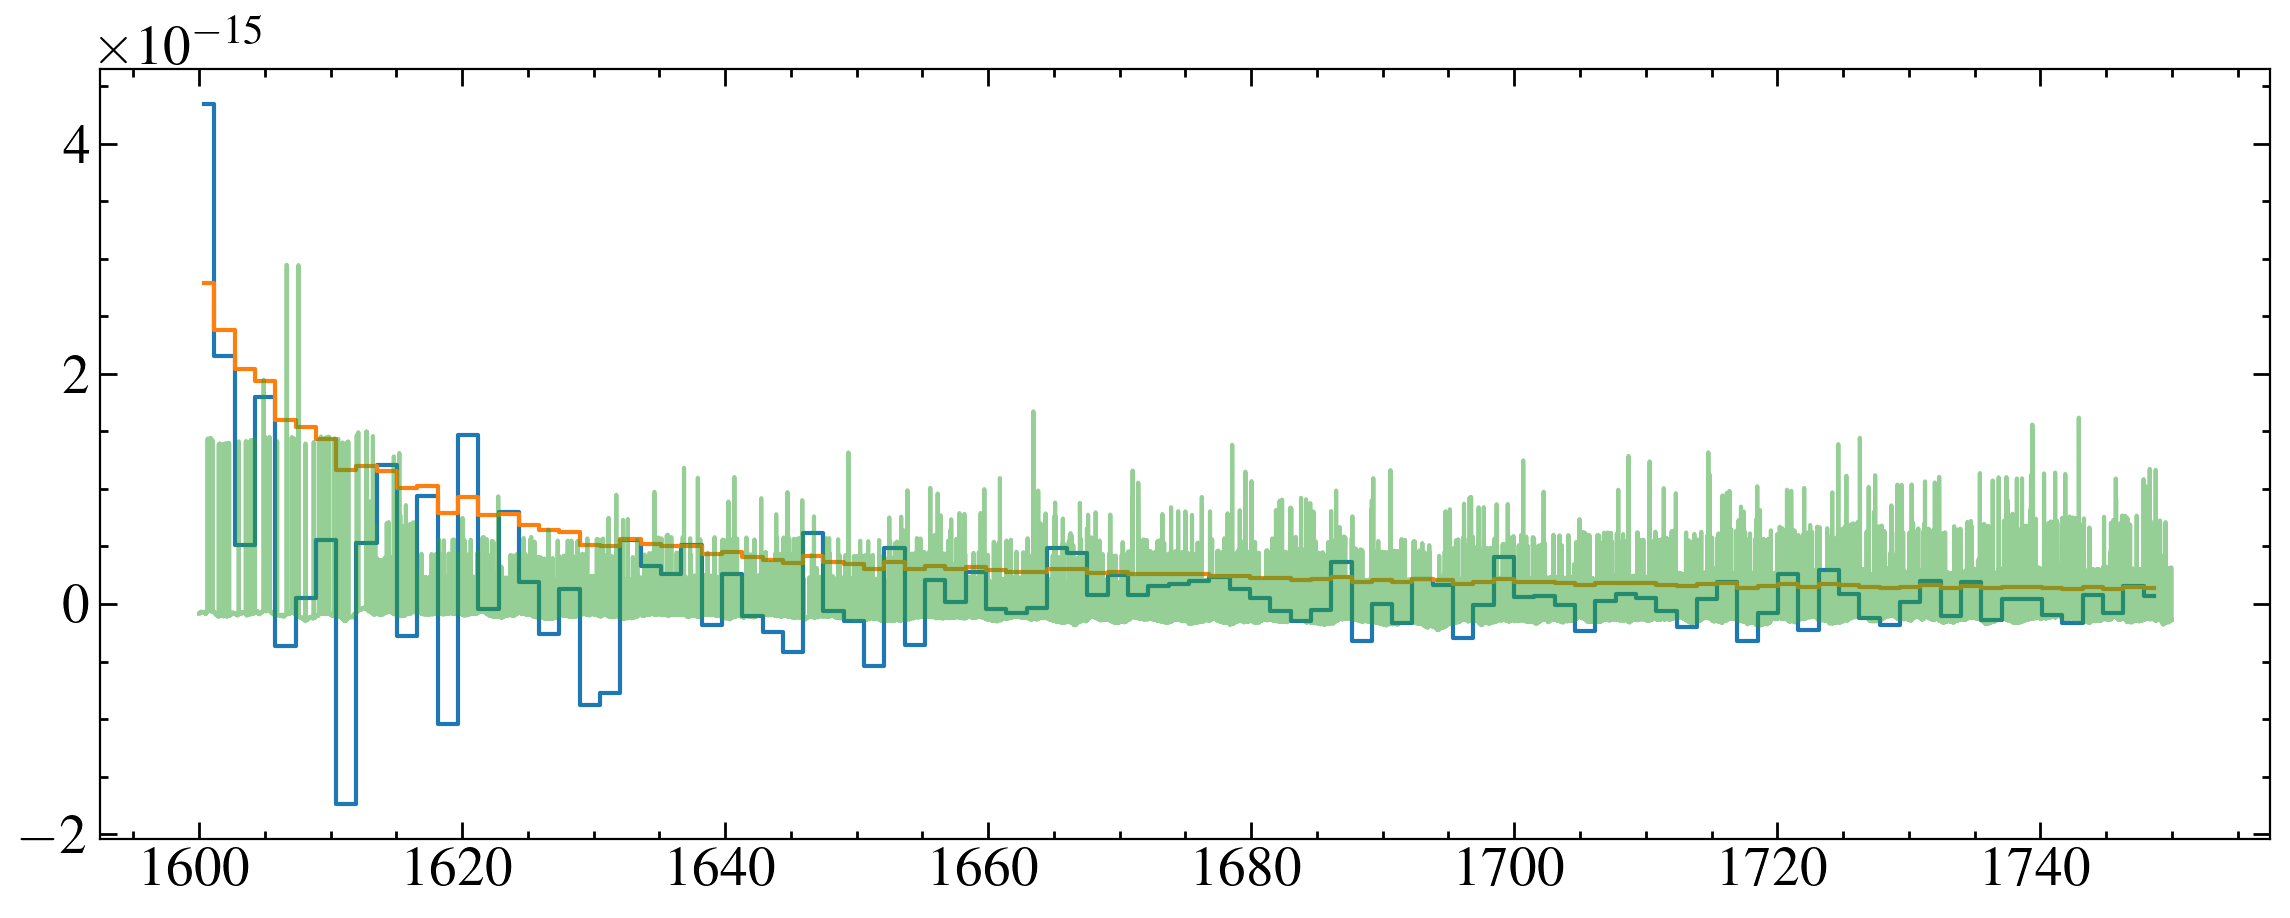

GJ15A
GJ163
COS -4.023161418540898e-16 2.479621625340127e-16
STIS 8.948379446799619e-15 3.331085216324011e-16
-0.044959664958997454


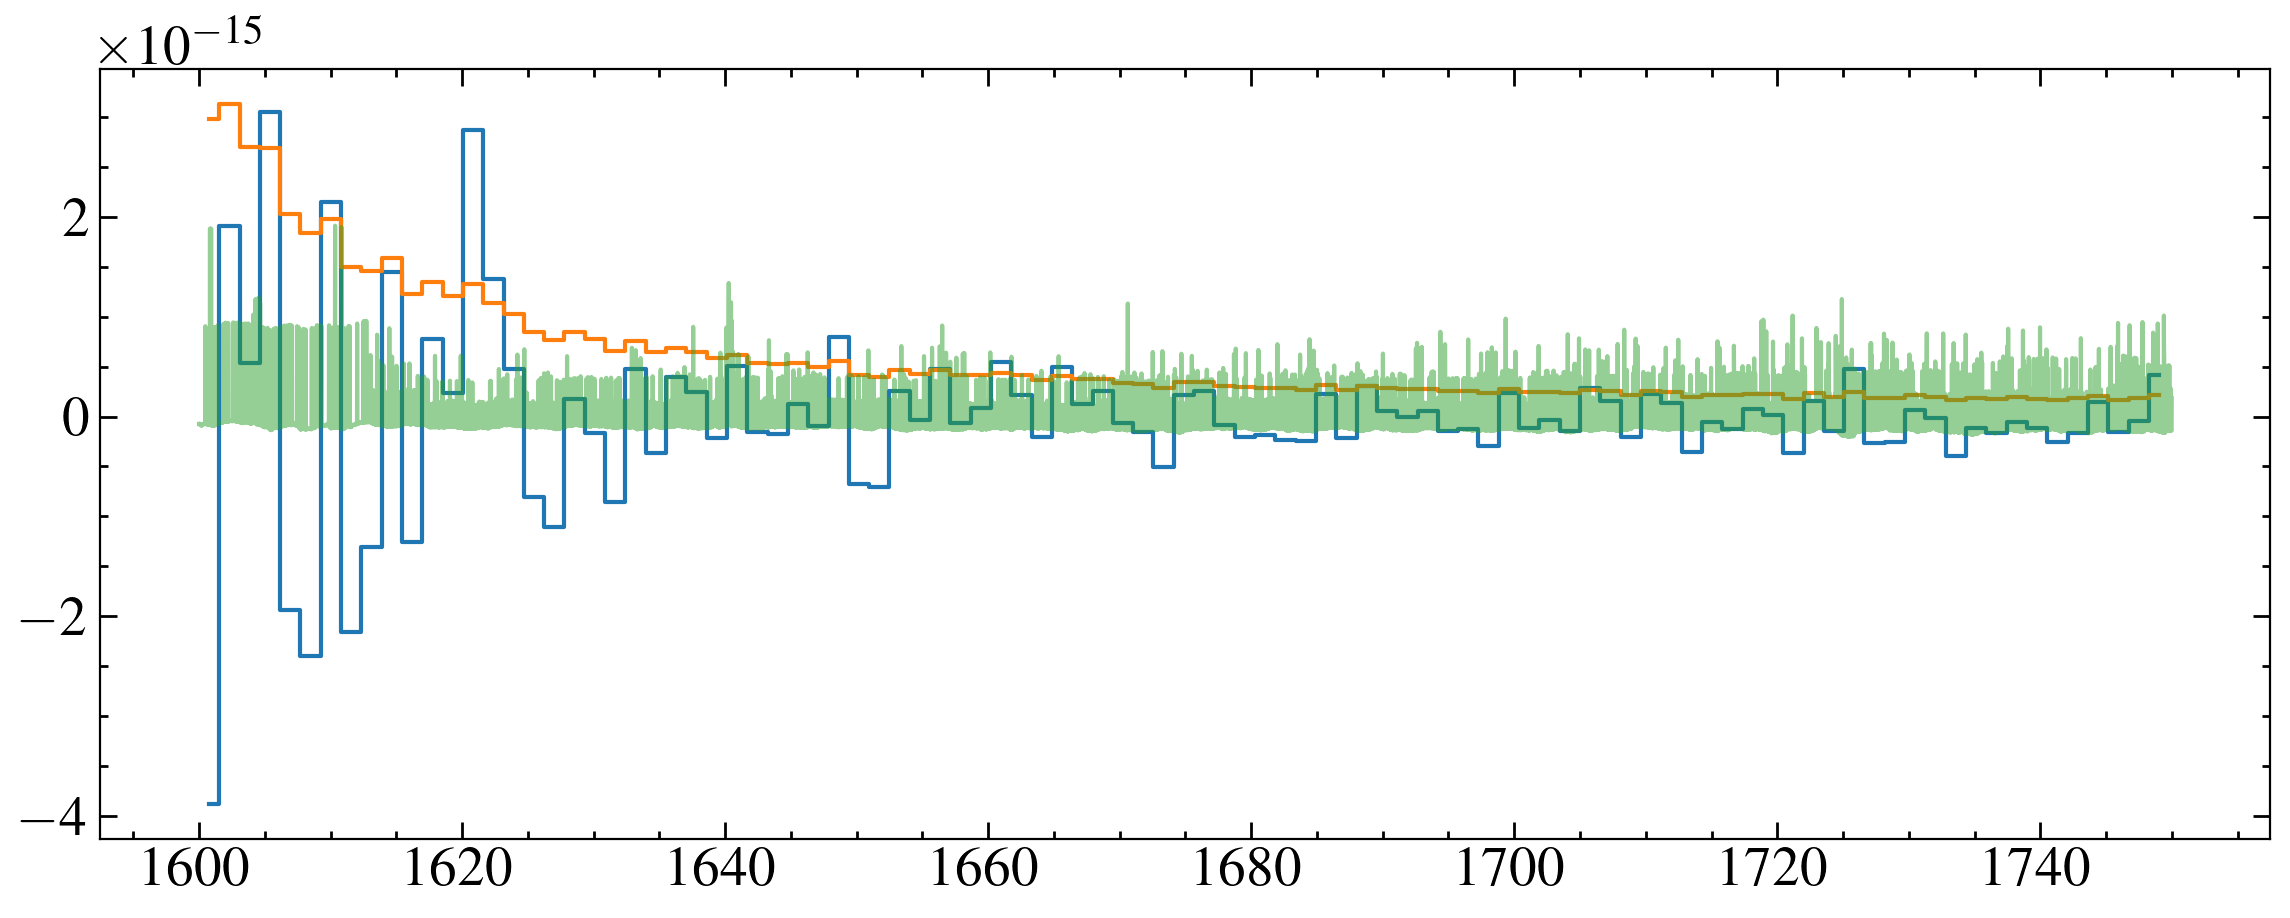

GJ649
GJ674
GJ676A
GJ699
GJ729
GJ849
COS 1.2093204207644773e-14 4.10690975757152e-16
STIS 8.948379446799619e-15 3.331085216324011e-16
1.351440702703985


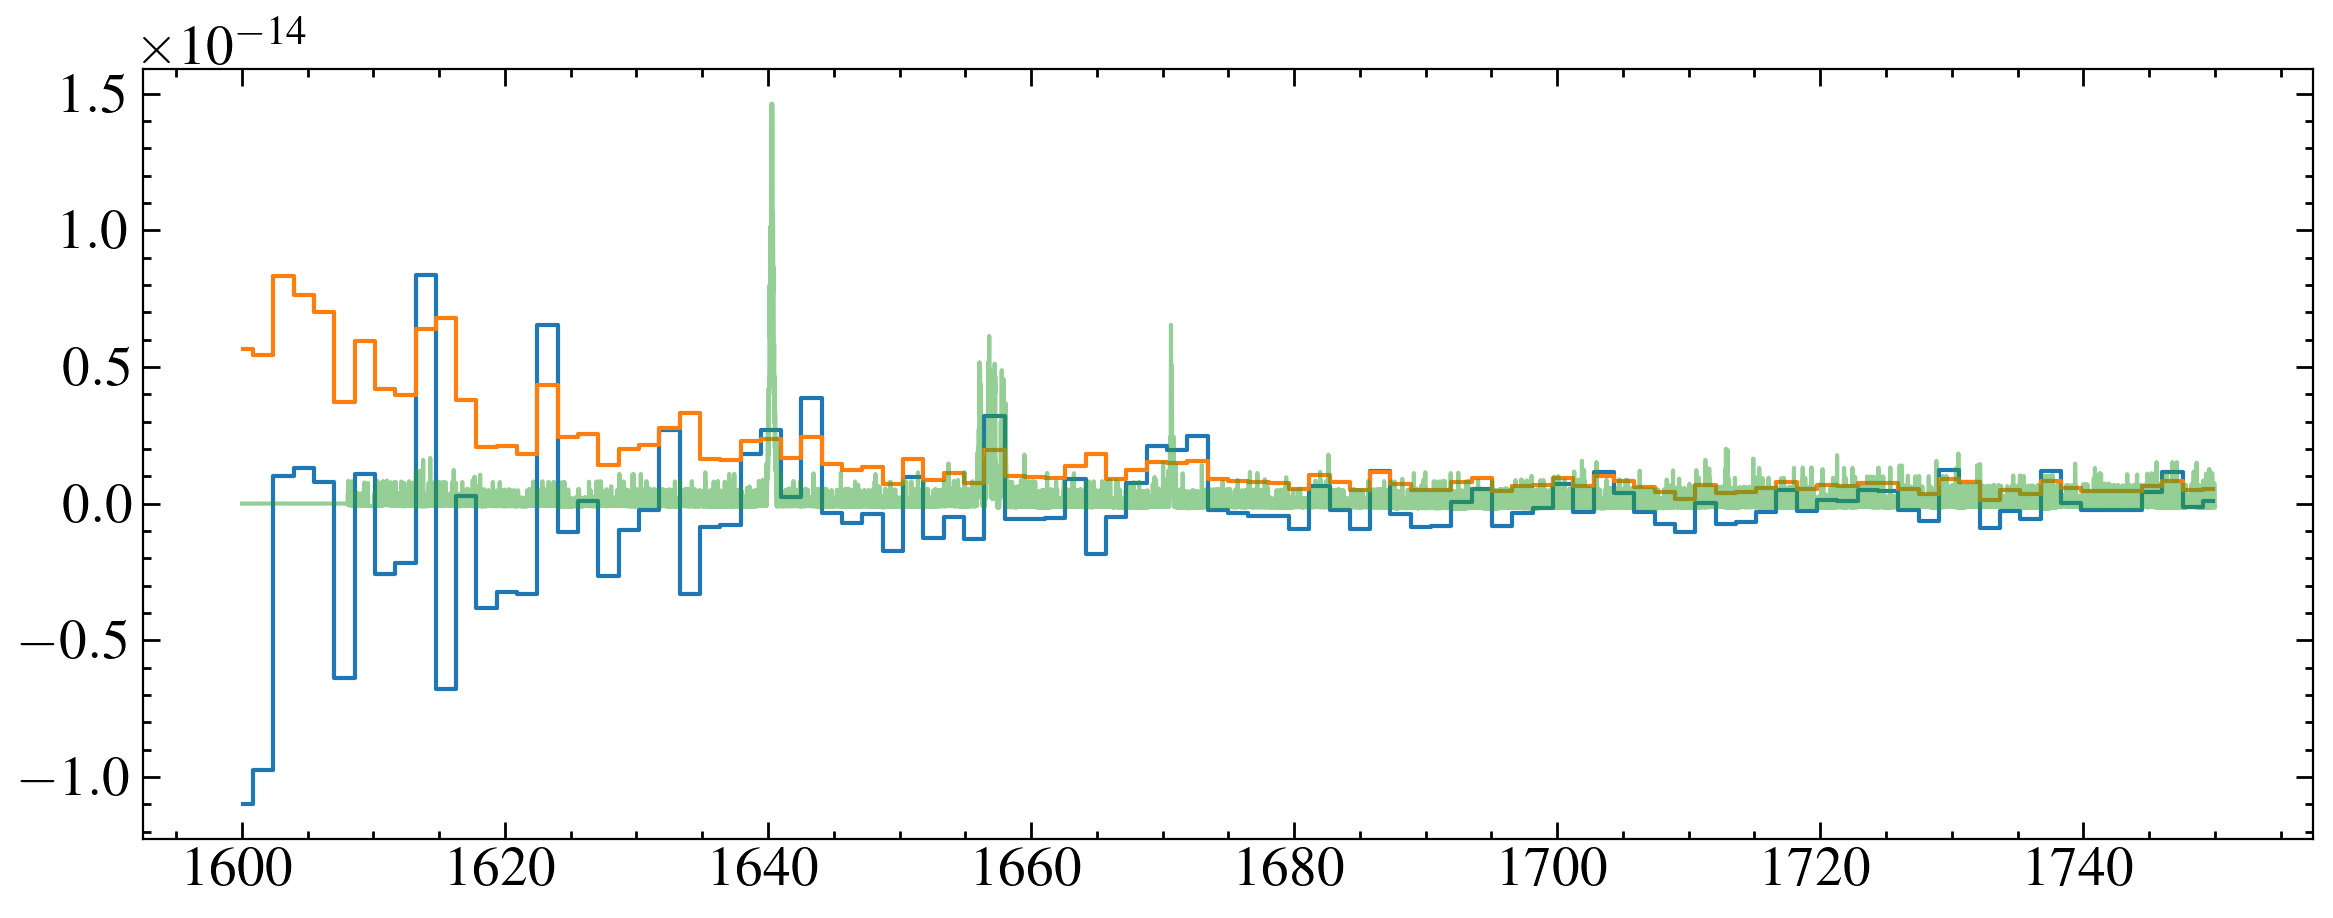

L-980-5
COS 6.848311971994694e-16 6.377722936859409e-16
STIS 8.948379446799619e-15 3.331085216324011e-16
0.07653130952603925


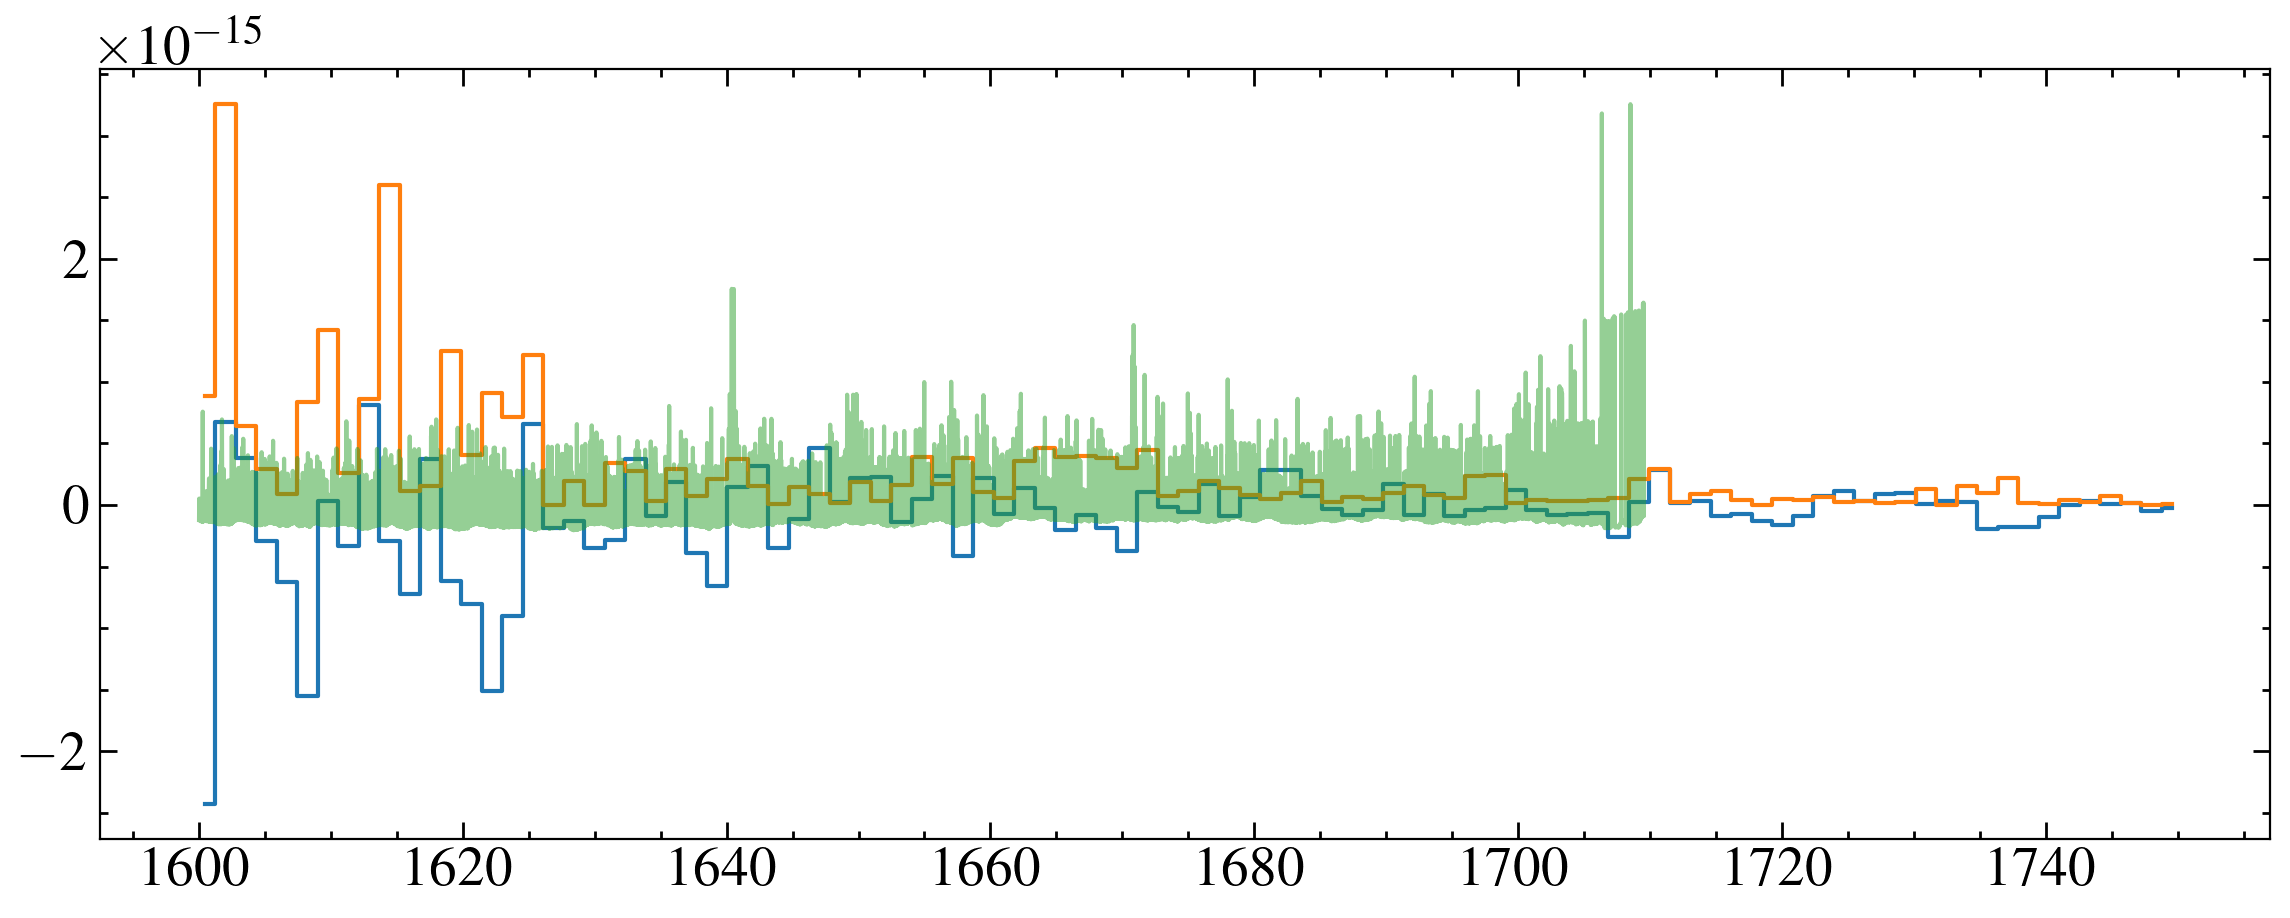

LHS-2686


In [73]:
cosf = []
stisf = []
cose = []
stise = []


for star in stars[:-1]:
    print(star)
    cos = glob.glob('{}{}/*g160m*'.format(path, star))
    if len(cos) == 0:
        cosf.append(1.0)
        stisf.append(1.0)
        cose.append(1.0)
        stise.append(1.0)
        continue
        
    smooth=5
    cdata = fits.getdata(cos[0], 1)
    cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
    mask = (cw < 1210) | (cw > 1220) #mask lya
    cw, cf, ce = cw[mask], cf[mask], ce[mask]
    # cf = convolve(cf,Box1DKernel(smooth))
    # ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
        
    nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
        
    # print(star)
    # fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    # if len(fuv) == 0:
        # continue
    #
    
    ndata = fits.getdata(nuv[0], 1)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    
    # mask = (fw < 1210) | (fw > 1220) #mask lya
    
    # fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    lap = [1600, 1750]
    cmask = (cw > lap[0]) & (cw < lap[1])
    cw, cf, ce = cw[cmask], cf[cmask], ce[cmask]
    
    nmask = (nw > lap[0]) & (nw < lap[1])
    nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
    
    
    plt.step(nw, nf, where='mid')
    plt.step(nw, ne, where='mid')
    
    plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
    
    # plt.step(fw, fe, where='mid')
    
    # [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    # plt.xlim(1300, 1400)
    # plt.ylim(-1e-15)
#     lines =[1630, 1680]
#     nlinemask = (nw > lines[0]) & (nw < lines[1])
#     nint = np.trapz(nf[nlinemask], nw[nlinemask])
    
#     clinemask = (cw > lines[0]) & (cw < lines[1])
#     cint = np.trapz(cf[clinemask], cw[clinemask])
  

    # print(nint, cint, nint/cint)
    
    lines =[1630, cw[-1]]
    clinemask = (cw > lines[0]) & (cw < lines[1])
    # cint = np.trapz(cf[clinemask], cw[clinemask])
    cw0, cw1 = wavelength_edges(cw) 
    cw0, cw1, cf, ce = cw0[clinemask], cw1[clinemask], cf[clinemask], ce[clinemask]
    cfi = np.sum(cf*(cw1-cw0))
    cei = (np.sum(ce**2 * (cw1-cw0)**2))**0.5
    

    nlinemask = (nw > lines[0]) & (nw < lines[1])
    # fint = np.trapz(ff[flinemask], fw[flinemask])
    nw0, nw1 = wavelength_edges(nw) 
    nw0, nw1, nf, ne = nw0[nlinemask], nw1[nlinemask], nf[nlinemask], ne[nlinemask]
    nfi = np.sum(nf*(nw1-nw0))
    nei = (np.sum(ne**2 * (nw1-nw0)**2))**0.5
    
    print('COS', cfi, cei)
    print('STIS', ffi, fei)
    print(cfi/ffi)
    
    cosf.append(cfi)
    stisf.append(ffi)
    cose.append(cei)
    stise.append(fei)
    
#     lines =[1330, 1340]
#     c

#     flinemask = (fw > lines[0]) & (fw < lines[1])
#     fint = np.trapz(ff[flinemask], fw[flinemask])



    # print(cint, fint, cint/fint)
    
    # scale = cint/fint
    plt.show()
    
cosf, stisf, cose, stise = np.array(cosf), np.array(stisf), np.array(cose), np.array(stise)

[-1.44966747e-15 -4.02316142e-16  1.20932042e-14  6.84831197e-16]
-0.16200335301897073
1.0
-0.044959664958997454
1.0
1.0
1.0
1.0
1.0
1.351440702703985
0.07653130952603925
1.0


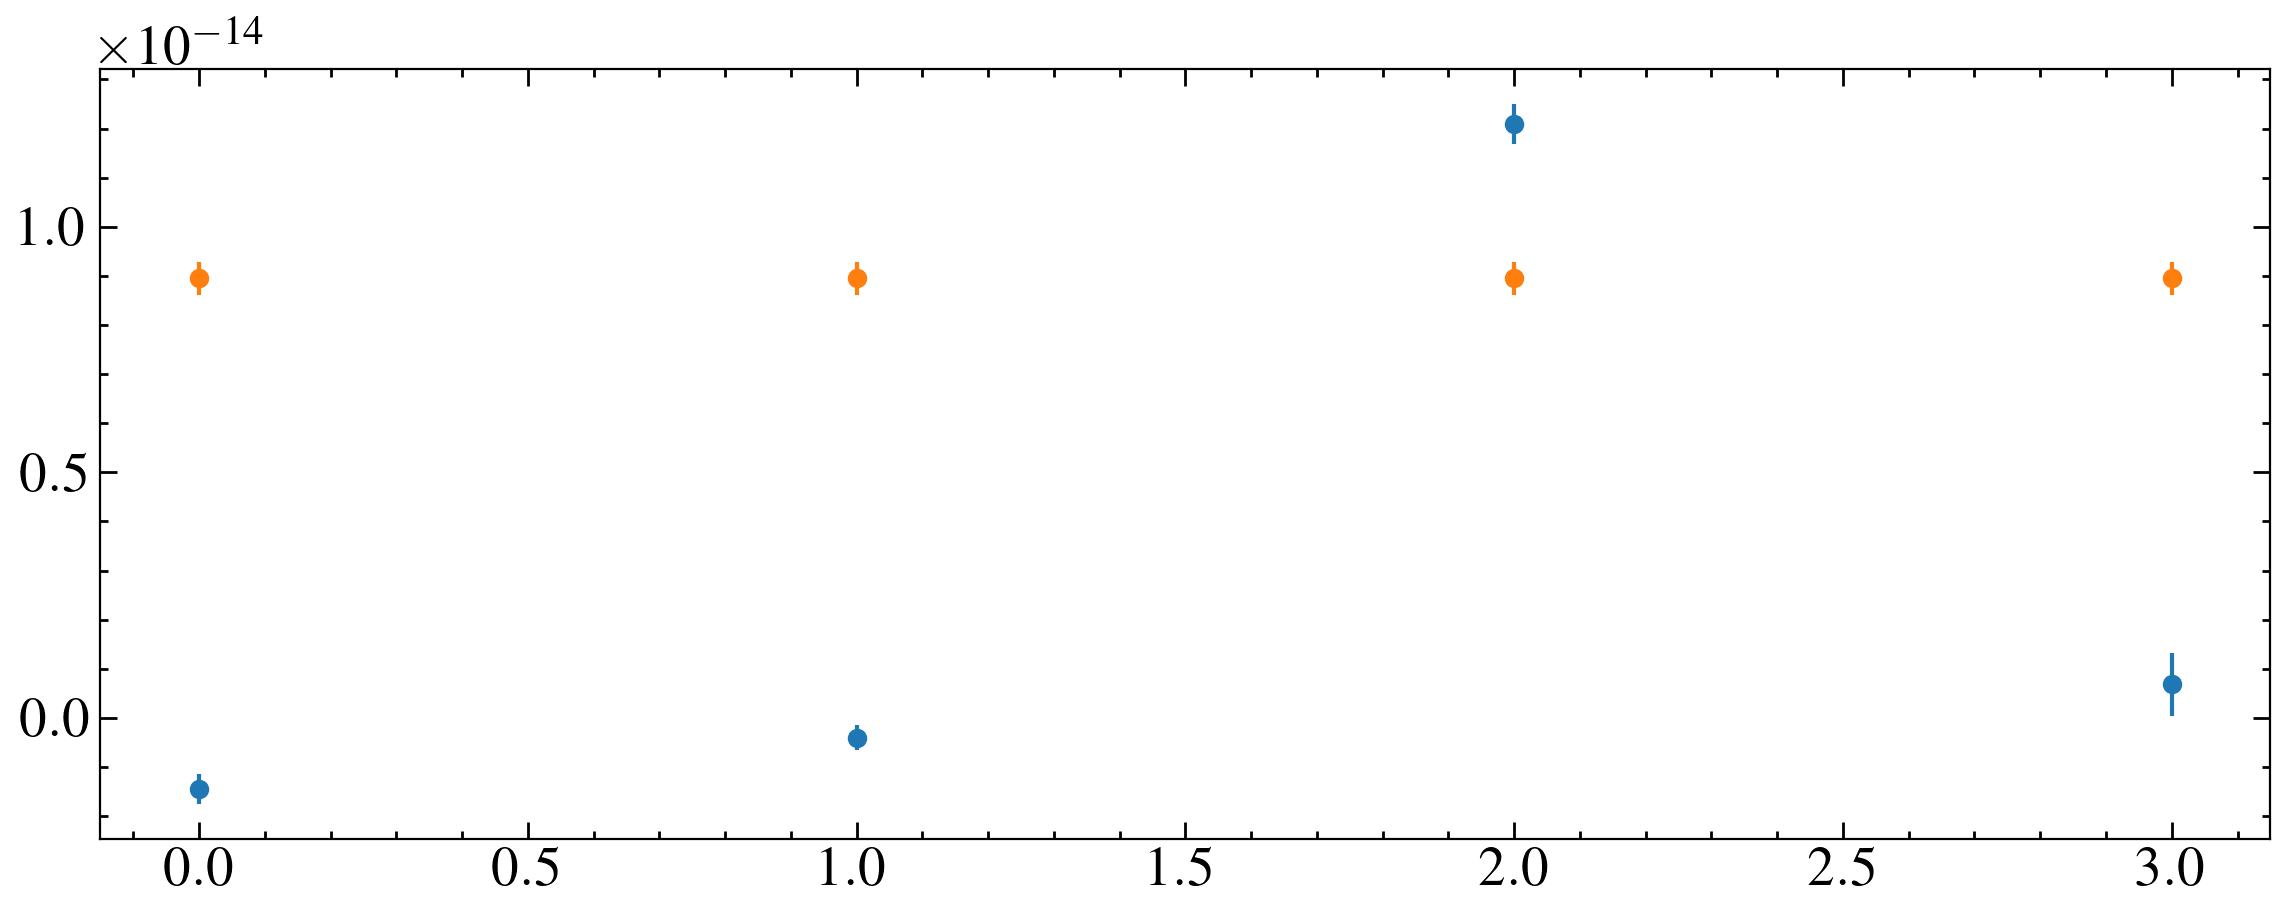

In [74]:
mask = (cosf != 1.0)
print(cosf[mask])
xax = np.arange(len(cosf[mask]))

plt.errorbar(xax, cosf[mask], yerr=cose[mask], ls='none', marker='o')
plt.errorbar(xax, stisf[mask], yerr=stise[mask], ls='none', marker='o')

for c, s in zip(cosf, stisf):
    print(c/s)

Either negligable flux overlap or not signifcant. But these are the same lines as for the STIS G140L to NUV overlap- just use the same.  

So would be:  
- match STIS G140M to Flare free COS spectra. - no, lines could vary.
- if exists match COS G130M to STIS G140L with 1340 AA lines.
- match COS G160M or STIS G140L to STIS G230L with 1640 lines
- matching to G430L probably not an option.

Is this pointless? STIS is higher than COS in most cases, and it's emission-line dominated.